<a href="https://colab.research.google.com/github/james-yu2005/Affi-NN-ity/blob/main/PDBBindReadable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install -q rdkit-pypi torch-geometric pandas tqdm deepchem fair-esm biopython torch

In [68]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout
import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from rdkit import Chem
from rdkit.Chem import Draw
import deepchem as dc
import esm
from tqdm import tqdm
from Bio import PDB
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
import matplotlib.pyplot as plt

In [63]:
amino_acid_to_idx = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
    'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18,
    'W': 19, 'Y': 20
}

In [64]:
tasks, datasets, transformers = dc.molnet.load_pdbbind(
    featurizer='raw',
    set_name='refined',
    splitter='random',
    reload=True
)
train_dataset, valid_dataset, test_dataset = datasets
print(f"Train dataset length: {len(train_dataset)}\nValidate dataset length: {len(valid_dataset)}\nTest dataset length: {len(test_dataset)}")

Train dataset length: 3881
Validate dataset length: 485
Test dataset length: 486


In [65]:
for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
    print("Example of first datum from training :\n")
    print("Input features (X):", X)
    print("Binding affinity target label (y):", y)
    print("Weight (w):", w)
    print("Sample ID (ids):", ids)
    break

Example of first datum from training :

Input features (X): [['/tmp/refined-set/2wgj/2wgj_ligand.sdf'
  '/tmp/refined-set/2wgj/2wgj_pocket.pdb']]
Binding affinity target label (y): [1.17136862]
Weight (w): [1.]
Sample ID (ids): ['2wgj']


In [66]:
def remove_invalid_molecules(dc_dataset, dataset_name):
    valid_entries = []
    removed = 0
    for X, y, w, ids in dc_dataset.iterbatches(batch_size=1, deterministic=True):
      ligand_path = X[0][0]
      ligand_mol = Chem.MolFromMolFile(str(ligand_path))

      if ligand_mol is None:
        if str(dataset_name) == "train":
          removed += 1
        elif str(dataset_name) == "valid":
          removed += 1
        elif str(dataset_name) == "test":
          removed += 1
        continue

      valid_entries.append((X, y, w, ids))

    return valid_entries, removed

clean_train_dataset, train_removed = remove_invalid_molecules(train_dataset, "train")
clean_valid_dataset, valid_removed = remove_invalid_molecules(valid_dataset, "valid")
clean_test_dataset, test_removed = remove_invalid_molecules(test_dataset, "test")

print(f"New train dataset length: {len(clean_train_dataset)}. Removed molecules: {train_removed}\nNew validate dataset length: {len(clean_valid_dataset)}. Removed molecules: {valid_removed}\nNew test dataset length: {len(clean_test_dataset)}. Removed molecules: {test_removed}")
print(f"Example of first datum after cleaning:\n")

Streaming output truncated to the last 5000 lines.
[21:24:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:26] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:26] Explicit valence for atom # 39 C, 6, is greater than permitted
[21:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:26] Warning: molecule is tagged as 2D, but at lea

New train dataset length: 2562. Removed molecules: 1319
New validate dataset length: 334. Removed molecules: 151
New test dataset length: 310. Removed molecules: 176
Example of first datum after cleaning:



[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Explicit valence for atom # 31 N, 4, is greater than permitted
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coor

In [67]:
def get_all_protein_lengths(dataset):
  parser = PDB.PDBParser(QUIET=True)
  molecule_protein_lengths = []
  for X, y, w, ids in dataset:
    protein_path = X[0][1]
    structure = parser.get_structure("protein", protein_path)
    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())
        length = len(str(sequence))
    molecule_protein_lengths.append(length)

  return molecule_protein_lengths

def get_all_ligand_lengths(dataset):
  molecule_ligand_lengths = []
  for X, y, w, ids in dataset:
    ligand_path = X[0][0]
    ligand_mol = Chem.MolFromMolFile(str(ligand_path))
    ligand_smiles = Chem.MolToSmiles(ligand_mol)
    length = len(str(ligand_smiles))
    molecule_ligand_lengths.append(length)

  return molecule_ligand_lengths

ligand_train_length_dataset = get_all_ligand_lengths(clean_train_dataset)
ligand_valid_length_dataset = get_all_ligand_lengths(clean_valid_dataset)
ligand_test_length_dataset = get_all_ligand_lengths(clean_test_dataset)
protein_train_length_dataset = get_all_protein_lengths(clean_train_dataset)
protein_valid_length_dataset = get_all_protein_lengths(clean_valid_dataset)
protein_test_length_dataset = get_all_protein_lengths(clean_test_dataset)

[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

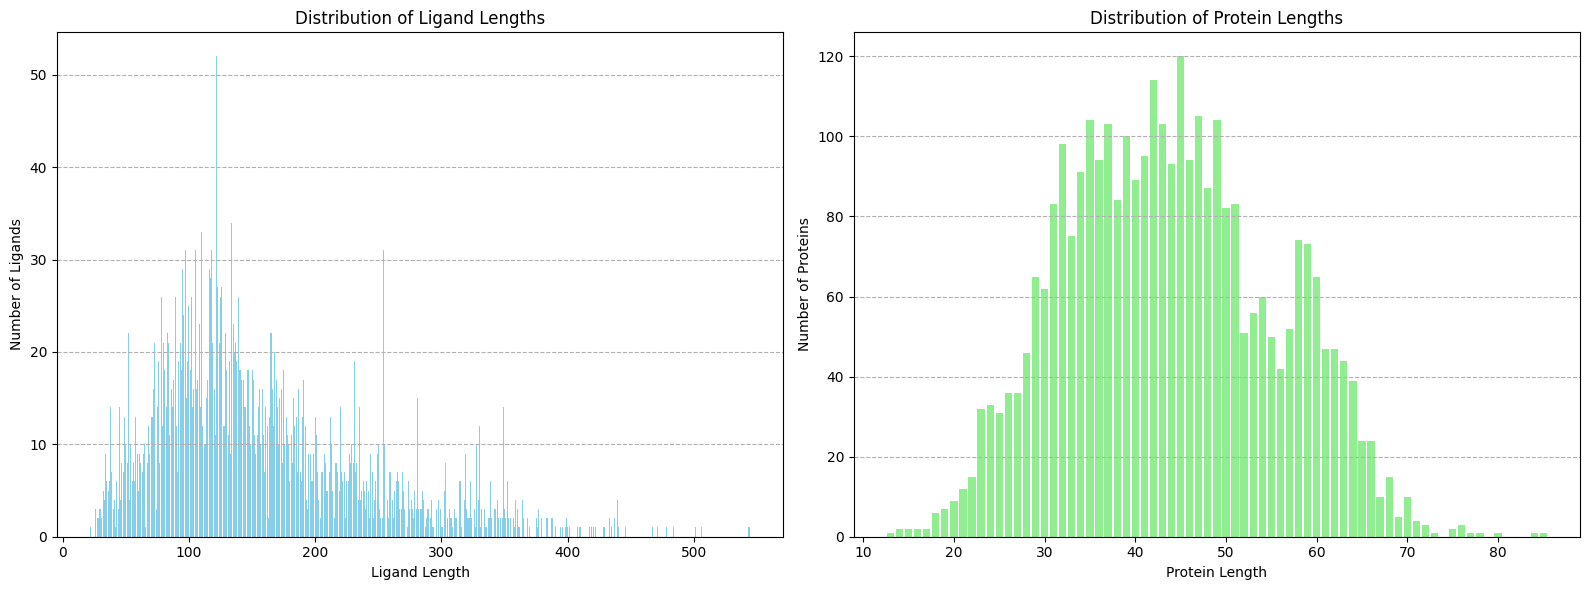

Max ligand length: 544
90% of ligands are shorter than or equal to: 275
Max protein length: 85
90% of proteins are shorter than or equal to: 60


In [69]:
## Combine all ligand lengths
all_ligand_lengths = ligand_train_length_dataset + ligand_valid_length_dataset + ligand_test_length_dataset
ligand_length_counts = Counter(all_ligand_lengths)
ligand_lengths = sorted(ligand_length_counts.keys())
ligand_counts = [ligand_length_counts[length] for length in ligand_lengths]

## Combine all protein lengths
all_protein_lengths = protein_train_length_dataset + protein_valid_length_dataset + protein_test_length_dataset
protein_length_counts = Counter(all_protein_lengths)
protein_lengths = sorted(protein_length_counts.keys())
protein_counts = [protein_length_counts[length] for length in protein_lengths]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

## Ligand plot
axs[0].bar(ligand_lengths, ligand_counts, color='skyblue')
axs[0].set_xlabel('Ligand Length')
axs[0].set_ylabel('Number of Ligands')
axs[0].set_title('Distribution of Ligand Lengths')
axs[0].grid(axis='y', linestyle='--')

## Protein plot
axs[1].bar(protein_lengths, protein_counts, color='lightgreen')
axs[1].set_xlabel('Protein Length')
axs[1].set_ylabel('Number of Proteins')
axs[1].set_title('Distribution of Protein Lengths')
axs[1].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

## Stats for ligand
max_ligand = max(all_ligand_lengths)
ligand_cutoff = int(np.percentile(all_ligand_lengths, 90))
print(f"Max ligand length: {max_ligand}")
print(f"90% of ligands are shorter than or equal to: {ligand_cutoff}")

## Stats for protein
max_protein = max(all_protein_lengths)
protein_cutoff = int(np.percentile(all_protein_lengths, 90))
print(f"Max protein length: {max_protein}")
print(f"90% of proteins are shorter than or equal to: {protein_cutoff}")

In [70]:
def get_node_features(mol): # node features are atoms
    '''Iterates over all atoms in a molecule and creates a feature vector/tensor'''
    all_node_feats = []
    for atom in mol.GetAtoms():
        # node_feat_dim = 9
        node_features = [
            atom.GetAtomicNum(), # Atomic number (e.g., C=6, O=8).
            atom.GetDegree(), # Number of directly bonded neighbors.
            atom.GetFormalCharge(), # Formal charge on the atom.
            int(atom.GetHybridization()),  # convert enum to int, Hybridization type encoded as integer (sp, sp2, sp3).
            atom.GetIsAromatic(), # Boolean: is it part of an aromatic ring?
            atom.GetTotalNumHs(), # Total number of attached hydrogens.
            atom.GetNumRadicalElectrons(), # Number of unpaired electrons
            atom.IsInRing(), # 	Boolean: is it part of any ring?
            int(atom.GetChiralTag())  # convert enum to int: 	Encodes chirality (R/S configuration).
        ]
        all_node_feats.append(node_features)
    return torch.tensor(all_node_feats, dtype=torch.float)

def get_edge_features(mol): # edge features are bonds
    '''Iterates over all edges in a molecule and returns a feature vector/tensor'''
    all_edge_feats = []
    for bond in mol.GetBonds():
        edge_feats = [
            bond.GetBondTypeAsDouble(), # Bond type as float (single=1, double=2, etc.).
            bond.IsInRing() # Boolean: is bond part of a ring?
        ]
        all_edge_feats += [edge_feats, edge_feats]  # Adds each edge twice ([i → j] and [j → i]) to make the graph bidirectional, which is important for GNNs
    return torch.tensor(all_edge_feats, dtype=torch.float)

def get_adjacency_info(mol):
    '''
    PyTorch Geometric represents a graph's connectivity using an edge index tensor, wich sotores pairs of connected node indices
    In a GNN each node updates its state based on its connected neighbours. Without connectivity info, the model wouldn't know how atoms are bonded
    Shape: [2 rows representing source and target node, num_edges columns]
    '''
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]  # Bidirectional edges
    return torch.tensor(edge_indices, dtype=torch.long).t().contiguous() # transpose because PyTorch Geometric expects a certain format, contiguous for GPU goodness

In [71]:
def extract_lettered_sequence_from_pdb(pdb_path):
    """Extracts the amino acid sequence from a PDB file using Biopython."""
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)

    ppb = PDB.PPBuilder() # PPBuilder: Builds polypeptides from the structure (continuous stretches of amino acids).

    sequence = ""
    for pp in ppb.build_peptides(structure): # build_peptides(structure): Returns a list of polypeptides found in the structure.
        sequence += str(pp.get_sequence()) # get_sequence(): Extracts the sequence of amino acids as a string (e.g., "MKTLLILT").
    return sequence

def encode_sequence_to_num(sequence, required_length=100):
    ''' Encodes the lettered amino acid sequence to numbered format via mapping with truncation/zero-filling as needed'''
    encoded_sequence = [amino_acid_to_idx.get(amino_acid, 0) for amino_acid in sequence]  # 0 for unknowns
    if len(encoded_sequence) < required_length:
        return encoded_sequence + [0] * (required_length - len(encoded_sequence))
    return encoded_sequence[:required_length]

In [72]:
def get_max_protein_sequence_length():
    '''
    Iterates over all samples in the train_dataset and:
    - extracts the protein sequence from each sample's PDB file
    - tracks and returns the max sequence length across the dataset
    '''
    max_len = 0
    molecule_data = []

    for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
        protein_path = X[0][1]
        lettered_protein_sequence = extract_lettered_sequence_from_pdb(protein_path)
        max_len = max(max_len, len(lettered_protein_sequence))
        # print(f"Protein path: {protein_path}")
    return max_len

get_max_protein_sequence_length()

97

In [73]:
def process_deepchem_dataset(dataset):
    ligand_protein_data = []

    for X, y, w, ids in dataset.iterbatches(batch_size=1, deterministic=True):
        ligand_path = X[0][0]
        print(f"Ligard path: {ligand_path}")

        protein_path = X[0][1]
        print(f"Protein path: {protein_path}")

        ligand_mol = Chem.MolFromMolFile(str(ligand_path))

        if ligand_mol is None:
          print(f"Failed to load ligand molecule from {ligand_path}")
          continue  # Skip this sample

        node_features = get_node_features(ligand_mol)
        edge_features = get_edge_features(ligand_mol)
        adjacency_info = get_adjacency_info(ligand_mol)

        lettered_protein_sequence = extract_lettered_sequence_from_pdb(protein_path)
        protein_features_num = encode_sequence_to_num(lettered_protein_sequence)
        protein_features_num_tensor = torch.tensor(protein_features_num, dtype=torch.long).unsqueeze(0)

        data = Data(
            x=node_features,                     # atom features (PyG expects x)
            edge_index=adjacency_info,           # graph edges (PyG expects edge_index)
            edge_attr=edge_features,             # bond features
            y=torch.tensor(y, dtype=torch.float) # target label
        )

        data.protein_features_num = protein_features_num_tensor
        ligand_protein_data.append(data)

    return ligand_protein_data

In [74]:
train_graphs = process_deepchem_dataset(train_dataset)
valid_graphs = process_deepchem_dataset(valid_dataset)
test_graphs = process_deepchem_dataset(test_dataset)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

Ligard path: /tmp/refined-set/2wgj/2wgj_ligand.sdf
Protein path: /tmp/refined-set/2wgj/2wgj_pocket.pdb
Ligard path: /tmp/refined-set/1rpf/1rpf_ligand.sdf
Protein path: /tmp/refined-set/1rpf/1rpf_pocket.pdb
Ligard path: /tmp/refined-set/5u4b/5u4b_ligand.sdf
Protein path: /tmp/refined-set/5u4b/5u4b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u4b/5u4b_ligand.sdf
Ligard path: /tmp/refined-set/1x8j/1x8j_ligand.sdf
Protein path: /tmp/refined-set/1x8j/1x8j_pocket.pdb
Ligard path: /tmp/refined-set/5o07/5o07_ligand.sdf
Protein path: /tmp/refined-set/5o07/5o07_pocket.pdb
Ligard path: /tmp/refined-set/6gjm/6gjm_ligand.sdf
Protein path: /tmp/refined-set/6gjm/6gjm_pocket.pdb
Ligard path: /tmp/refined-set/4ogj/4ogj_ligand.sdf
Protein path: /tmp/refined-set/4ogj/4ogj_pocket.pdb
Ligard path: /tmp/refined-set/3ag9/3ag9_ligand.sdf
Protein path: /tmp/refined-set/3ag9/3ag9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ag9/3ag9_ligand.sdf
Ligard path: /tmp/refined-se

[21:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:53] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:53] Explicit valence fo

Ligard path: /tmp/refined-set/4ury/4ury_ligand.sdf
Protein path: /tmp/refined-set/4ury/4ury_pocket.pdb
Ligard path: /tmp/refined-set/4nuc/4nuc_ligand.sdf
Protein path: /tmp/refined-set/4nuc/4nuc_pocket.pdb
Ligard path: /tmp/refined-set/3qps/3qps_ligand.sdf
Protein path: /tmp/refined-set/3qps/3qps_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qps/3qps_ligand.sdf
Ligard path: /tmp/refined-set/4cjq/4cjq_ligand.sdf
Protein path: /tmp/refined-set/4cjq/4cjq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cjq/4cjq_ligand.sdf
Ligard path: /tmp/refined-set/2boj/2boj_ligand.sdf
Protein path: /tmp/refined-set/2boj/2boj_pocket.pdb
Ligard path: /tmp/refined-set/3f8e/3f8e_ligand.sdf
Protein path: /tmp/refined-set/3f8e/3f8e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f8e/3f8e_ligand.sdf
Ligard path: /tmp/refined-set/3r6u/3r6u_ligand.sdf
Protein path: /tmp/refined-set/3r6u/3r6u_pocket.pdb
Ligard path: /tmp/refined-set/4ad3/4ad3_ligand.sdf
Protei

[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 27 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 17 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

Ligard path: /tmp/refined-set/4u69/4u69_ligand.sdf
Protein path: /tmp/refined-set/4u69/4u69_pocket.pdb
Ligard path: /tmp/refined-set/5eq1/5eq1_ligand.sdf
Protein path: /tmp/refined-set/5eq1/5eq1_pocket.pdb
Ligard path: /tmp/refined-set/3lka/3lka_ligand.sdf
Protein path: /tmp/refined-set/3lka/3lka_pocket.pdb
Ligard path: /tmp/refined-set/3vw1/3vw1_ligand.sdf
Protein path: /tmp/refined-set/3vw1/3vw1_pocket.pdb
Ligard path: /tmp/refined-set/4q6e/4q6e_ligand.sdf
Protein path: /tmp/refined-set/4q6e/4q6e_pocket.pdb
Ligard path: /tmp/refined-set/3utu/3utu_ligand.sdf
Protein path: /tmp/refined-set/3utu/3utu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3utu/3utu_ligand.sdf
Ligard path: /tmp/refined-set/4g0y/4g0y_ligand.sdf
Protein path: /tmp/refined-set/4g0y/4g0y_pocket.pdb
Ligard path: /tmp/refined-set/3qgy/3qgy_ligand.sdf
Protein path: /tmp/refined-set/3qgy/3qgy_pocket.pdb
Ligard path: /tmp/refined-set/5eqy/5eqy_ligand.sdf
Protein path: /tmp/refined-set/5eqy/5eqy_pocket.pdb

[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 43 N, 4, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule i

Ligard path: /tmp/refined-set/1b38/1b38_ligand.sdf
Protein path: /tmp/refined-set/1b38/1b38_pocket.pdb
Ligard path: /tmp/refined-set/3e3c/3e3c_ligand.sdf
Protein path: /tmp/refined-set/3e3c/3e3c_pocket.pdb
Ligard path: /tmp/refined-set/3pwd/3pwd_ligand.sdf
Protein path: /tmp/refined-set/3pwd/3pwd_pocket.pdb
Ligard path: /tmp/refined-set/4gzt/4gzt_ligand.sdf
Protein path: /tmp/refined-set/4gzt/4gzt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gzt/4gzt_ligand.sdf
Ligard path: /tmp/refined-set/4azb/4azb_ligand.sdf
Protein path: /tmp/refined-set/4azb/4azb_pocket.pdb
Ligard path: /tmp/refined-set/5nze/5nze_ligand.sdf
Protein path: /tmp/refined-set/5nze/5nze_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nze/5nze_ligand.sdf
Ligard path: /tmp/refined-set/4hdb/4hdb_ligand.sdf
Protein path: /tmp/refined-set/4hdb/4hdb_pocket.pdb
Ligard path: /tmp/refined-set/4o09/4o09_ligand.sdf
Protein path: /tmp/refined-set/4o09/4o09_pocket.pdb
Ligard path: /tmp/refined-se

[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/6ge7/6ge7_ligand.sdf
Protein path: /tmp/refined-set/6ge7/6ge7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ge7/6ge7_ligand.sdf
Ligard path: /tmp/refined-set/4m7j/4m7j_ligand.sdf
Protein path: /tmp/refined-set/4m7j/4m7j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m7j/4m7j_ligand.sdf
Ligard path: /tmp/refined-set/1qji/1qji_ligand.sdf
Protein path: /tmp/refined-set/1qji/1qji_pocket.pdb
Ligard path: /tmp/refined-set/3pd9/3pd9_ligand.sdf
Protein path: /tmp/refined-set/3pd9/3pd9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pd9/3pd9_ligand.sdf
Ligard path: /tmp/refined-set/1nki/1nki_ligand.sdf
Protein path: /tmp/refined-set/1nki/1nki_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nki/1nki_ligand.sdf
Ligard path: /tmp/refined-set/5nvv/5nvv_ligand.sdf
Protein path: /tmp/refined-set/5nvv/5nvv_pocket.pdb
Ligard path: /tmp/refined-set/1izi/1izi_ligand.sdf
Protein path: /tmp/refined-set/1izi

[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 10 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tag

Ligard path: /tmp/refined-set/5i29/5i29_ligand.sdf
Protein path: /tmp/refined-set/5i29/5i29_pocket.pdb
Ligard path: /tmp/refined-set/3b65/3b65_ligand.sdf
Protein path: /tmp/refined-set/3b65/3b65_pocket.pdb
Ligard path: /tmp/refined-set/6b59/6b59_ligand.sdf
Protein path: /tmp/refined-set/6b59/6b59_pocket.pdb
Ligard path: /tmp/refined-set/3jvr/3jvr_ligand.sdf
Protein path: /tmp/refined-set/3jvr/3jvr_pocket.pdb
Ligard path: /tmp/refined-set/4kif/4kif_ligand.sdf
Protein path: /tmp/refined-set/4kif/4kif_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kif/4kif_ligand.sdf
Ligard path: /tmp/refined-set/4fxq/4fxq_ligand.sdf
Protein path: /tmp/refined-set/4fxq/4fxq_pocket.pdb
Ligard path: /tmp/refined-set/5iwg/5iwg_ligand.sdf
Protein path: /tmp/refined-set/5iwg/5iwg_pocket.pdb
Ligard path: /tmp/refined-set/5d47/5d47_ligand.sdf
Protein path: /tmp/refined-set/5d47/5d47_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5d47/5d47_ligand.sdf
Ligard path: /tmp/refined-se

[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:54] Explicit valence for

Ligard path: /tmp/refined-set/1o0m/1o0m_ligand.sdf
Protein path: /tmp/refined-set/1o0m/1o0m_pocket.pdb
Ligard path: /tmp/refined-set/1e2k/1e2k_ligand.sdf
Protein path: /tmp/refined-set/1e2k/1e2k_pocket.pdb
Ligard path: /tmp/refined-set/3fvh/3fvh_ligand.sdf
Protein path: /tmp/refined-set/3fvh/3fvh_pocket.pdb
Ligard path: /tmp/refined-set/3ip5/3ip5_ligand.sdf
Protein path: /tmp/refined-set/3ip5/3ip5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ip5/3ip5_ligand.sdf
Ligard path: /tmp/refined-set/6gl8/6gl8_ligand.sdf
Protein path: /tmp/refined-set/6gl8/6gl8_pocket.pdb
Ligard path: /tmp/refined-set/1b4z/1b4z_ligand.sdf
Protein path: /tmp/refined-set/1b4z/1b4z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b4z/1b4z_ligand.sdf
Ligard path: /tmp/refined-set/5ih9/5ih9_ligand.sdf
Protein path: /tmp/refined-set/5ih9/5ih9_pocket.pdb
Ligard path: /tmp/refined-set/4muf/4muf_ligand.sdf
Protein path: /tmp/refined-set/4muf/4muf_pocket.pdb
Failed to load ligand molecu

[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/1nh0/1nh0_ligand.sdf
Ligard path: /tmp/refined-set/4gr3/4gr3_ligand.sdf
Protein path: /tmp/refined-set/4gr3/4gr3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gr3/4gr3_ligand.sdf
Ligard path: /tmp/refined-set/4qsu/4qsu_ligand.sdf
Protein path: /tmp/refined-set/4qsu/4qsu_pocket.pdb
Ligard path: /tmp/refined-set/1pyn/1pyn_ligand.sdf
Protein path: /tmp/refined-set/1pyn/1pyn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pyn/1pyn_ligand.sdf
Ligard path: /tmp/refined-set/2pvj/2pvj_ligand.sdf
Protein path: /tmp/refined-set/2pvj/2pvj_pocket.pdb
Ligard path: /tmp/refined-set/2wc4/2wc4_ligand.sdf
Protein path: /tmp/refined-set/2wc4/2wc4_pocket.pdb
Ligard path: /tmp/refined-set/5cbs/5cbs_ligand.sdf
Protein path: /tmp/refined-set/5cbs/5cbs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cbs/5cbs_ligand.sdf
Ligard path: /tmp/refined-set/4daf/4daf_ligand.sdf
Protein path: /tmp/refined-set/4daf

[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Explicit valence for atom # 16 C, 6, is greater than permitted
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Explicit valence for atom # 15 C, 6, is greater than permitted
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/4a95/4a95_ligand.sdf
Protein path: /tmp/refined-set/4a95/4a95_pocket.pdb
Ligard path: /tmp/refined-set/4f6w/4f6w_ligand.sdf
Protein path: /tmp/refined-set/4f6w/4f6w_pocket.pdb
Ligard path: /tmp/refined-set/4us3/4us3_ligand.sdf
Protein path: /tmp/refined-set/4us3/4us3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4us3/4us3_ligand.sdf
Ligard path: /tmp/refined-set/3f6g/3f6g_ligand.sdf
Protein path: /tmp/refined-set/3f6g/3f6g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f6g/3f6g_ligand.sdf
Ligard path: /tmp/refined-set/5zkc/5zkc_ligand.sdf
Protein path: /tmp/refined-set/5zkc/5zkc_pocket.pdb
Ligard path: /tmp/refined-set/2ogy/2ogy_ligand.sdf
Protein path: /tmp/refined-set/2ogy/2ogy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ogy/2ogy_ligand.sdf
Ligard path: /tmp/refined-set/2zb1/2zb1_ligand.sdf
Protein path: /tmp/refined-set/2zb1/2zb1_pocket.pdb
Ligard path: /tmp/refined-set/6aqs/6aqs_ligand.sdf
Protei

[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:55] Explicit valence for atom # 27 C, 6, is greater than permitted
[21:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/6ghj/6ghj_ligand.sdf
Protein path: /tmp/refined-set/6ghj/6ghj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ghj/6ghj_ligand.sdf
Ligard path: /tmp/refined-set/5ota/5ota_ligand.sdf
Protein path: /tmp/refined-set/5ota/5ota_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ota/5ota_ligand.sdf
Ligard path: /tmp/refined-set/3o9e/3o9e_ligand.sdf
Protein path: /tmp/refined-set/3o9e/3o9e_pocket.pdb
Ligard path: /tmp/refined-set/2oxy/2oxy_ligand.sdf
Protein path: /tmp/refined-set/2oxy/2oxy_pocket.pdb
Ligard path: /tmp/refined-set/1drk/1drk_ligand.sdf
Protein path: /tmp/refined-set/1drk/1drk_pocket.pdb
Ligard path: /tmp/refined-set/5a2i/5a2i_ligand.sdf
Protein path: /tmp/refined-set/5a2i/5a2i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5a2i/5a2i_ligand.sdf
Ligard path: /tmp/refined-set/4er1/4er1_ligand.sdf
Protein path: /tmp/refined-set/4er1/4er1_pocket.pdb
Ligard path: /tmp/refined-set/1nhu/1nhu_ligand.sdf
Protei

[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 17 C, 6, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/4cp5/4cp5_ligand.sdf
Protein path: /tmp/refined-set/4cp5/4cp5_pocket.pdb
Ligard path: /tmp/refined-set/1gfy/1gfy_ligand.sdf
Protein path: /tmp/refined-set/1gfy/1gfy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gfy/1gfy_ligand.sdf
Ligard path: /tmp/refined-set/2qd7/2qd7_ligand.sdf
Protein path: /tmp/refined-set/2qd7/2qd7_pocket.pdb
Ligard path: /tmp/refined-set/3q1x/3q1x_ligand.sdf
Protein path: /tmp/refined-set/3q1x/3q1x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3q1x/3q1x_ligand.sdf
Ligard path: /tmp/refined-set/6ma4/6ma4_ligand.sdf
Protein path: /tmp/refined-set/6ma4/6ma4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ma4/6ma4_ligand.sdf
Ligard path: /tmp/refined-set/1o86/1o86_ligand.sdf
Protein path: /tmp/refined-set/1o86/1o86_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o86/1o86_ligand.sdf
Ligard path: /tmp/refined-set/2pov/2pov_ligand.sdf
Protein path: /tmp/refined-set/2pov

[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 9 C, 6, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 10 C, 6, is greater than permitted
[21:26:56] Warning: molecule is tag

Ligard path: /tmp/refined-set/5z99/5z99_ligand.sdf
Protein path: /tmp/refined-set/5z99/5z99_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5z99/5z99_ligand.sdf
Ligard path: /tmp/refined-set/4ty6/4ty6_ligand.sdf
Protein path: /tmp/refined-set/4ty6/4ty6_pocket.pdb
Ligard path: /tmp/refined-set/5c1w/5c1w_ligand.sdf
Protein path: /tmp/refined-set/5c1w/5c1w_pocket.pdb
Ligard path: /tmp/refined-set/2xys/2xys_ligand.sdf
Protein path: /tmp/refined-set/2xys/2xys_pocket.pdb
Ligard path: /tmp/refined-set/3c8b/3c8b_ligand.sdf
Protein path: /tmp/refined-set/3c8b/3c8b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c8b/3c8b_ligand.sdf
Ligard path: /tmp/refined-set/5jfp/5jfp_ligand.sdf
Protein path: /tmp/refined-set/5jfp/5jfp_pocket.pdb
Ligard path: /tmp/refined-set/3egt/3egt_ligand.sdf
Protein path: /tmp/refined-set/3egt/3egt_pocket.pdb
Ligard path: /tmp/refined-set/3sug/3sug_ligand.sdf
Protein path: /tmp/refined-set/3sug/3sug_pocket.pdb
Ligard path: /tmp/refined-se

[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/1bjv/1bjv_ligand.sdf
Protein path: /tmp/refined-set/1bjv/1bjv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bjv/1bjv_ligand.sdf
Ligard path: /tmp/refined-set/2vwo/2vwo_ligand.sdf
Protein path: /tmp/refined-set/2vwo/2vwo_pocket.pdb
Ligard path: /tmp/refined-set/3sfg/3sfg_ligand.sdf
Protein path: /tmp/refined-set/3sfg/3sfg_pocket.pdb
Ligard path: /tmp/refined-set/5f8y/5f8y_ligand.sdf
Protein path: /tmp/refined-set/5f8y/5f8y_pocket.pdb
Ligard path: /tmp/refined-set/2pu1/2pu1_ligand.sdf
Protein path: /tmp/refined-set/2pu1/2pu1_pocket.pdb
Ligard path: /tmp/refined-set/2ce9/2ce9_ligand.sdf
Protein path: /tmp/refined-set/2ce9/2ce9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ce9/2ce9_ligand.sdf
Ligard path: /tmp/refined-set/1m0b/1m0b_ligand.sdf
Protein path: /tmp/refined-set/1m0b/1m0b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m0b/1m0b_ligand.sdf
Ligard path: /tmp/refined-set/1k6v/1k6v_ligand.sdf
Protei

[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 29 N, 4, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 35 C, 6, is greater than permi

Ligard path: /tmp/refined-set/2vwc/2vwc_ligand.sdf
Protein path: /tmp/refined-set/2vwc/2vwc_pocket.pdb
Ligard path: /tmp/refined-set/4ibf/4ibf_ligand.sdf
Protein path: /tmp/refined-set/4ibf/4ibf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibf/4ibf_ligand.sdf
Ligard path: /tmp/refined-set/5j64/5j64_ligand.sdf
Protein path: /tmp/refined-set/5j64/5j64_pocket.pdb
Ligard path: /tmp/refined-set/2cli/2cli_ligand.sdf
Protein path: /tmp/refined-set/2cli/2cli_pocket.pdb
Ligard path: /tmp/refined-set/5wex/5wex_ligand.sdf
Protein path: /tmp/refined-set/5wex/5wex_pocket.pdb
Ligard path: /tmp/refined-set/4llx/4llx_ligand.sdf
Protein path: /tmp/refined-set/4llx/4llx_pocket.pdb
Ligard path: /tmp/refined-set/1li3/1li3_ligand.sdf
Protein path: /tmp/refined-set/1li3/1li3_pocket.pdb
Ligard path: /tmp/refined-set/6elp/6elp_ligand.sdf
Protein path: /tmp/refined-set/6elp/6elp_pocket.pdb
Ligard path: /tmp/refined-set/5xvg/5xvg_ligand.sdf
Protein path: /tmp/refined-set/5xvg/5xvg_pocket.pdb

[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:56] Warning: molecule is

Ligard path: /tmp/refined-set/2glp/2glp_ligand.sdf
Protein path: /tmp/refined-set/2glp/2glp_pocket.pdb
Ligard path: /tmp/refined-set/4x5y/4x5y_ligand.sdf
Protein path: /tmp/refined-set/4x5y/4x5y_pocket.pdb
Ligard path: /tmp/refined-set/5eh7/5eh7_ligand.sdf
Protein path: /tmp/refined-set/5eh7/5eh7_pocket.pdb
Ligard path: /tmp/refined-set/5z7j/5z7j_ligand.sdf
Protein path: /tmp/refined-set/5z7j/5z7j_pocket.pdb
Ligard path: /tmp/refined-set/1izh/1izh_ligand.sdf
Protein path: /tmp/refined-set/1izh/1izh_pocket.pdb
Ligard path: /tmp/refined-set/1lag/1lag_ligand.sdf
Protein path: /tmp/refined-set/1lag/1lag_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lag/1lag_ligand.sdf
Ligard path: /tmp/refined-set/4ahu/4ahu_ligand.sdf
Protein path: /tmp/refined-set/4ahu/4ahu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ahu/4ahu_ligand.sdf
Ligard path: /tmp/refined-set/2wq5/2wq5_ligand.sdf
Protein path: /tmp/refined-set/2wq5/2wq5_pocket.pdb
Ligard path: /tmp/refined-se

[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Explicit valence for atom # 9 C, 6, is greater than permitted
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/2uy5/2uy5_ligand.sdf
Protein path: /tmp/refined-set/2uy5/2uy5_pocket.pdb
Ligard path: /tmp/refined-set/1ndy/1ndy_ligand.sdf
Protein path: /tmp/refined-set/1ndy/1ndy_pocket.pdb
Ligard path: /tmp/refined-set/4gu9/4gu9_ligand.sdf
Protein path: /tmp/refined-set/4gu9/4gu9_pocket.pdb
Ligard path: /tmp/refined-set/4wiv/4wiv_ligand.sdf
Protein path: /tmp/refined-set/4wiv/4wiv_pocket.pdb
Ligard path: /tmp/refined-set/5kh3/5kh3_ligand.sdf
Protein path: /tmp/refined-set/5kh3/5kh3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5kh3/5kh3_ligand.sdf
Ligard path: /tmp/refined-set/2psu/2psu_ligand.sdf
Protein path: /tmp/refined-set/2psu/2psu_pocket.pdb
Ligard path: /tmp/refined-set/1ivp/1ivp_ligand.sdf
Protein path: /tmp/refined-set/1ivp/1ivp_pocket.pdb
Ligard path: /tmp/refined-set/6fuh/6fuh_ligand.sdf
Protein path: /tmp/refined-set/6fuh/6fuh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6fuh/6fuh_ligand.sdf
Ligard path: /tmp/refined-se

[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Explicit valence for atom # 13 C, 6, is greater than permitted
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Explicit valence fo

Ligard path: /tmp/refined-set/6bm5/6bm5_ligand.sdf
Protein path: /tmp/refined-set/6bm5/6bm5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6bm5/6bm5_ligand.sdf
Ligard path: /tmp/refined-set/2zfp/2zfp_ligand.sdf
Protein path: /tmp/refined-set/2zfp/2zfp_pocket.pdb
Ligard path: /tmp/refined-set/2wos/2wos_ligand.sdf
Protein path: /tmp/refined-set/2wos/2wos_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wos/2wos_ligand.sdf
Ligard path: /tmp/refined-set/5sxm/5sxm_ligand.sdf
Protein path: /tmp/refined-set/5sxm/5sxm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5sxm/5sxm_ligand.sdf
Ligard path: /tmp/refined-set/5d48/5d48_ligand.sdf
Protein path: /tmp/refined-set/5d48/5d48_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5d48/5d48_ligand.sdf
Ligard path: /tmp/refined-set/1tq4/1tq4_ligand.sdf
Protein path: /tmp/refined-set/1tq4/1tq4_pocket.pdb
Ligard path: /tmp/refined-set/4ge1/4ge1_ligand.sdf
Protein path: /tmp/refined-set/4ge1

[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Explicit valence for atom # 5 S, 7, is greater than permitted
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Explicit valence for atom # 15 N, 4, is greater than permitted
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tag

Ligard path: /tmp/refined-set/4iif/4iif_ligand.sdf
Protein path: /tmp/refined-set/4iif/4iif_pocket.pdb
Ligard path: /tmp/refined-set/6eya/6eya_ligand.sdf
Protein path: /tmp/refined-set/6eya/6eya_pocket.pdb
Ligard path: /tmp/refined-set/5u0e/5u0e_ligand.sdf
Protein path: /tmp/refined-set/5u0e/5u0e_pocket.pdb
Ligard path: /tmp/refined-set/6eog/6eog_ligand.sdf
Protein path: /tmp/refined-set/6eog/6eog_pocket.pdb
Ligard path: /tmp/refined-set/3uw4/3uw4_ligand.sdf
Protein path: /tmp/refined-set/3uw4/3uw4_pocket.pdb
Ligard path: /tmp/refined-set/5j86/5j86_ligand.sdf
Protein path: /tmp/refined-set/5j86/5j86_pocket.pdb
Ligard path: /tmp/refined-set/3kdb/3kdb_ligand.sdf
Protein path: /tmp/refined-set/3kdb/3kdb_pocket.pdb
Ligard path: /tmp/refined-set/2qwd/2qwd_ligand.sdf
Protein path: /tmp/refined-set/2qwd/2qwd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qwd/2qwd_ligand.sdf
Ligard path: /tmp/refined-set/2hkf/2hkf_ligand.sdf
Protein path: /tmp/refined-set/2hkf/2hkf_pocket.pdb

[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:26:57] Warning: molecule is

Ligard path: /tmp/refined-set/4yzu/4yzu_ligand.sdf
Protein path: /tmp/refined-set/4yzu/4yzu_pocket.pdb
Ligard path: /tmp/refined-set/4mmm/4mmm_ligand.sdf
Protein path: /tmp/refined-set/4mmm/4mmm_pocket.pdb
Ligard path: /tmp/refined-set/4buq/4buq_ligand.sdf
Protein path: /tmp/refined-set/4buq/4buq_pocket.pdb
Ligard path: /tmp/refined-set/4kyh/4kyh_ligand.sdf
Protein path: /tmp/refined-set/4kyh/4kyh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kyh/4kyh_ligand.sdf
Ligard path: /tmp/refined-set/1elc/1elc_ligand.sdf
Protein path: /tmp/refined-set/1elc/1elc_pocket.pdb
Ligard path: /tmp/refined-set/5f9b/5f9b_ligand.sdf
Protein path: /tmp/refined-set/5f9b/5f9b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5f9b/5f9b_ligand.sdf
Ligard path: /tmp/refined-set/5e74/5e74_ligand.sdf
Protein path: /tmp/refined-set/5e74/5e74_pocket.pdb
Ligard path: /tmp/refined-set/6gg4/6gg4_ligand.sdf
Protein path: /tmp/refined-set/6gg4/6gg4_pocket.pdb
Failed to load ligand molecu

[21:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:58] Explicit valence for atom # 22 C, 6, is greater than permitted
[21:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:58] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:58] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/4rvr/4rvr_ligand.sdf
Protein path: /tmp/refined-set/4rvr/4rvr_pocket.pdb
Ligard path: /tmp/refined-set/5xg5/5xg5_ligand.sdf
Protein path: /tmp/refined-set/5xg5/5xg5_pocket.pdb
Ligard path: /tmp/refined-set/1kui/1kui_ligand.sdf
Protein path: /tmp/refined-set/1kui/1kui_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kui/1kui_ligand.sdf
Ligard path: /tmp/refined-set/3p17/3p17_ligand.sdf
Protein path: /tmp/refined-set/3p17/3p17_pocket.pdb
Ligard path: /tmp/refined-set/4kn0/4kn0_ligand.sdf
Protein path: /tmp/refined-set/4kn0/4kn0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kn0/4kn0_ligand.sdf
Ligard path: /tmp/refined-set/2fgu/2fgu_ligand.sdf
Protein path: /tmp/refined-set/2fgu/2fgu_pocket.pdb
Ligard path: /tmp/refined-set/3qto/3qto_ligand.sdf
Protein path: /tmp/refined-set/3qto/3qto_pocket.pdb
Ligard path: /tmp/refined-set/4u6z/4u6z_ligand.sdf
Protein path: /tmp/refined-set/4u6z/4u6z_pocket.pdb
Ligard path: /tmp/refined-se

[21:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Explicit valence for atom # 19 C, 6, is greater than permitted
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Explicit valence for atom # 25 C, 6, is greater than permitted
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/2p7a/2p7a_ligand.sdf
Protein path: /tmp/refined-set/2p7a/2p7a_pocket.pdb
Ligard path: /tmp/refined-set/1lbf/1lbf_ligand.sdf
Protein path: /tmp/refined-set/1lbf/1lbf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lbf/1lbf_ligand.sdf
Ligard path: /tmp/refined-set/1o2q/1o2q_ligand.sdf
Protein path: /tmp/refined-set/1o2q/1o2q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2q/1o2q_ligand.sdf
Ligard path: /tmp/refined-set/3fed/3fed_ligand.sdf
Protein path: /tmp/refined-set/3fed/3fed_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fed/3fed_ligand.sdf
Ligard path: /tmp/refined-set/1kuk/1kuk_ligand.sdf
Protein path: /tmp/refined-set/1kuk/1kuk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kuk/1kuk_ligand.sdf
Ligard path: /tmp/refined-set/1hi5/1hi5_ligand.sdf
Protein path: /tmp/refined-set/1hi5/1hi5_pocket.pdb
Ligard path: /tmp/refined-set/3gcs/3gcs_ligand.sdf
Protein path: /tmp/refined-set/3gcs

[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Explicit valence for atom # 20 C, 6, is greater than permitted
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Explicit valence for atom # 8 N, 4, is greater than permitted
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Explicit valence for atom # 19 C, 6, is greater than permitted
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is ta

Ligard path: /tmp/refined-set/2oc2/2oc2_ligand.sdf
Protein path: /tmp/refined-set/2oc2/2oc2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2oc2/2oc2_ligand.sdf
Ligard path: /tmp/refined-set/5g4o/5g4o_ligand.sdf
Protein path: /tmp/refined-set/5g4o/5g4o_pocket.pdb
Ligard path: /tmp/refined-set/1ql7/1ql7_ligand.sdf
Protein path: /tmp/refined-set/1ql7/1ql7_pocket.pdb
Ligard path: /tmp/refined-set/4ndu/4ndu_ligand.sdf
Protein path: /tmp/refined-set/4ndu/4ndu_pocket.pdb
Ligard path: /tmp/refined-set/1xd0/1xd0_ligand.sdf
Protein path: /tmp/refined-set/1xd0/1xd0_pocket.pdb
Ligard path: /tmp/refined-set/3r17/3r17_ligand.sdf
Protein path: /tmp/refined-set/3r17/3r17_pocket.pdb
Ligard path: /tmp/refined-set/3t83/3t83_ligand.sdf
Protein path: /tmp/refined-set/3t83/3t83_pocket.pdb
Ligard path: /tmp/refined-set/1mrs/1mrs_ligand.sdf
Protein path: /tmp/refined-set/1mrs/1mrs_pocket.pdb
Ligard path: /tmp/refined-set/5g46/5g46_ligand.sdf
Protein path: /tmp/refined-set/5g46/5g46_pocket.pdb

[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is

Ligard path: /tmp/refined-set/3npc/3npc_ligand.sdf
Protein path: /tmp/refined-set/3npc/3npc_pocket.pdb
Ligard path: /tmp/refined-set/3cow/3cow_ligand.sdf
Protein path: /tmp/refined-set/3cow/3cow_pocket.pdb
Ligard path: /tmp/refined-set/1hp5/1hp5_ligand.sdf
Protein path: /tmp/refined-set/1hp5/1hp5_pocket.pdb
Ligard path: /tmp/refined-set/6fo5/6fo5_ligand.sdf
Protein path: /tmp/refined-set/6fo5/6fo5_pocket.pdb
Ligard path: /tmp/refined-set/5aoi/5aoi_ligand.sdf
Protein path: /tmp/refined-set/5aoi/5aoi_pocket.pdb
Ligard path: /tmp/refined-set/4ahs/4ahs_ligand.sdf
Protein path: /tmp/refined-set/4ahs/4ahs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ahs/4ahs_ligand.sdf
Ligard path: /tmp/refined-set/2pq9/2pq9_ligand.sdf
Protein path: /tmp/refined-set/2pq9/2pq9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pq9/2pq9_ligand.sdf
Ligard path: /tmp/refined-set/1siv/1siv_ligand.sdf
Protein path: /tmp/refined-set/1siv/1siv_pocket.pdb
Ligard path: /tmp/refined-se

[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Explicit valence for atom # 7 C, 6, is greater than permitted
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/1afl/1afl_ligand.sdf
Protein path: /tmp/refined-set/1afl/1afl_pocket.pdb
Ligard path: /tmp/refined-set/1ta6/1ta6_ligand.sdf
Protein path: /tmp/refined-set/1ta6/1ta6_pocket.pdb
Ligard path: /tmp/refined-set/3wz8/3wz8_ligand.sdf
Protein path: /tmp/refined-set/3wz8/3wz8_pocket.pdb
Ligard path: /tmp/refined-set/4ab9/4ab9_ligand.sdf
Protein path: /tmp/refined-set/4ab9/4ab9_pocket.pdb
Ligard path: /tmp/refined-set/5f63/5f63_ligand.sdf
Protein path: /tmp/refined-set/5f63/5f63_pocket.pdb
Ligard path: /tmp/refined-set/5e2k/5e2k_ligand.sdf
Protein path: /tmp/refined-set/5e2k/5e2k_pocket.pdb
Ligard path: /tmp/refined-set/3u10/3u10_ligand.sdf
Protein path: /tmp/refined-set/3u10/3u10_pocket.pdb
Ligard path: /tmp/refined-set/1d7j/1d7j_ligand.sdf
Protein path: /tmp/refined-set/1d7j/1d7j_pocket.pdb
Ligard path: /tmp/refined-set/1o2h/1o2h_ligand.sdf
Protein path: /tmp/refined-set/1o2h/1o2h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2h/1o2h_ligand.sdf

[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Ligard path: /tmp/refined-set/3ppq/3ppq_ligand.sdf
Protein path: /tmp/refined-set/3ppq/3ppq_pocket.pdb
Ligard path: /tmp/refined-set/5aa9/5aa9_ligand.sdf
Protein path: /tmp/refined-set/5aa9/5aa9_pocket.pdb
Ligard path: /tmp/refined-set/4av5/4av5_ligand.sdf
Protein path: /tmp/refined-set/4av5/4av5_pocket.pdb
Ligard path: /tmp/refined-set/1nz7/1nz7_ligand.sdf
Protein path: /tmp/refined-set/1nz7/1nz7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nz7/1nz7_ligand.sdf
Ligard path: /tmp/refined-set/3t6b/3t6b_ligand.sdf
Protein path: /tmp/refined-set/3t6b/3t6b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t6b/3t6b_ligand.sdf
Ligard path: /tmp/refined-set/1owe/1owe_ligand.sdf
Protein path: /tmp/refined-set/1owe/1owe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1owe/1owe_ligand.sdf
Ligard path: /tmp/refined-set/3mhc/3mhc_ligand.sdf
Protein path: /tmp/refined-set/3mhc/3mhc_pocket.pdb
Ligard path: /tmp/refined-set/5o9y/5o9y_ligand.sdf
Protei

[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 35 C, 6, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/1qin/1qin_ligand.sdf
Protein path: /tmp/refined-set/1qin/1qin_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qin/1qin_ligand.sdf
Ligard path: /tmp/refined-set/5nk9/5nk9_ligand.sdf
Protein path: /tmp/refined-set/5nk9/5nk9_pocket.pdb
Ligard path: /tmp/refined-set/4hym/4hym_ligand.sdf
Protein path: /tmp/refined-set/4hym/4hym_pocket.pdb
Ligard path: /tmp/refined-set/1sln/1sln_ligand.sdf
Protein path: /tmp/refined-set/1sln/1sln_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sln/1sln_ligand.sdf
Ligard path: /tmp/refined-set/1i5r/1i5r_ligand.sdf
Protein path: /tmp/refined-set/1i5r/1i5r_pocket.pdb
Ligard path: /tmp/refined-set/3f7h/3f7h_ligand.sdf
Protein path: /tmp/refined-set/3f7h/3f7h_pocket.pdb
Ligard path: /tmp/refined-set/4ykk/4ykk_ligand.sdf
Protein path: /tmp/refined-set/4ykk/4ykk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ykk/4ykk_ligand.sdf
Ligard path: /tmp/refined-set/3g0w/3g0w_ligand.sdf
Protei

[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 2 C, 6, is greater than permitt

Ligard path: /tmp/refined-set/5dfp/5dfp_ligand.sdf
Protein path: /tmp/refined-set/5dfp/5dfp_pocket.pdb
Ligard path: /tmp/refined-set/5aoj/5aoj_ligand.sdf
Protein path: /tmp/refined-set/5aoj/5aoj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5aoj/5aoj_ligand.sdf
Ligard path: /tmp/refined-set/1uho/1uho_ligand.sdf
Protein path: /tmp/refined-set/1uho/1uho_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1uho/1uho_ligand.sdf
Ligard path: /tmp/refined-set/3ru1/3ru1_ligand.sdf
Protein path: /tmp/refined-set/3ru1/3ru1_pocket.pdb
Ligard path: /tmp/refined-set/1ghv/1ghv_ligand.sdf
Protein path: /tmp/refined-set/1ghv/1ghv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ghv/1ghv_ligand.sdf
Ligard path: /tmp/refined-set/6fa4/6fa4_ligand.sdf
Protein path: /tmp/refined-set/6fa4/6fa4_pocket.pdb
Ligard path: /tmp/refined-set/5flo/5flo_ligand.sdf
Protein path: /tmp/refined-set/5flo/5flo_pocket.pdb
Ligard path: /tmp/refined-set/1ajp/1ajp_ligand.sdf
Protei

[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 16 C, 6, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 24 N, 4, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/4o9v/4o9v_ligand.sdf
Protein path: /tmp/refined-set/4o9v/4o9v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o9v/4o9v_ligand.sdf
Ligard path: /tmp/refined-set/3s5y/3s5y_ligand.sdf
Protein path: /tmp/refined-set/3s5y/3s5y_pocket.pdb
Ligard path: /tmp/refined-set/1v2o/1v2o_ligand.sdf
Protein path: /tmp/refined-set/1v2o/1v2o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2o/1v2o_ligand.sdf
Ligard path: /tmp/refined-set/2wlz/2wlz_ligand.sdf
Protein path: /tmp/refined-set/2wlz/2wlz_pocket.pdb
Ligard path: /tmp/refined-set/5ouh/5ouh_ligand.sdf
Protein path: /tmp/refined-set/5ouh/5ouh_pocket.pdb
Ligard path: /tmp/refined-set/4wop/4wop_ligand.sdf
Protein path: /tmp/refined-set/4wop/4wop_pocket.pdb
Ligard path: /tmp/refined-set/1hwr/1hwr_ligand.sdf
Protein path: /tmp/refined-set/1hwr/1hwr_pocket.pdb
Ligard path: /tmp/refined-set/4io3/4io3_ligand.sdf
Protein path: /tmp/refined-set/4io3/4io3_pocket.pdb
Failed to load ligand molecu

[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 1 N, 4, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 14 N, 4, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/3ok9/3ok9_ligand.sdf
Protein path: /tmp/refined-set/3ok9/3ok9_pocket.pdb
Ligard path: /tmp/refined-set/5g2g/5g2g_ligand.sdf
Protein path: /tmp/refined-set/5g2g/5g2g_pocket.pdb
Ligard path: /tmp/refined-set/2w8j/2w8j_ligand.sdf
Protein path: /tmp/refined-set/2w8j/2w8j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2w8j/2w8j_ligand.sdf
Ligard path: /tmp/refined-set/5aut/5aut_ligand.sdf
Protein path: /tmp/refined-set/5aut/5aut_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5aut/5aut_ligand.sdf
Ligard path: /tmp/refined-set/1fm9/1fm9_ligand.sdf
Protein path: /tmp/refined-set/1fm9/1fm9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fm9/1fm9_ligand.sdf
Ligard path: /tmp/refined-set/4ibc/4ibc_ligand.sdf
Protein path: /tmp/refined-set/4ibc/4ibc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibc/4ibc_ligand.sdf
Ligard path: /tmp/refined-set/2cc7/2cc7_ligand.sdf
Protein path: /tmp/refined-set/2cc7

[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 4 C, 6, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 9 S, 7, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 40 C, 6, is greater than permitted
[21:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:00] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:27:00] Warning: molecule is ta

Ligard path: /tmp/refined-set/5jq5/5jq5_ligand.sdf
Protein path: /tmp/refined-set/5jq5/5jq5_pocket.pdb
Ligard path: /tmp/refined-set/1yvm/1yvm_ligand.sdf
Protein path: /tmp/refined-set/1yvm/1yvm_pocket.pdb
Ligard path: /tmp/refined-set/3zdh/3zdh_ligand.sdf
Protein path: /tmp/refined-set/3zdh/3zdh_pocket.pdb
Ligard path: /tmp/refined-set/5ula/5ula_ligand.sdf
Protein path: /tmp/refined-set/5ula/5ula_pocket.pdb
Ligard path: /tmp/refined-set/4jfs/4jfs_ligand.sdf
Protein path: /tmp/refined-set/4jfs/4jfs_pocket.pdb
Ligard path: /tmp/refined-set/2f7p/2f7p_ligand.sdf
Protein path: /tmp/refined-set/2f7p/2f7p_pocket.pdb
Ligard path: /tmp/refined-set/4jsz/4jsz_ligand.sdf
Protein path: /tmp/refined-set/4jsz/4jsz_pocket.pdb
Ligard path: /tmp/refined-set/4bt4/4bt4_ligand.sdf
Protein path: /tmp/refined-set/4bt4/4bt4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bt4/4bt4_ligand.sdf
Ligard path: /tmp/refined-set/6dj2/6dj2_ligand.sdf
Protein path: /tmp/refined-set/6dj2/6dj2_pocket.pdb

[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:01] Warning: molecule is

Ligard path: /tmp/refined-set/5tbm/5tbm_ligand.sdf
Protein path: /tmp/refined-set/5tbm/5tbm_pocket.pdb
Ligard path: /tmp/refined-set/4ag8/4ag8_ligand.sdf
Protein path: /tmp/refined-set/4ag8/4ag8_pocket.pdb
Ligard path: /tmp/refined-set/4efs/4efs_ligand.sdf
Protein path: /tmp/refined-set/4efs/4efs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4efs/4efs_ligand.sdf
Ligard path: /tmp/refined-set/3g5k/3g5k_ligand.sdf
Protein path: /tmp/refined-set/3g5k/3g5k_pocket.pdb
Ligard path: /tmp/refined-set/5jhb/5jhb_ligand.sdf
Protein path: /tmp/refined-set/5jhb/5jhb_pocket.pdb
Ligard path: /tmp/refined-set/4bqs/4bqs_ligand.sdf
Protein path: /tmp/refined-set/4bqs/4bqs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bqs/4bqs_ligand.sdf
Ligard path: /tmp/refined-set/5igm/5igm_ligand.sdf
Protein path: /tmp/refined-set/5igm/5igm_pocket.pdb
Ligard path: /tmp/refined-set/2g94/2g94_ligand.sdf
Protein path: /tmp/refined-set/2g94/2g94_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/4b5d/4b5d_ligand.sdf
Protein path: /tmp/refined-set/4b5d/4b5d_pocket.pdb
Ligard path: /tmp/refined-set/4zji/4zji_ligand.sdf
Protein path: /tmp/refined-set/4zji/4zji_pocket.pdb
Ligard path: /tmp/refined-set/3nzk/3nzk_ligand.sdf
Protein path: /tmp/refined-set/3nzk/3nzk_pocket.pdb
Ligard path: /tmp/refined-set/3hl5/3hl5_ligand.sdf
Protein path: /tmp/refined-set/3hl5/3hl5_pocket.pdb
Ligard path: /tmp/refined-set/3po1/3po1_ligand.sdf
Protein path: /tmp/refined-set/3po1/3po1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3po1/3po1_ligand.sdf
Ligard path: /tmp/refined-set/5wp5/5wp5_ligand.sdf
Protein path: /tmp/refined-set/5wp5/5wp5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5wp5/5wp5_ligand.sdf
Ligard path: /tmp/refined-set/3rwp/3rwp_ligand.sdf
Protein path: /tmp/refined-set/3rwp/3rwp_pocket.pdb
Ligard path: /tmp/refined-set/2fqo/2fqo_ligand.sdf
Protein path: /tmp/refined-set/2fqo/2fqo_pocket.pdb
Failed to load ligand molecu

[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 11 N, 4, is greater than permitted
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/2xxr/2xxr_ligand.sdf
Protein path: /tmp/refined-set/2xxr/2xxr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xxr/2xxr_ligand.sdf
Ligard path: /tmp/refined-set/2zx8/2zx8_ligand.sdf
Protein path: /tmp/refined-set/2zx8/2zx8_pocket.pdb
Ligard path: /tmp/refined-set/5ost/5ost_ligand.sdf
Protein path: /tmp/refined-set/5ost/5ost_pocket.pdb
Ligard path: /tmp/refined-set/5yas/5yas_ligand.sdf
Protein path: /tmp/refined-set/5yas/5yas_pocket.pdb
Ligard path: /tmp/refined-set/1jqy/1jqy_ligand.sdf
Protein path: /tmp/refined-set/1jqy/1jqy_pocket.pdb
Ligard path: /tmp/refined-set/3zcl/3zcl_ligand.sdf
Protein path: /tmp/refined-set/3zcl/3zcl_pocket.pdb
Ligard path: /tmp/refined-set/2vfk/2vfk_ligand.sdf
Protein path: /tmp/refined-set/2vfk/2vfk_pocket.pdb
Ligard path: /tmp/refined-set/6f28/6f28_ligand.sdf
Protein path: /tmp/refined-set/6f28/6f28_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6f28/6f28_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for

Ligard path: /tmp/refined-set/186l/186l_ligand.sdf
Protein path: /tmp/refined-set/186l/186l_pocket.pdb
Ligard path: /tmp/refined-set/4ih3/4ih3_ligand.sdf
Protein path: /tmp/refined-set/4ih3/4ih3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ih3/4ih3_ligand.sdf
Ligard path: /tmp/refined-set/1o3i/1o3i_ligand.sdf
Protein path: /tmp/refined-set/1o3i/1o3i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o3i/1o3i_ligand.sdf
Ligard path: /tmp/refined-set/5efa/5efa_ligand.sdf
Protein path: /tmp/refined-set/5efa/5efa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5efa/5efa_ligand.sdf
Ligard path: /tmp/refined-set/2olb/2olb_ligand.sdf
Protein path: /tmp/refined-set/2olb/2olb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2olb/2olb_ligand.sdf
Ligard path: /tmp/refined-set/5jsq/5jsq_ligand.sdf
Protein path: /tmp/refined-set/5jsq/5jsq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5jsq/5jsq_ligand.sdf
Ligard path:

[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 21 N, 4, is greater than permitted
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for atom # 20 C, 6, is greater than permitted
[21:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:01] Explicit valence for at

Ligard path: /tmp/refined-set/3muz/3muz_ligand.sdf
Protein path: /tmp/refined-set/3muz/3muz_pocket.pdb
Ligard path: /tmp/refined-set/4zw8/4zw8_ligand.sdf
Protein path: /tmp/refined-set/4zw8/4zw8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zw8/4zw8_ligand.sdf
Ligard path: /tmp/refined-set/4y8x/4y8x_ligand.sdf
Protein path: /tmp/refined-set/4y8x/4y8x_pocket.pdb
Ligard path: /tmp/refined-set/4q4p/4q4p_ligand.sdf
Protein path: /tmp/refined-set/4q4p/4q4p_pocket.pdb
Ligard path: /tmp/refined-set/1ucn/1ucn_ligand.sdf
Protein path: /tmp/refined-set/1ucn/1ucn_pocket.pdb
Ligard path: /tmp/refined-set/5cp9/5cp9_ligand.sdf
Protein path: /tmp/refined-set/5cp9/5cp9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cp9/5cp9_ligand.sdf
Ligard path: /tmp/refined-set/4qf8/4qf8_ligand.sdf
Protein path: /tmp/refined-set/4qf8/4qf8_pocket.pdb
Ligard path: /tmp/refined-set/3a2o/3a2o_ligand.sdf
Protein path: /tmp/refined-set/3a2o/3a2o_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 26 N, 4, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 7 C, 6, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/3ip9/3ip9_ligand.sdf
Protein path: /tmp/refined-set/3ip9/3ip9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ip9/3ip9_ligand.sdf
Ligard path: /tmp/refined-set/6g14/6g14_ligand.sdf
Protein path: /tmp/refined-set/6g14/6g14_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6g14/6g14_ligand.sdf
Ligard path: /tmp/refined-set/3gvu/3gvu_ligand.sdf
Protein path: /tmp/refined-set/3gvu/3gvu_pocket.pdb
Ligard path: /tmp/refined-set/4bb9/4bb9_ligand.sdf
Protein path: /tmp/refined-set/4bb9/4bb9_pocket.pdb
Ligard path: /tmp/refined-set/3lvw/3lvw_ligand.sdf
Protein path: /tmp/refined-set/3lvw/3lvw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lvw/3lvw_ligand.sdf
Ligard path: /tmp/refined-set/1qan/1qan_ligand.sdf
Protein path: /tmp/refined-set/1qan/1qan_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qan/1qan_ligand.sdf
Ligard path: /tmp/refined-set/1g54/1g54_ligand.sdf
Protein path: /tmp/refined-set/1g54

[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 4 C, 6, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 25 N, 4, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:02] Warning: molecule is tag

Ligard path: /tmp/refined-set/5fcz/5fcz_ligand.sdf
Protein path: /tmp/refined-set/5fcz/5fcz_pocket.pdb
Ligard path: /tmp/refined-set/4lzr/4lzr_ligand.sdf
Protein path: /tmp/refined-set/4lzr/4lzr_pocket.pdb
Ligard path: /tmp/refined-set/5z7b/5z7b_ligand.sdf
Protein path: /tmp/refined-set/5z7b/5z7b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5z7b/5z7b_ligand.sdf
Ligard path: /tmp/refined-set/3fv3/3fv3_ligand.sdf
Protein path: /tmp/refined-set/3fv3/3fv3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fv3/3fv3_ligand.sdf
Ligard path: /tmp/refined-set/5eqp/5eqp_ligand.sdf
Protein path: /tmp/refined-set/5eqp/5eqp_pocket.pdb
Ligard path: /tmp/refined-set/2yay/2yay_ligand.sdf
Protein path: /tmp/refined-set/2yay/2yay_pocket.pdb
Ligard path: /tmp/refined-set/5tpx/5tpx_ligand.sdf
Protein path: /tmp/refined-set/5tpx/5tpx_pocket.pdb
Ligard path: /tmp/refined-set/4fm8/4fm8_ligand.sdf
Protein path: /tmp/refined-set/4fm8/4fm8_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 7 C, 6, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 45 C, 6, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/3bgq/3bgq_ligand.sdf
Protein path: /tmp/refined-set/3bgq/3bgq_pocket.pdb
Ligard path: /tmp/refined-set/5o1h/5o1h_ligand.sdf
Protein path: /tmp/refined-set/5o1h/5o1h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5o1h/5o1h_ligand.sdf
Ligard path: /tmp/refined-set/4gql/4gql_ligand.sdf
Protein path: /tmp/refined-set/4gql/4gql_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gql/4gql_ligand.sdf
Ligard path: /tmp/refined-set/4lkq/4lkq_ligand.sdf
Protein path: /tmp/refined-set/4lkq/4lkq_pocket.pdb
Ligard path: /tmp/refined-set/1yqj/1yqj_ligand.sdf
Protein path: /tmp/refined-set/1yqj/1yqj_pocket.pdb
Ligard path: /tmp/refined-set/1o5a/1o5a_ligand.sdf
Protein path: /tmp/refined-set/1o5a/1o5a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o5a/1o5a_ligand.sdf
Ligard path: /tmp/refined-set/3ap4/3ap4_ligand.sdf
Protein path: /tmp/refined-set/3ap4/3ap4_pocket.pdb
Ligard path: /tmp/refined-set/1g32/1g32_ligand.sdf
Protei

[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 39 C, 6, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:02] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/4zls/4zls_ligand.sdf
Protein path: /tmp/refined-set/4zls/4zls_pocket.pdb
Ligard path: /tmp/refined-set/6eln/6eln_ligand.sdf
Protein path: /tmp/refined-set/6eln/6eln_pocket.pdb
Ligard path: /tmp/refined-set/3tu7/3tu7_ligand.sdf
Protein path: /tmp/refined-set/3tu7/3tu7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tu7/3tu7_ligand.sdf
Ligard path: /tmp/refined-set/4i74/4i74_ligand.sdf
Protein path: /tmp/refined-set/4i74/4i74_pocket.pdb
Ligard path: /tmp/refined-set/4qgd/4qgd_ligand.sdf
Protein path: /tmp/refined-set/4qgd/4qgd_pocket.pdb
Ligard path: /tmp/refined-set/1ec2/1ec2_ligand.sdf
Protein path: /tmp/refined-set/1ec2/1ec2_pocket.pdb
Ligard path: /tmp/refined-set/3f17/3f17_ligand.sdf
Protein path: /tmp/refined-set/3f17/3f17_pocket.pdb
Ligard path: /tmp/refined-set/3m37/3m37_ligand.sdf
Protein path: /tmp/refined-set/3m37/3m37_pocket.pdb
Ligard path: /tmp/refined-set/4poh/4poh_ligand.sdf
Protein path: /tmp/refined-set/4poh/4poh_pocket.pdb

[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 27 N, 4, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule i

Ligard path: /tmp/refined-set/1hvi/1hvi_ligand.sdf
Protein path: /tmp/refined-set/1hvi/1hvi_pocket.pdb
Ligard path: /tmp/refined-set/5d21/5d21_ligand.sdf
Protein path: /tmp/refined-set/5d21/5d21_pocket.pdb
Ligard path: /tmp/refined-set/2dri/2dri_ligand.sdf
Protein path: /tmp/refined-set/2dri/2dri_pocket.pdb
Ligard path: /tmp/refined-set/3gqz/3gqz_ligand.sdf
Protein path: /tmp/refined-set/3gqz/3gqz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gqz/3gqz_ligand.sdf
Ligard path: /tmp/refined-set/5nyh/5nyh_ligand.sdf
Protein path: /tmp/refined-set/5nyh/5nyh_pocket.pdb
Ligard path: /tmp/refined-set/4gzx/4gzx_ligand.sdf
Protein path: /tmp/refined-set/4gzx/4gzx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gzx/4gzx_ligand.sdf
Ligard path: /tmp/refined-set/4xu2/4xu2_ligand.sdf
Protein path: /tmp/refined-set/4xu2/4xu2_pocket.pdb
Ligard path: /tmp/refined-set/3hkq/3hkq_ligand.sdf
Protein path: /tmp/refined-set/3hkq/3hkq_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 15 C, 6, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/5fbi/5fbi_ligand.sdf
Protein path: /tmp/refined-set/5fbi/5fbi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fbi/5fbi_ligand.sdf
Ligard path: /tmp/refined-set/1sb1/1sb1_ligand.sdf
Protein path: /tmp/refined-set/1sb1/1sb1_pocket.pdb
Ligard path: /tmp/refined-set/3oil/3oil_ligand.sdf
Protein path: /tmp/refined-set/3oil/3oil_pocket.pdb
Ligard path: /tmp/refined-set/4ih6/4ih6_ligand.sdf
Protein path: /tmp/refined-set/4ih6/4ih6_pocket.pdb
Ligard path: /tmp/refined-set/1duv/1duv_ligand.sdf
Protein path: /tmp/refined-set/1duv/1duv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1duv/1duv_ligand.sdf
Ligard path: /tmp/refined-set/5tmp/5tmp_ligand.sdf
Protein path: /tmp/refined-set/5tmp/5tmp_pocket.pdb
Ligard path: /tmp/refined-set/6glb/6glb_ligand.sdf
Protein path: /tmp/refined-set/6glb/6glb_pocket.pdb
Ligard path: /tmp/refined-set/3s54/3s54_ligand.sdf
Protein path: /tmp/refined-set/3s54/3s54_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 10 C, 6, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 0 S, 7, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/5egu/5egu_ligand.sdf
Protein path: /tmp/refined-set/5egu/5egu_pocket.pdb
Ligard path: /tmp/refined-set/4iuo/4iuo_ligand.sdf
Protein path: /tmp/refined-set/4iuo/4iuo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4iuo/4iuo_ligand.sdf
Ligard path: /tmp/refined-set/4ddm/4ddm_ligand.sdf
Protein path: /tmp/refined-set/4ddm/4ddm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ddm/4ddm_ligand.sdf
Ligard path: /tmp/refined-set/5t8o/5t8o_ligand.sdf
Protein path: /tmp/refined-set/5t8o/5t8o_pocket.pdb
Ligard path: /tmp/refined-set/2j7g/2j7g_ligand.sdf
Protein path: /tmp/refined-set/2j7g/2j7g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2j7g/2j7g_ligand.sdf
Ligard path: /tmp/refined-set/1usk/1usk_ligand.sdf
Protein path: /tmp/refined-set/1usk/1usk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1usk/1usk_ligand.sdf
Ligard path: /tmp/refined-set/4zec/4zec_ligand.sdf
Protein path: /tmp/refined-set/4zec

[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 12 C, 6, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 15 C, 6, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:03] Warning: molecule is ta

Ligard path: /tmp/refined-set/2z4o/2z4o_ligand.sdf
Protein path: /tmp/refined-set/2z4o/2z4o_pocket.pdb
Ligard path: /tmp/refined-set/5kr0/5kr0_ligand.sdf
Protein path: /tmp/refined-set/5kr0/5kr0_pocket.pdb
Ligard path: /tmp/refined-set/3liw/3liw_ligand.sdf
Protein path: /tmp/refined-set/3liw/3liw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3liw/3liw_ligand.sdf
Ligard path: /tmp/refined-set/1ezq/1ezq_ligand.sdf
Protein path: /tmp/refined-set/1ezq/1ezq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ezq/1ezq_ligand.sdf
Ligard path: /tmp/refined-set/3iof/3iof_ligand.sdf
Protein path: /tmp/refined-set/3iof/3iof_pocket.pdb
Ligard path: /tmp/refined-set/5we9/5we9_ligand.sdf
Protein path: /tmp/refined-set/5we9/5we9_pocket.pdb
Ligard path: /tmp/refined-set/1hpx/1hpx_ligand.sdf
Protein path: /tmp/refined-set/1hpx/1hpx_pocket.pdb
Ligard path: /tmp/refined-set/1hvj/1hvj_ligand.sdf
Protein path: /tmp/refined-set/1hvj/1hvj_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 26 N, 4, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Explicit valence for atom # 29 N, 4, is greater than permitted
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:03] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/3s9e/3s9e_ligand.sdf
Protein path: /tmp/refined-set/3s9e/3s9e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3s9e/3s9e_ligand.sdf
Ligard path: /tmp/refined-set/3f68/3f68_ligand.sdf
Protein path: /tmp/refined-set/3f68/3f68_pocket.pdb
Ligard path: /tmp/refined-set/1ghw/1ghw_ligand.sdf
Protein path: /tmp/refined-set/1ghw/1ghw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ghw/1ghw_ligand.sdf
Ligard path: /tmp/refined-set/4agl/4agl_ligand.sdf
Protein path: /tmp/refined-set/4agl/4agl_pocket.pdb
Ligard path: /tmp/refined-set/4bt5/4bt5_ligand.sdf
Protein path: /tmp/refined-set/4bt5/4bt5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bt5/4bt5_ligand.sdf
Ligard path: /tmp/refined-set/1vso/1vso_ligand.sdf
Protein path: /tmp/refined-set/1vso/1vso_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1vso/1vso_ligand.sdf
Ligard path: /tmp/refined-set/1mq5/1mq5_ligand.sdf
Protein path: /tmp/refined-set/1mq5

[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 4 C, 6, is greater than permitted
[21:27:04] Warning: molecule is tagg

Ligard path: /tmp/refined-set/1alw/1alw_ligand.sdf
Protein path: /tmp/refined-set/1alw/1alw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1alw/1alw_ligand.sdf
Ligard path: /tmp/refined-set/4k6i/4k6i_ligand.sdf
Protein path: /tmp/refined-set/4k6i/4k6i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4k6i/4k6i_ligand.sdf
Ligard path: /tmp/refined-set/5hrv/5hrv_ligand.sdf
Protein path: /tmp/refined-set/5hrv/5hrv_pocket.pdb
Ligard path: /tmp/refined-set/4in9/4in9_ligand.sdf
Protein path: /tmp/refined-set/4in9/4in9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4in9/4in9_ligand.sdf
Ligard path: /tmp/refined-set/4mq6/4mq6_ligand.sdf
Protein path: /tmp/refined-set/4mq6/4mq6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mq6/4mq6_ligand.sdf
Ligard path: /tmp/refined-set/1pkx/1pkx_ligand.sdf
Protein path: /tmp/refined-set/1pkx/1pkx_pocket.pdb
Ligard path: /tmp/refined-set/5dwr/5dwr_ligand.sdf
Protein path: /tmp/refined-set/5dwr

[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 9 C, 6, is greater than permitted
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 33 C, 6, is greater than permitted
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tag

Ligard path: /tmp/refined-set/4lm4/4lm4_ligand.sdf
Protein path: /tmp/refined-set/4lm4/4lm4_pocket.pdb
Ligard path: /tmp/refined-set/3i9g/3i9g_ligand.sdf
Protein path: /tmp/refined-set/3i9g/3i9g_pocket.pdb
Ligard path: /tmp/refined-set/2vkm/2vkm_ligand.sdf
Protein path: /tmp/refined-set/2vkm/2vkm_pocket.pdb
Ligard path: /tmp/refined-set/5eqe/5eqe_ligand.sdf
Protein path: /tmp/refined-set/5eqe/5eqe_pocket.pdb
Ligard path: /tmp/refined-set/5dnu/5dnu_ligand.sdf
Protein path: /tmp/refined-set/5dnu/5dnu_pocket.pdb
Ligard path: /tmp/refined-set/3i60/3i60_ligand.sdf
Protein path: /tmp/refined-set/3i60/3i60_pocket.pdb
Ligard path: /tmp/refined-set/3zk6/3zk6_ligand.sdf
Protein path: /tmp/refined-set/3zk6/3zk6_pocket.pdb
Ligard path: /tmp/refined-set/1lkk/1lkk_ligand.sdf
Protein path: /tmp/refined-set/1lkk/1lkk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lkk/1lkk_ligand.sdf
Ligard path: /tmp/refined-set/3el5/3el5_ligand.sdf
Protein path: /tmp/refined-set/3el5/3el5_pocket.pdb

[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 21 C, 6, is greater than permitted
[21:27:04] Warning: molecule i

Ligard path: /tmp/refined-set/5g57/5g57_ligand.sdf
Protein path: /tmp/refined-set/5g57/5g57_pocket.pdb
Ligard path: /tmp/refined-set/2c92/2c92_ligand.sdf
Protein path: /tmp/refined-set/2c92/2c92_pocket.pdb
Ligard path: /tmp/refined-set/1c88/1c88_ligand.sdf
Protein path: /tmp/refined-set/1c88/1c88_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c88/1c88_ligand.sdf
Ligard path: /tmp/refined-set/1sdu/1sdu_ligand.sdf
Protein path: /tmp/refined-set/1sdu/1sdu_pocket.pdb
Ligard path: /tmp/refined-set/3s45/3s45_ligand.sdf
Protein path: /tmp/refined-set/3s45/3s45_pocket.pdb
Ligard path: /tmp/refined-set/5dgu/5dgu_ligand.sdf
Protein path: /tmp/refined-set/5dgu/5dgu_pocket.pdb
Ligard path: /tmp/refined-set/5laq/5laq_ligand.sdf
Protein path: /tmp/refined-set/5laq/5laq_pocket.pdb
Ligard path: /tmp/refined-set/3ckb/3ckb_ligand.sdf
Protein path: /tmp/refined-set/3ckb/3ckb_pocket.pdb
Ligard path: /tmp/refined-set/5orw/5orw_ligand.sdf
Protein path: /tmp/refined-set/5orw/5orw_pocket.pdb

[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 9 C, 6, is greater than permitted
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is

Ligard path: /tmp/refined-set/1qbr/1qbr_ligand.sdf
Protein path: /tmp/refined-set/1qbr/1qbr_pocket.pdb
Ligard path: /tmp/refined-set/1yet/1yet_ligand.sdf
Protein path: /tmp/refined-set/1yet/1yet_pocket.pdb
Ligard path: /tmp/refined-set/2xb8/2xb8_ligand.sdf
Protein path: /tmp/refined-set/2xb8/2xb8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xb8/2xb8_ligand.sdf
Ligard path: /tmp/refined-set/1odj/1odj_ligand.sdf
Protein path: /tmp/refined-set/1odj/1odj_pocket.pdb
Ligard path: /tmp/refined-set/2j2u/2j2u_ligand.sdf
Protein path: /tmp/refined-set/2j2u/2j2u_pocket.pdb
Ligard path: /tmp/refined-set/1wur/1wur_ligand.sdf
Protein path: /tmp/refined-set/1wur/1wur_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1wur/1wur_ligand.sdf
Ligard path: /tmp/refined-set/1moq/1moq_ligand.sdf
Protein path: /tmp/refined-set/1moq/1moq_pocket.pdb
Ligard path: /tmp/refined-set/1ctt/1ctt_ligand.sdf
Protein path: /tmp/refined-set/1ctt/1ctt_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:04] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 20 N, 4, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/1d9i/1d9i_ligand.sdf
Protein path: /tmp/refined-set/1d9i/1d9i_pocket.pdb
Ligard path: /tmp/refined-set/2bvd/2bvd_ligand.sdf
Protein path: /tmp/refined-set/2bvd/2bvd_pocket.pdb
Ligard path: /tmp/refined-set/6hmg/6hmg_ligand.sdf
Protein path: /tmp/refined-set/6hmg/6hmg_pocket.pdb
Ligard path: /tmp/refined-set/4bj8/4bj8_ligand.sdf
Protein path: /tmp/refined-set/4bj8/4bj8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bj8/4bj8_ligand.sdf
Ligard path: /tmp/refined-set/1v16/1v16_ligand.sdf
Protein path: /tmp/refined-set/1v16/1v16_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v16/1v16_ligand.sdf
Ligard path: /tmp/refined-set/3zpu/3zpu_ligand.sdf
Protein path: /tmp/refined-set/3zpu/3zpu_pocket.pdb
Ligard path: /tmp/refined-set/3rsx/3rsx_ligand.sdf
Protein path: /tmp/refined-set/3rsx/3rsx_pocket.pdb
Ligard path: /tmp/refined-set/1qbq/1qbq_ligand.sdf
Protein path: /tmp/refined-set/1qbq/1qbq_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 9 N, 4, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/3tb6/3tb6_ligand.sdf
Protein path: /tmp/refined-set/3tb6/3tb6_pocket.pdb
Ligard path: /tmp/refined-set/2brb/2brb_ligand.sdf
Protein path: /tmp/refined-set/2brb/2brb_pocket.pdb
Ligard path: /tmp/refined-set/5f1r/5f1r_ligand.sdf
Protein path: /tmp/refined-set/5f1r/5f1r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5f1r/5f1r_ligand.sdf
Ligard path: /tmp/refined-set/1nl9/1nl9_ligand.sdf
Protein path: /tmp/refined-set/1nl9/1nl9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nl9/1nl9_ligand.sdf
Ligard path: /tmp/refined-set/4b6o/4b6o_ligand.sdf
Protein path: /tmp/refined-set/4b6o/4b6o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b6o/4b6o_ligand.sdf
Ligard path: /tmp/refined-set/2q8h/2q8h_ligand.sdf
Protein path: /tmp/refined-set/2q8h/2q8h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2q8h/2q8h_ligand.sdf
Ligard path: /tmp/refined-set/2xii/2xii_ligand.sdf
Protein path: /tmp/refined-set/2xii

[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:05] Warning: molecule is tag

Ligard path: /tmp/refined-set/5n1s/5n1s_ligand.sdf
Protein path: /tmp/refined-set/5n1s/5n1s_pocket.pdb
Ligard path: /tmp/refined-set/1hxw/1hxw_ligand.sdf
Protein path: /tmp/refined-set/1hxw/1hxw_pocket.pdb
Ligard path: /tmp/refined-set/3bex/3bex_ligand.sdf
Protein path: /tmp/refined-set/3bex/3bex_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bex/3bex_ligand.sdf
Ligard path: /tmp/refined-set/2v3u/2v3u_ligand.sdf
Protein path: /tmp/refined-set/2v3u/2v3u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v3u/2v3u_ligand.sdf
Ligard path: /tmp/refined-set/1q5k/1q5k_ligand.sdf
Protein path: /tmp/refined-set/1q5k/1q5k_pocket.pdb
Ligard path: /tmp/refined-set/3bra/3bra_ligand.sdf
Protein path: /tmp/refined-set/3bra/3bra_pocket.pdb
Ligard path: /tmp/refined-set/5h1u/5h1u_ligand.sdf
Protein path: /tmp/refined-set/5h1u/5h1u_pocket.pdb
Ligard path: /tmp/refined-set/3m3c/3m3c_ligand.sdf
Protein path: /tmp/refined-set/3m3c/3m3c_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 12 C, 6, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/4x6n/4x6n_ligand.sdf
Protein path: /tmp/refined-set/4x6n/4x6n_pocket.pdb
Ligard path: /tmp/refined-set/5mjn/5mjn_ligand.sdf
Protein path: /tmp/refined-set/5mjn/5mjn_pocket.pdb
Ligard path: /tmp/refined-set/2h21/2h21_ligand.sdf
Protein path: /tmp/refined-set/2h21/2h21_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2h21/2h21_ligand.sdf
Ligard path: /tmp/refined-set/1pzp/1pzp_ligand.sdf
Protein path: /tmp/refined-set/1pzp/1pzp_pocket.pdb
Ligard path: /tmp/refined-set/3k97/3k97_ligand.sdf
Protein path: /tmp/refined-set/3k97/3k97_pocket.pdb
Ligard path: /tmp/refined-set/4djw/4djw_ligand.sdf
Protein path: /tmp/refined-set/4djw/4djw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4djw/4djw_ligand.sdf
Ligard path: /tmp/refined-set/3q2j/3q2j_ligand.sdf
Protein path: /tmp/refined-set/3q2j/3q2j_pocket.pdb
Ligard path: /tmp/refined-set/1ydd/1ydd_ligand.sdf
Protein path: /tmp/refined-set/1ydd/1ydd_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:05] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/4e67/4e67_ligand.sdf
Protein path: /tmp/refined-set/4e67/4e67_pocket.pdb
Ligard path: /tmp/refined-set/6g9i/6g9i_ligand.sdf
Protein path: /tmp/refined-set/6g9i/6g9i_pocket.pdb
Ligard path: /tmp/refined-set/5nxw/5nxw_ligand.sdf
Protein path: /tmp/refined-set/5nxw/5nxw_pocket.pdb
Ligard path: /tmp/refined-set/4m3p/4m3p_ligand.sdf
Protein path: /tmp/refined-set/4m3p/4m3p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m3p/4m3p_ligand.sdf
Ligard path: /tmp/refined-set/4oma/4oma_ligand.sdf
Protein path: /tmp/refined-set/4oma/4oma_pocket.pdb
Ligard path: /tmp/refined-set/5zc5/5zc5_ligand.sdf
Protein path: /tmp/refined-set/5zc5/5zc5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5zc5/5zc5_ligand.sdf
Ligard path: /tmp/refined-set/3jup/3jup_ligand.sdf
Protein path: /tmp/refined-set/3jup/3jup_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3jup/3jup_ligand.sdf
Ligard path: /tmp/refined-set/4kp8/4kp8_ligand.sdf
Protei

[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 8 C, 5, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 12 C, 6, is greater than permit

Ligard path: /tmp/refined-set/5tkk/5tkk_ligand.sdf
Protein path: /tmp/refined-set/5tkk/5tkk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tkk/5tkk_ligand.sdf
Ligard path: /tmp/refined-set/4ocq/4ocq_ligand.sdf
Protein path: /tmp/refined-set/4ocq/4ocq_pocket.pdb
Ligard path: /tmp/refined-set/4o2p/4o2p_ligand.sdf
Protein path: /tmp/refined-set/4o2p/4o2p_pocket.pdb
Ligard path: /tmp/refined-set/4p6x/4p6x_ligand.sdf
Protein path: /tmp/refined-set/4p6x/4p6x_pocket.pdb
Ligard path: /tmp/refined-set/4zzz/4zzz_ligand.sdf
Protein path: /tmp/refined-set/4zzz/4zzz_pocket.pdb
Ligard path: /tmp/refined-set/5u8c/5u8c_ligand.sdf
Protein path: /tmp/refined-set/5u8c/5u8c_pocket.pdb
Ligard path: /tmp/refined-set/5eng/5eng_ligand.sdf
Protein path: /tmp/refined-set/5eng/5eng_pocket.pdb
Ligard path: /tmp/refined-set/4cga/4cga_ligand.sdf
Protein path: /tmp/refined-set/4cga/4cga_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cga/4cga_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 42 C, 6, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence fo

Ligard path: /tmp/refined-set/5ttw/5ttw_ligand.sdf
Protein path: /tmp/refined-set/5ttw/5ttw_pocket.pdb
Ligard path: /tmp/refined-set/4flp/4flp_ligand.sdf
Protein path: /tmp/refined-set/4flp/4flp_pocket.pdb
Ligard path: /tmp/refined-set/5tp0/5tp0_ligand.sdf
Protein path: /tmp/refined-set/5tp0/5tp0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tp0/5tp0_ligand.sdf
Ligard path: /tmp/refined-set/1fcy/1fcy_ligand.sdf
Protein path: /tmp/refined-set/1fcy/1fcy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fcy/1fcy_ligand.sdf
Ligard path: /tmp/refined-set/5x74/5x74_ligand.sdf
Protein path: /tmp/refined-set/5x74/5x74_pocket.pdb
Ligard path: /tmp/refined-set/1pxp/1pxp_ligand.sdf
Protein path: /tmp/refined-set/1pxp/1pxp_pocket.pdb
Ligard path: /tmp/refined-set/1om1/1om1_ligand.sdf
Protein path: /tmp/refined-set/1om1/1om1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1om1/1om1_ligand.sdf
Ligard path: /tmp/refined-set/1g7v/1g7v_ligand.sdf
Protei

[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 1 C, 6, is greater than permitt

Ligard path: /tmp/refined-set/4mc2/4mc2_ligand.sdf
Protein path: /tmp/refined-set/4mc2/4mc2_pocket.pdb
Ligard path: /tmp/refined-set/4yc0/4yc0_ligand.sdf
Protein path: /tmp/refined-set/4yc0/4yc0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yc0/4yc0_ligand.sdf
Ligard path: /tmp/refined-set/2ya8/2ya8_ligand.sdf
Protein path: /tmp/refined-set/2ya8/2ya8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ya8/2ya8_ligand.sdf
Ligard path: /tmp/refined-set/2afw/2afw_ligand.sdf
Protein path: /tmp/refined-set/2afw/2afw_pocket.pdb
Ligard path: /tmp/refined-set/2x7t/2x7t_ligand.sdf
Protein path: /tmp/refined-set/2x7t/2x7t_pocket.pdb
Ligard path: /tmp/refined-set/6eqv/6eqv_ligand.sdf
Protein path: /tmp/refined-set/6eqv/6eqv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6eqv/6eqv_ligand.sdf
Ligard path: /tmp/refined-set/4jyt/4jyt_ligand.sdf
Protein path: /tmp/refined-set/4jyt/4jyt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jyt

[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 4 C, 6, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 34 N, 4, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/5fh7/5fh7_ligand.sdf
Protein path: /tmp/refined-set/5fh7/5fh7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fh7/5fh7_ligand.sdf
Ligard path: /tmp/refined-set/4qew/4qew_ligand.sdf
Protein path: /tmp/refined-set/4qew/4qew_pocket.pdb
Ligard path: /tmp/refined-set/1d4y/1d4y_ligand.sdf
Protein path: /tmp/refined-set/1d4y/1d4y_pocket.pdb
Ligard path: /tmp/refined-set/2x7u/2x7u_ligand.sdf
Protein path: /tmp/refined-set/2x7u/2x7u_pocket.pdb
Ligard path: /tmp/refined-set/1a4k/1a4k_ligand.sdf
Protein path: /tmp/refined-set/1a4k/1a4k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1a4k/1a4k_ligand.sdf
Ligard path: /tmp/refined-set/5afv/5afv_ligand.sdf
Protein path: /tmp/refined-set/5afv/5afv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5afv/5afv_ligand.sdf
Ligard path: /tmp/refined-set/1ony/1ony_ligand.sdf
Protein path: /tmp/refined-set/1ony/1ony_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ony

[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 16 N, 4, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 28 C, 6, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:06] Explicit valence for atom # 14 N, 4, is greater than permitted
[21:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

Ligard path: /tmp/refined-set/1c70/1c70_ligand.sdf
Protein path: /tmp/refined-set/1c70/1c70_pocket.pdb
Ligard path: /tmp/refined-set/4cu8/4cu8_ligand.sdf
Protein path: /tmp/refined-set/4cu8/4cu8_pocket.pdb
Ligard path: /tmp/refined-set/5lud/5lud_ligand.sdf
Protein path: /tmp/refined-set/5lud/5lud_pocket.pdb
Ligard path: /tmp/refined-set/5fns/5fns_ligand.sdf
Protein path: /tmp/refined-set/5fns/5fns_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fns/5fns_ligand.sdf
Ligard path: /tmp/refined-set/10gs/10gs_ligand.sdf
Protein path: /tmp/refined-set/10gs/10gs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/10gs/10gs_ligand.sdf
Ligard path: /tmp/refined-set/2qd6/2qd6_ligand.sdf
Protein path: /tmp/refined-set/2qd6/2qd6_pocket.pdb
Ligard path: /tmp/refined-set/1mfi/1mfi_ligand.sdf
Protein path: /tmp/refined-set/1mfi/1mfi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1mfi/1mfi_ligand.sdf
Ligard path: /tmp/refined-set/3c89/3c89_ligand.sdf
Protei

[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Explicit valence for atom # 12 C, 6, is greater than permitted
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Explicit valence for atom # 3 C, 6, is greater than permit

Ligard path: /tmp/refined-set/1nf8/1nf8_ligand.sdf
Protein path: /tmp/refined-set/1nf8/1nf8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nf8/1nf8_ligand.sdf
Ligard path: /tmp/refined-set/1y20/1y20_ligand.sdf
Protein path: /tmp/refined-set/1y20/1y20_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y20/1y20_ligand.sdf
Ligard path: /tmp/refined-set/5fdi/5fdi_ligand.sdf
Protein path: /tmp/refined-set/5fdi/5fdi_pocket.pdb
Ligard path: /tmp/refined-set/5kby/5kby_ligand.sdf
Protein path: /tmp/refined-set/5kby/5kby_pocket.pdb
Ligard path: /tmp/refined-set/5cy9/5cy9_ligand.sdf
Protein path: /tmp/refined-set/5cy9/5cy9_pocket.pdb
Ligard path: /tmp/refined-set/2whp/2whp_ligand.sdf
Protein path: /tmp/refined-set/2whp/2whp_pocket.pdb
Ligard path: /tmp/refined-set/4y5d/4y5d_ligand.sdf
Protein path: /tmp/refined-set/4y5d/4y5d_pocket.pdb
Ligard path: /tmp/refined-set/4g8y/4g8y_ligand.sdf
Protein path: /tmp/refined-set/4g8y/4g8y_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Explicit valence for atom # 7 C, 6, is greater than permitted
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Explicit valence for atom # 3 C, 6, is greater than permitted
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/6dh7/6dh7_ligand.sdf
Protein path: /tmp/refined-set/6dh7/6dh7_pocket.pdb
Ligard path: /tmp/refined-set/1i9n/1i9n_ligand.sdf
Protein path: /tmp/refined-set/1i9n/1i9n_pocket.pdb
Ligard path: /tmp/refined-set/2vba/2vba_ligand.sdf
Protein path: /tmp/refined-set/2vba/2vba_pocket.pdb
Ligard path: /tmp/refined-set/4nue/4nue_ligand.sdf
Protein path: /tmp/refined-set/4nue/4nue_pocket.pdb
Ligard path: /tmp/refined-set/1qy1/1qy1_ligand.sdf
Protein path: /tmp/refined-set/1qy1/1qy1_pocket.pdb
Ligard path: /tmp/refined-set/5upe/5upe_ligand.sdf
Protein path: /tmp/refined-set/5upe/5upe_pocket.pdb
Ligard path: /tmp/refined-set/2bok/2bok_ligand.sdf
Protein path: /tmp/refined-set/2bok/2bok_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bok/2bok_ligand.sdf
Ligard path: /tmp/refined-set/1c86/1c86_ligand.sdf
Protein path: /tmp/refined-set/1c86/1c86_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c86/1c86_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Explicit valence for atom # 25 N, 4, is greater than permitted
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Explicit valence fo

Ligard path: /tmp/refined-set/5f0f/5f0f_ligand.sdf
Protein path: /tmp/refined-set/5f0f/5f0f_pocket.pdb
Ligard path: /tmp/refined-set/3gjw/3gjw_ligand.sdf
Protein path: /tmp/refined-set/3gjw/3gjw_pocket.pdb
Ligard path: /tmp/refined-set/5cep/5cep_ligand.sdf
Protein path: /tmp/refined-set/5cep/5cep_pocket.pdb
Ligard path: /tmp/refined-set/4ieh/4ieh_ligand.sdf
Protein path: /tmp/refined-set/4ieh/4ieh_pocket.pdb
Ligard path: /tmp/refined-set/1i9p/1i9p_ligand.sdf
Protein path: /tmp/refined-set/1i9p/1i9p_pocket.pdb
Ligard path: /tmp/refined-set/4de0/4de0_ligand.sdf
Protein path: /tmp/refined-set/4de0/4de0_pocket.pdb
Ligard path: /tmp/refined-set/4z0q/4z0q_ligand.sdf
Protein path: /tmp/refined-set/4z0q/4z0q_pocket.pdb
Ligard path: /tmp/refined-set/4non/4non_ligand.sdf
Protein path: /tmp/refined-set/4non/4non_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4non/4non_ligand.sdf
Ligard path: /tmp/refined-set/5nw1/5nw1_ligand.sdf
Protein path: /tmp/refined-set/5nw1/5nw1_pocket.pdb

[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Explicit valence for atom # 25 N, 4, is greater than permitted
[21:27:07] Warning: molecule i

Ligard path: /tmp/refined-set/2ceq/2ceq_ligand.sdf
Protein path: /tmp/refined-set/2ceq/2ceq_pocket.pdb
Ligard path: /tmp/refined-set/6fnj/6fnj_ligand.sdf
Protein path: /tmp/refined-set/6fnj/6fnj_pocket.pdb
Ligard path: /tmp/refined-set/3juk/3juk_ligand.sdf
Protein path: /tmp/refined-set/3juk/3juk_pocket.pdb
Ligard path: /tmp/refined-set/3lzs/3lzs_ligand.sdf
Protein path: /tmp/refined-set/3lzs/3lzs_pocket.pdb
Ligard path: /tmp/refined-set/4cpr/4cpr_ligand.sdf
Protein path: /tmp/refined-set/4cpr/4cpr_pocket.pdb
Ligard path: /tmp/refined-set/1n5r/1n5r_ligand.sdf
Protein path: /tmp/refined-set/1n5r/1n5r_pocket.pdb
Ligard path: /tmp/refined-set/5wxh/5wxh_ligand.sdf
Protein path: /tmp/refined-set/5wxh/5wxh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5wxh/5wxh_ligand.sdf
Ligard path: /tmp/refined-set/2uyq/2uyq_ligand.sdf
Protein path: /tmp/refined-set/2uyq/2uyq_pocket.pdb
Ligard path: /tmp/refined-set/4owv/4owv_ligand.sdf
Protein path: /tmp/refined-set/4owv/4owv_pocket.pdb

[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 12 N, 4, is greater than permitted
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule i

Ligard path: /tmp/refined-set/2nta/2nta_ligand.sdf
Protein path: /tmp/refined-set/2nta/2nta_pocket.pdb
Ligard path: /tmp/refined-set/4elf/4elf_ligand.sdf
Protein path: /tmp/refined-set/4elf/4elf_pocket.pdb
Ligard path: /tmp/refined-set/3qx9/3qx9_ligand.sdf
Protein path: /tmp/refined-set/3qx9/3qx9_pocket.pdb
Ligard path: /tmp/refined-set/4jne/4jne_ligand.sdf
Protein path: /tmp/refined-set/4jne/4jne_pocket.pdb
Ligard path: /tmp/refined-set/4kzq/4kzq_ligand.sdf
Protein path: /tmp/refined-set/4kzq/4kzq_pocket.pdb
Ligard path: /tmp/refined-set/2jg0/2jg0_ligand.sdf
Protein path: /tmp/refined-set/2jg0/2jg0_pocket.pdb
Ligard path: /tmp/refined-set/5ovr/5ovr_ligand.sdf
Protein path: /tmp/refined-set/5ovr/5ovr_pocket.pdb
Ligard path: /tmp/refined-set/4iue/4iue_ligand.sdf
Protein path: /tmp/refined-set/4iue/4iue_pocket.pdb
Ligard path: /tmp/refined-set/3o9i/3o9i_ligand.sdf
Protein path: /tmp/refined-set/3o9i/3o9i_pocket.pdb
Ligard path: /tmp/refined-set/3a1d/3a1d_ligand.sdf
Protein path: /tmp/ref

[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Ligard path: /tmp/refined-set/1m0n/1m0n_ligand.sdf
Protein path: /tmp/refined-set/1m0n/1m0n_pocket.pdb
Ligard path: /tmp/refined-set/2zxd/2zxd_ligand.sdf
Protein path: /tmp/refined-set/2zxd/2zxd_pocket.pdb
Ligard path: /tmp/refined-set/1bnn/1bnn_ligand.sdf
Protein path: /tmp/refined-set/1bnn/1bnn_pocket.pdb
Ligard path: /tmp/refined-set/2q38/2q38_ligand.sdf
Protein path: /tmp/refined-set/2q38/2q38_pocket.pdb
Ligard path: /tmp/refined-set/3hku/3hku_ligand.sdf
Protein path: /tmp/refined-set/3hku/3hku_pocket.pdb
Ligard path: /tmp/refined-set/6fmj/6fmj_ligand.sdf
Protein path: /tmp/refined-set/6fmj/6fmj_pocket.pdb
Ligard path: /tmp/refined-set/6bm6/6bm6_ligand.sdf
Protein path: /tmp/refined-set/6bm6/6bm6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6bm6/6bm6_ligand.sdf
Ligard path: /tmp/refined-set/5csp/5csp_ligand.sdf
Protein path: /tmp/refined-set/5csp/5csp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5csp/5csp_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for

Ligard path: /tmp/refined-set/2hb1/2hb1_ligand.sdf
Protein path: /tmp/refined-set/2hb1/2hb1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hb1/2hb1_ligand.sdf
Ligard path: /tmp/refined-set/1b40/1b40_ligand.sdf
Protein path: /tmp/refined-set/1b40/1b40_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b40/1b40_ligand.sdf
Ligard path: /tmp/refined-set/3rz8/3rz8_ligand.sdf
Protein path: /tmp/refined-set/3rz8/3rz8_pocket.pdb
Ligard path: /tmp/refined-set/3gx0/3gx0_ligand.sdf
Protein path: /tmp/refined-set/3gx0/3gx0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gx0/3gx0_ligand.sdf
Ligard path: /tmp/refined-set/2bal/2bal_ligand.sdf
Protein path: /tmp/refined-set/2bal/2bal_pocket.pdb
Ligard path: /tmp/refined-set/3ouj/3ouj_ligand.sdf
Protein path: /tmp/refined-set/3ouj/3ouj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ouj/3ouj_ligand.sdf
Ligard path: /tmp/refined-set/4ezr/4ezr_ligand.sdf
Protein path: /tmp/refined-set/4ezr

[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 22 C, 6, is greater than permitted
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:08] Warning: molecule is tag

Ligard path: /tmp/refined-set/5uv2/5uv2_ligand.sdf
Protein path: /tmp/refined-set/5uv2/5uv2_pocket.pdb
Ligard path: /tmp/refined-set/3gbb/3gbb_ligand.sdf
Protein path: /tmp/refined-set/3gbb/3gbb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gbb/3gbb_ligand.sdf
Ligard path: /tmp/refined-set/1ftm/1ftm_ligand.sdf
Protein path: /tmp/refined-set/1ftm/1ftm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ftm/1ftm_ligand.sdf
Ligard path: /tmp/refined-set/1zsf/1zsf_ligand.sdf
Protein path: /tmp/refined-set/1zsf/1zsf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1zsf/1zsf_ligand.sdf
Ligard path: /tmp/refined-set/5jg1/5jg1_ligand.sdf
Protein path: /tmp/refined-set/5jg1/5jg1_pocket.pdb
Ligard path: /tmp/refined-set/3qt6/3qt6_ligand.sdf
Protein path: /tmp/refined-set/3qt6/3qt6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qt6/3qt6_ligand.sdf
Ligard path: /tmp/refined-set/3m8u/3m8u_ligand.sdf
Protein path: /tmp/refined-set/3m8u

[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 36 C, 6, is greater than permitted
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:08] Warning: molecule is tag

Ligard path: /tmp/refined-set/6dj7/6dj7_ligand.sdf
Protein path: /tmp/refined-set/6dj7/6dj7_pocket.pdb
Ligard path: /tmp/refined-set/4g0q/4g0q_ligand.sdf
Protein path: /tmp/refined-set/4g0q/4g0q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g0q/4g0q_ligand.sdf
Ligard path: /tmp/refined-set/1jet/1jet_ligand.sdf
Protein path: /tmp/refined-set/1jet/1jet_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jet/1jet_ligand.sdf
Ligard path: /tmp/refined-set/4rfc/4rfc_ligand.sdf
Protein path: /tmp/refined-set/4rfc/4rfc_pocket.pdb
Ligard path: /tmp/refined-set/3jzj/3jzj_ligand.sdf
Protein path: /tmp/refined-set/3jzj/3jzj_pocket.pdb
Ligard path: /tmp/refined-set/6f3b/6f3b_ligand.sdf
Protein path: /tmp/refined-set/6f3b/6f3b_pocket.pdb
Ligard path: /tmp/refined-set/5t19/5t19_ligand.sdf
Protein path: /tmp/refined-set/5t19/5t19_pocket.pdb
Ligard path: /tmp/refined-set/5l4m/5l4m_ligand.sdf
Protein path: /tmp/refined-set/5l4m/5l4m_pocket.pdb
Failed to load ligand molecu

[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 20 N, 4, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 16 C, 6, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/2v88/2v88_ligand.sdf
Protein path: /tmp/refined-set/2v88/2v88_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v88/2v88_ligand.sdf
Ligard path: /tmp/refined-set/4tu4/4tu4_ligand.sdf
Protein path: /tmp/refined-set/4tu4/4tu4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tu4/4tu4_ligand.sdf
Ligard path: /tmp/refined-set/4g95/4g95_ligand.sdf
Protein path: /tmp/refined-set/4g95/4g95_pocket.pdb
Ligard path: /tmp/refined-set/4i3z/4i3z_ligand.sdf
Protein path: /tmp/refined-set/4i3z/4i3z_pocket.pdb
Ligard path: /tmp/refined-set/6b1k/6b1k_ligand.sdf
Protein path: /tmp/refined-set/6b1k/6b1k_pocket.pdb
Ligard path: /tmp/refined-set/2jjb/2jjb_ligand.sdf
Protein path: /tmp/refined-set/2jjb/2jjb_pocket.pdb
Ligard path: /tmp/refined-set/3zlr/3zlr_ligand.sdf
Protein path: /tmp/refined-set/3zlr/3zlr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zlr/3zlr_ligand.sdf
Ligard path: /tmp/refined-set/2vo4/2vo4_ligand.sdf
Protei

[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 10 N, 4, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 1 C, 6, is greater than permi

Ligard path: /tmp/refined-set/1yq7/1yq7_ligand.sdf
Protein path: /tmp/refined-set/1yq7/1yq7_pocket.pdb
Ligard path: /tmp/refined-set/1mrx/1mrx_ligand.sdf
Protein path: /tmp/refined-set/1mrx/1mrx_pocket.pdb
Ligard path: /tmp/refined-set/2bt9/2bt9_ligand.sdf
Protein path: /tmp/refined-set/2bt9/2bt9_pocket.pdb
Ligard path: /tmp/refined-set/4q8y/4q8y_ligand.sdf
Protein path: /tmp/refined-set/4q8y/4q8y_pocket.pdb
Ligard path: /tmp/refined-set/2d3u/2d3u_ligand.sdf
Protein path: /tmp/refined-set/2d3u/2d3u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2d3u/2d3u_ligand.sdf
Ligard path: /tmp/refined-set/1nfx/1nfx_ligand.sdf
Protein path: /tmp/refined-set/1nfx/1nfx_pocket.pdb
Ligard path: /tmp/refined-set/2y7z/2y7z_ligand.sdf
Protein path: /tmp/refined-set/2y7z/2y7z_pocket.pdb
Ligard path: /tmp/refined-set/2r43/2r43_ligand.sdf
Protein path: /tmp/refined-set/2r43/2r43_pocket.pdb
Ligard path: /tmp/refined-set/3f7g/3f7g_ligand.sdf
Protein path: /tmp/refined-set/3f7g/3f7g_pocket.pdb

[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 13 C, 6, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule i

Ligard path: /tmp/refined-set/3mhw/3mhw_ligand.sdf
Protein path: /tmp/refined-set/3mhw/3mhw_pocket.pdb
Ligard path: /tmp/refined-set/4gqq/4gqq_ligand.sdf
Protein path: /tmp/refined-set/4gqq/4gqq_pocket.pdb
Ligard path: /tmp/refined-set/1bdq/1bdq_ligand.sdf
Protein path: /tmp/refined-set/1bdq/1bdq_pocket.pdb
Ligard path: /tmp/refined-set/2fu8/2fu8_ligand.sdf
Protein path: /tmp/refined-set/2fu8/2fu8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2fu8/2fu8_ligand.sdf
Ligard path: /tmp/refined-set/4qer/4qer_ligand.sdf
Protein path: /tmp/refined-set/4qer/4qer_pocket.pdb
Ligard path: /tmp/refined-set/2ez7/2ez7_ligand.sdf
Protein path: /tmp/refined-set/2ez7/2ez7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ez7/2ez7_ligand.sdf
Ligard path: /tmp/refined-set/1swg/1swg_ligand.sdf
Protein path: /tmp/refined-set/1swg/1swg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1swg/1swg_ligand.sdf
Ligard path: /tmp/refined-set/4ha5/4ha5_ligand.sdf
Protei

[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 0 C, 6, is greater than permitt

Ligard path: /tmp/refined-set/1hn4/1hn4_ligand.sdf
Protein path: /tmp/refined-set/1hn4/1hn4_pocket.pdb
Ligard path: /tmp/refined-set/5h5f/5h5f_ligand.sdf
Protein path: /tmp/refined-set/5h5f/5h5f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5h5f/5h5f_ligand.sdf
Ligard path: /tmp/refined-set/2zda/2zda_ligand.sdf
Protein path: /tmp/refined-set/2zda/2zda_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zda/2zda_ligand.sdf
Ligard path: /tmp/refined-set/3pgl/3pgl_ligand.sdf
Protein path: /tmp/refined-set/3pgl/3pgl_pocket.pdb
Ligard path: /tmp/refined-set/2pvk/2pvk_ligand.sdf
Protein path: /tmp/refined-set/2pvk/2pvk_pocket.pdb
Ligard path: /tmp/refined-set/3k37/3k37_ligand.sdf
Protein path: /tmp/refined-set/3k37/3k37_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3k37/3k37_ligand.sdf
Ligard path: /tmp/refined-set/3sv2/3sv2_ligand.sdf
Protein path: /tmp/refined-set/3sv2/3sv2_pocket.pdb
Ligard path: /tmp/refined-set/3mzc/3mzc_ligand.sdf
Protei

[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 11 N, 4, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[21:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/5llh/5llh_ligand.sdf
Protein path: /tmp/refined-set/5llh/5llh_pocket.pdb
Ligard path: /tmp/refined-set/5t9u/5t9u_ligand.sdf
Protein path: /tmp/refined-set/5t9u/5t9u_pocket.pdb
Ligard path: /tmp/refined-set/4nj9/4nj9_ligand.sdf
Protein path: /tmp/refined-set/4nj9/4nj9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4nj9/4nj9_ligand.sdf
Ligard path: /tmp/refined-set/3wgg/3wgg_ligand.sdf
Protein path: /tmp/refined-set/3wgg/3wgg_pocket.pdb
Ligard path: /tmp/refined-set/1tng/1tng_ligand.sdf
Protein path: /tmp/refined-set/1tng/1tng_pocket.pdb
Ligard path: /tmp/refined-set/3kv2/3kv2_ligand.sdf
Protein path: /tmp/refined-set/3kv2/3kv2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kv2/3kv2_ligand.sdf
Ligard path: /tmp/refined-set/1m48/1m48_ligand.sdf
Protein path: /tmp/refined-set/1m48/1m48_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m48/1m48_ligand.sdf
Ligard path: /tmp/refined-set/2evl/2evl_ligand.sdf
Protei

[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Explicit valence for atom # 1 S, 7, is greater than permitted
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Explicit valence for atom # 0 N, 4, is greater than permitt

Ligard path: /tmp/refined-set/2uy0/2uy0_ligand.sdf
Protein path: /tmp/refined-set/2uy0/2uy0_pocket.pdb
Ligard path: /tmp/refined-set/3zns/3zns_ligand.sdf
Protein path: /tmp/refined-set/3zns/3zns_pocket.pdb
Ligard path: /tmp/refined-set/3ewj/3ewj_ligand.sdf
Protein path: /tmp/refined-set/3ewj/3ewj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ewj/3ewj_ligand.sdf
Ligard path: /tmp/refined-set/4ql1/4ql1_ligand.sdf
Protein path: /tmp/refined-set/4ql1/4ql1_pocket.pdb
Ligard path: /tmp/refined-set/4itp/4itp_ligand.sdf
Protein path: /tmp/refined-set/4itp/4itp_pocket.pdb
Ligard path: /tmp/refined-set/2cbz/2cbz_ligand.sdf
Protein path: /tmp/refined-set/2cbz/2cbz_pocket.pdb
Ligard path: /tmp/refined-set/1u1w/1u1w_ligand.sdf
Protein path: /tmp/refined-set/1u1w/1u1w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1u1w/1u1w_ligand.sdf
Ligard path: /tmp/refined-set/2x95/2x95_ligand.sdf
Protein path: /tmp/refined-set/2x95/2x95_pocket.pdb
Failed to load ligand molecu

[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Explicit valence for atom # 3 C, 6, is greater than permitted
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/1k1j/1k1j_ligand.sdf
Protein path: /tmp/refined-set/1k1j/1k1j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k1j/1k1j_ligand.sdf
Ligard path: /tmp/refined-set/3ozr/3ozr_ligand.sdf
Protein path: /tmp/refined-set/3ozr/3ozr_pocket.pdb
Ligard path: /tmp/refined-set/1j4r/1j4r_ligand.sdf
Protein path: /tmp/refined-set/1j4r/1j4r_pocket.pdb
Ligard path: /tmp/refined-set/4ly1/4ly1_ligand.sdf
Protein path: /tmp/refined-set/4ly1/4ly1_pocket.pdb
Ligard path: /tmp/refined-set/2boh/2boh_ligand.sdf
Protein path: /tmp/refined-set/2boh/2boh_pocket.pdb
Ligard path: /tmp/refined-set/5t9w/5t9w_ligand.sdf
Protein path: /tmp/refined-set/5t9w/5t9w_pocket.pdb
Ligard path: /tmp/refined-set/2vmc/2vmc_ligand.sdf
Protein path: /tmp/refined-set/2vmc/2vmc_pocket.pdb
Ligard path: /tmp/refined-set/1g52/1g52_ligand.sdf
Protein path: /tmp/refined-set/1g52/1g52_pocket.pdb
Ligard path: /tmp/refined-set/1nw7/1nw7_ligand.sdf
Protein path: /tmp/refined-set/1nw7/1nw7_pocket.pdb

[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is

Ligard path: /tmp/refined-set/4zeb/4zeb_ligand.sdf
Protein path: /tmp/refined-set/4zeb/4zeb_pocket.pdb
Ligard path: /tmp/refined-set/4y59/4y59_ligand.sdf
Protein path: /tmp/refined-set/4y59/4y59_pocket.pdb
Ligard path: /tmp/refined-set/4ll3/4ll3_ligand.sdf
Protein path: /tmp/refined-set/4ll3/4ll3_pocket.pdb
Ligard path: /tmp/refined-set/5vl2/5vl2_ligand.sdf
Protein path: /tmp/refined-set/5vl2/5vl2_pocket.pdb
Ligard path: /tmp/refined-set/2y5g/2y5g_ligand.sdf
Protein path: /tmp/refined-set/2y5g/2y5g_pocket.pdb
Ligard path: /tmp/refined-set/2a5s/2a5s_ligand.sdf
Protein path: /tmp/refined-set/2a5s/2a5s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2a5s/2a5s_ligand.sdf
Ligard path: /tmp/refined-set/4wa9/4wa9_ligand.sdf
Protein path: /tmp/refined-set/4wa9/4wa9_pocket.pdb
Ligard path: /tmp/refined-set/4qge/4qge_ligand.sdf
Protein path: /tmp/refined-set/4qge/4qge_pocket.pdb
Ligard path: /tmp/refined-set/6ep4/6ep4_ligand.sdf
Protein path: /tmp/refined-set/6ep4/6ep4_pocket.pdb

[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is

Ligard path: /tmp/refined-set/2yi0/2yi0_ligand.sdf
Protein path: /tmp/refined-set/2yi0/2yi0_pocket.pdb
Ligard path: /tmp/refined-set/2bq7/2bq7_ligand.sdf
Protein path: /tmp/refined-set/2bq7/2bq7_pocket.pdb
Ligard path: /tmp/refined-set/4fxp/4fxp_ligand.sdf
Protein path: /tmp/refined-set/4fxp/4fxp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fxp/4fxp_ligand.sdf
Ligard path: /tmp/refined-set/1gvw/1gvw_ligand.sdf
Protein path: /tmp/refined-set/1gvw/1gvw_pocket.pdb
Ligard path: /tmp/refined-set/1ec0/1ec0_ligand.sdf
Protein path: /tmp/refined-set/1ec0/1ec0_pocket.pdb
Ligard path: /tmp/refined-set/4q7v/4q7v_ligand.sdf
Protein path: /tmp/refined-set/4q7v/4q7v_pocket.pdb
Ligard path: /tmp/refined-set/1gi4/1gi4_ligand.sdf
Protein path: /tmp/refined-set/1gi4/1gi4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gi4/1gi4_ligand.sdf
Ligard path: /tmp/refined-set/1c5q/1c5q_ligand.sdf
Protein path: /tmp/refined-set/1c5q/1c5q_pocket.pdb
Failed to load ligand molecu

[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Explicit valence for atom # 0 S, 7, is greater than permitted
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Explicit valence for atom # 2 N, 4, is greater than permitted
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Ligard path: /tmp/refined-set/6e9a/6e9a_ligand.sdf
Protein path: /tmp/refined-set/6e9a/6e9a_pocket.pdb
Ligard path: /tmp/refined-set/4kwg/4kwg_ligand.sdf
Protein path: /tmp/refined-set/4kwg/4kwg_pocket.pdb
Ligard path: /tmp/refined-set/4hfp/4hfp_ligand.sdf
Protein path: /tmp/refined-set/4hfp/4hfp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4hfp/4hfp_ligand.sdf
Ligard path: /tmp/refined-set/6d55/6d55_ligand.sdf
Protein path: /tmp/refined-set/6d55/6d55_pocket.pdb
Ligard path: /tmp/refined-set/3nw3/3nw3_ligand.sdf
Protein path: /tmp/refined-set/3nw3/3nw3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nw3/3nw3_ligand.sdf
Ligard path: /tmp/refined-set/1k22/1k22_ligand.sdf
Protein path: /tmp/refined-set/1k22/1k22_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k22/1k22_ligand.sdf
Ligard path: /tmp/refined-set/5kqx/5kqx_ligand.sdf
Protein path: /tmp/refined-set/5kqx/5kqx_pocket.pdb
Ligard path: /tmp/refined-set/5os2/5os2_ligand.sdf
Protei

[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Explicit valence for atom # 5 C, 5, is greater than permitted
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/5cc2/5cc2_ligand.sdf
Protein path: /tmp/refined-set/5cc2/5cc2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cc2/5cc2_ligand.sdf
Ligard path: /tmp/refined-set/6gw4/6gw4_ligand.sdf
Protein path: /tmp/refined-set/6gw4/6gw4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gw4/6gw4_ligand.sdf
Ligard path: /tmp/refined-set/1dl7/1dl7_ligand.sdf
Protein path: /tmp/refined-set/1dl7/1dl7_pocket.pdb
Ligard path: /tmp/refined-set/3w07/3w07_ligand.sdf
Protein path: /tmp/refined-set/3w07/3w07_pocket.pdb
Ligard path: /tmp/refined-set/4m14/4m14_ligand.sdf
Protein path: /tmp/refined-set/4m14/4m14_pocket.pdb
Ligard path: /tmp/refined-set/3lzz/3lzz_ligand.sdf
Protein path: /tmp/refined-set/3lzz/3lzz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lzz/3lzz_ligand.sdf
Ligard path: /tmp/refined-set/4xty/4xty_ligand.sdf
Protein path: /tmp/refined-set/4xty/4xty_pocket.pdb
Ligard path: /tmp/refined-set/2rk8/2rk8_ligand.sdf
Protei

[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Explicit valence for atom # 4 N, 4, is greater than permitted
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Ligard path: /tmp/refined-set/5u0g/5u0g_ligand.sdf
Protein path: /tmp/refined-set/5u0g/5u0g_pocket.pdb
Ligard path: /tmp/refined-set/5f2p/5f2p_ligand.sdf
Protein path: /tmp/refined-set/5f2p/5f2p_pocket.pdb
Ligard path: /tmp/refined-set/2jf4/2jf4_ligand.sdf
Protein path: /tmp/refined-set/2jf4/2jf4_pocket.pdb
Ligard path: /tmp/refined-set/1pph/1pph_ligand.sdf
Protein path: /tmp/refined-set/1pph/1pph_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pph/1pph_ligand.sdf
Ligard path: /tmp/refined-set/3v2q/3v2q_ligand.sdf
Protein path: /tmp/refined-set/3v2q/3v2q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3v2q/3v2q_ligand.sdf
Ligard path: /tmp/refined-set/3jrx/3jrx_ligand.sdf
Protein path: /tmp/refined-set/3jrx/3jrx_pocket.pdb
Ligard path: /tmp/refined-set/5exn/5exn_ligand.sdf
Protein path: /tmp/refined-set/5exn/5exn_pocket.pdb
Ligard path: /tmp/refined-set/1yds/1yds_ligand.sdf
Protein path: /tmp/refined-set/1yds/1yds_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Explicit valence for atom # 21 N, 4, is greater than permitted
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/3ozg/3ozg_ligand.sdf
Protein path: /tmp/refined-set/3ozg/3ozg_pocket.pdb
Ligard path: /tmp/refined-set/1c5o/1c5o_ligand.sdf
Protein path: /tmp/refined-set/1c5o/1c5o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5o/1c5o_ligand.sdf
Ligard path: /tmp/refined-set/4np2/4np2_ligand.sdf
Protein path: /tmp/refined-set/4np2/4np2_pocket.pdb
Ligard path: /tmp/refined-set/5j1r/5j1r_ligand.sdf
Protein path: /tmp/refined-set/5j1r/5j1r_pocket.pdb
Ligard path: /tmp/refined-set/3djx/3djx_ligand.sdf
Protein path: /tmp/refined-set/3djx/3djx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3djx/3djx_ligand.sdf
Ligard path: /tmp/refined-set/5nk6/5nk6_ligand.sdf
Protein path: /tmp/refined-set/5nk6/5nk6_pocket.pdb
Ligard path: /tmp/refined-set/4uye/4uye_ligand.sdf
Protein path: /tmp/refined-set/4uye/4uye_pocket.pdb
Ligard path: /tmp/refined-set/3jy0/3jy0_ligand.sdf
Protein path: /tmp/refined-set/3jy0/3jy0_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Explicit valence for atom # 20 N, 4, is greater than permitted
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/6bhv/6bhv_ligand.sdf
Protein path: /tmp/refined-set/6bhv/6bhv_pocket.pdb
Ligard path: /tmp/refined-set/3eeb/3eeb_ligand.sdf
Protein path: /tmp/refined-set/3eeb/3eeb_pocket.pdb
Ligard path: /tmp/refined-set/2ewa/2ewa_ligand.sdf
Protein path: /tmp/refined-set/2ewa/2ewa_pocket.pdb
Ligard path: /tmp/refined-set/4qem/4qem_ligand.sdf
Protein path: /tmp/refined-set/4qem/4qem_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qem/4qem_ligand.sdf
Ligard path: /tmp/refined-set/3dx4/3dx4_ligand.sdf
Protein path: /tmp/refined-set/3dx4/3dx4_pocket.pdb
Ligard path: /tmp/refined-set/2vl4/2vl4_ligand.sdf
Protein path: /tmp/refined-set/2vl4/2vl4_pocket.pdb
Ligard path: /tmp/refined-set/3ejp/3ejp_ligand.sdf
Protein path: /tmp/refined-set/3ejp/3ejp_pocket.pdb
Ligard path: /tmp/refined-set/1np0/1np0_ligand.sdf
Protein path: /tmp/refined-set/1np0/1np0_pocket.pdb
Ligard path: /tmp/refined-set/3ekt/3ekt_ligand.sdf
Protein path: /tmp/refined-set/3ekt/3ekt_pocket.pdb

[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Warning: molecule is

Ligard path: /tmp/refined-set/4kn1/4kn1_ligand.sdf
Protein path: /tmp/refined-set/4kn1/4kn1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kn1/4kn1_ligand.sdf
Ligard path: /tmp/refined-set/4bf6/4bf6_ligand.sdf
Protein path: /tmp/refined-set/4bf6/4bf6_pocket.pdb
Ligard path: /tmp/refined-set/2e2r/2e2r_ligand.sdf
Protein path: /tmp/refined-set/2e2r/2e2r_pocket.pdb
Ligard path: /tmp/refined-set/3oim/3oim_ligand.sdf
Protein path: /tmp/refined-set/3oim/3oim_pocket.pdb
Ligard path: /tmp/refined-set/4xtv/4xtv_ligand.sdf
Protein path: /tmp/refined-set/4xtv/4xtv_pocket.pdb
Ligard path: /tmp/refined-set/3b7u/3b7u_ligand.sdf
Protein path: /tmp/refined-set/3b7u/3b7u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b7u/3b7u_ligand.sdf
Ligard path: /tmp/refined-set/3d6p/3d6p_ligand.sdf
Protein path: /tmp/refined-set/3d6p/3d6p_pocket.pdb
Ligard path: /tmp/refined-set/5eek/5eek_ligand.sdf
Protein path: /tmp/refined-set/5eek/5eek_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:12] Explicit valence for atom # 16 C, 6, is greater than permitted
[21:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 11 C, 6, is greater than permitted
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/4b6r/4b6r_ligand.sdf
Protein path: /tmp/refined-set/4b6r/4b6r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b6r/4b6r_ligand.sdf
Ligard path: /tmp/refined-set/1apv/1apv_ligand.sdf
Protein path: /tmp/refined-set/1apv/1apv_pocket.pdb
Ligard path: /tmp/refined-set/1ua4/1ua4_ligand.sdf
Protein path: /tmp/refined-set/1ua4/1ua4_pocket.pdb
Ligard path: /tmp/refined-set/4dst/4dst_ligand.sdf
Protein path: /tmp/refined-set/4dst/4dst_pocket.pdb
Ligard path: /tmp/refined-set/4ivd/4ivd_ligand.sdf
Protein path: /tmp/refined-set/4ivd/4ivd_pocket.pdb
Ligard path: /tmp/refined-set/1ai5/1ai5_ligand.sdf
Protein path: /tmp/refined-set/1ai5/1ai5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ai5/1ai5_ligand.sdf
Ligard path: /tmp/refined-set/1o5g/1o5g_ligand.sdf
Protein path: /tmp/refined-set/1o5g/1o5g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o5g/1o5g_ligand.sdf
Ligard path: /tmp/refined-set/2cbv/2cbv_ligand.sdf
Protei

[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 8 N, 4, is greater than permit

Ligard path: /tmp/refined-set/5j9x/5j9x_ligand.sdf
Protein path: /tmp/refined-set/5j9x/5j9x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5j9x/5j9x_ligand.sdf
Ligard path: /tmp/refined-set/2i4d/2i4d_ligand.sdf
Protein path: /tmp/refined-set/2i4d/2i4d_pocket.pdb
Ligard path: /tmp/refined-set/4gbd/4gbd_ligand.sdf
Protein path: /tmp/refined-set/4gbd/4gbd_pocket.pdb
Ligard path: /tmp/refined-set/3wjw/3wjw_ligand.sdf
Protein path: /tmp/refined-set/3wjw/3wjw_pocket.pdb
Ligard path: /tmp/refined-set/6cpw/6cpw_ligand.sdf
Protein path: /tmp/refined-set/6cpw/6cpw_pocket.pdb
Ligard path: /tmp/refined-set/4c1t/4c1t_ligand.sdf
Protein path: /tmp/refined-set/4c1t/4c1t_pocket.pdb
Ligard path: /tmp/refined-set/4je8/4je8_ligand.sdf
Protein path: /tmp/refined-set/4je8/4je8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4je8/4je8_ligand.sdf
Ligard path: /tmp/refined-set/3r4p/3r4p_ligand.sdf
Protein path: /tmp/refined-set/3r4p/3r4p_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 15 N, 4, is greater than permitted
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 15 C, 6, is greater than permitted
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/2weg/2weg_ligand.sdf
Protein path: /tmp/refined-set/2weg/2weg_pocket.pdb
Ligard path: /tmp/refined-set/1uz8/1uz8_ligand.sdf
Protein path: /tmp/refined-set/1uz8/1uz8_pocket.pdb
Ligard path: /tmp/refined-set/1jzs/1jzs_ligand.sdf
Protein path: /tmp/refined-set/1jzs/1jzs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jzs/1jzs_ligand.sdf
Ligard path: /tmp/refined-set/3ejr/3ejr_ligand.sdf
Protein path: /tmp/refined-set/3ejr/3ejr_pocket.pdb
Ligard path: /tmp/refined-set/2v2h/2v2h_ligand.sdf
Protein path: /tmp/refined-set/2v2h/2v2h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v2h/2v2h_ligand.sdf
Ligard path: /tmp/refined-set/4ibb/4ibb_ligand.sdf
Protein path: /tmp/refined-set/4ibb/4ibb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibb/4ibb_ligand.sdf
Ligard path: /tmp/refined-set/3bgb/3bgb_ligand.sdf
Protein path: /tmp/refined-set/3bgb/3bgb_pocket.pdb
Ligard path: /tmp/refined-set/4jss/4jss_ligand.sdf
Protei

[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 16 C, 6, is greater than permitted
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 30 C, 6, is greater than permitted
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/3nu3/3nu3_ligand.sdf
Protein path: /tmp/refined-set/3nu3/3nu3_pocket.pdb
Ligard path: /tmp/refined-set/2j95/2j95_ligand.sdf
Protein path: /tmp/refined-set/2j95/2j95_pocket.pdb
Ligard path: /tmp/refined-set/3r7o/3r7o_ligand.sdf
Protein path: /tmp/refined-set/3r7o/3r7o_pocket.pdb
Ligard path: /tmp/refined-set/4muv/4muv_ligand.sdf
Protein path: /tmp/refined-set/4muv/4muv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4muv/4muv_ligand.sdf
Ligard path: /tmp/refined-set/4b34/4b34_ligand.sdf
Protein path: /tmp/refined-set/4b34/4b34_pocket.pdb
Ligard path: /tmp/refined-set/4qac/4qac_ligand.sdf
Protein path: /tmp/refined-set/4qac/4qac_pocket.pdb
Ligard path: /tmp/refined-set/3qfy/3qfy_ligand.sdf
Protein path: /tmp/refined-set/3qfy/3qfy_pocket.pdb
Ligard path: /tmp/refined-set/4cps/4cps_ligand.sdf
Protein path: /tmp/refined-set/4cps/4cps_pocket.pdb
Ligard path: /tmp/refined-set/1g35/1g35_ligand.sdf
Protein path: /tmp/refined-set/1g35/1g35_pocket.pdb

[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Explicit valence for atom # 20 N, 4, is greater than permitted
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:13] Warning: molecule i

Ligard path: /tmp/refined-set/1pvn/1pvn_ligand.sdf
Protein path: /tmp/refined-set/1pvn/1pvn_pocket.pdb
Ligard path: /tmp/refined-set/3nq3/3nq3_ligand.sdf
Protein path: /tmp/refined-set/3nq3/3nq3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nq3/3nq3_ligand.sdf
Ligard path: /tmp/refined-set/1h1s/1h1s_ligand.sdf
Protein path: /tmp/refined-set/1h1s/1h1s_pocket.pdb
Ligard path: /tmp/refined-set/4dsy/4dsy_ligand.sdf
Protein path: /tmp/refined-set/4dsy/4dsy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dsy/4dsy_ligand.sdf
Ligard path: /tmp/refined-set/966c/966c_ligand.sdf
Protein path: /tmp/refined-set/966c/966c_pocket.pdb
Ligard path: /tmp/refined-set/5mrb/5mrb_ligand.sdf
Protein path: /tmp/refined-set/5mrb/5mrb_pocket.pdb
Ligard path: /tmp/refined-set/4ksy/4ksy_ligand.sdf
Protein path: /tmp/refined-set/4ksy/4ksy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ksy/4ksy_ligand.sdf
Ligard path: /tmp/refined-set/4igt/4igt_ligand.sdf
Protei

[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 12 C, 6, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 40 N, 4, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/5ti0/5ti0_ligand.sdf
Protein path: /tmp/refined-set/5ti0/5ti0_pocket.pdb
Ligard path: /tmp/refined-set/4mrz/4mrz_ligand.sdf
Protein path: /tmp/refined-set/4mrz/4mrz_pocket.pdb
Ligard path: /tmp/refined-set/1j14/1j14_ligand.sdf
Protein path: /tmp/refined-set/1j14/1j14_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1j14/1j14_ligand.sdf
Ligard path: /tmp/refined-set/5am7/5am7_ligand.sdf
Protein path: /tmp/refined-set/5am7/5am7_pocket.pdb
Ligard path: /tmp/refined-set/5jsg/5jsg_ligand.sdf
Protein path: /tmp/refined-set/5jsg/5jsg_pocket.pdb
Ligard path: /tmp/refined-set/1hi4/1hi4_ligand.sdf
Protein path: /tmp/refined-set/1hi4/1hi4_pocket.pdb
Ligard path: /tmp/refined-set/4uyf/4uyf_ligand.sdf
Protein path: /tmp/refined-set/4uyf/4uyf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4uyf/4uyf_ligand.sdf
Ligard path: /tmp/refined-set/1msm/1msm_ligand.sdf
Protein path: /tmp/refined-set/1msm/1msm_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 28 C, 6, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/2zdn/2zdn_ligand.sdf
Protein path: /tmp/refined-set/2zdn/2zdn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zdn/2zdn_ligand.sdf
Ligard path: /tmp/refined-set/3ahn/3ahn_ligand.sdf
Protein path: /tmp/refined-set/3ahn/3ahn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ahn/3ahn_ligand.sdf
Ligard path: /tmp/refined-set/3ovn/3ovn_ligand.sdf
Protein path: /tmp/refined-set/3ovn/3ovn_pocket.pdb
Ligard path: /tmp/refined-set/1nt1/1nt1_ligand.sdf
Protein path: /tmp/refined-set/1nt1/1nt1_pocket.pdb
Ligard path: /tmp/refined-set/3zll/3zll_ligand.sdf
Protein path: /tmp/refined-set/3zll/3zll_pocket.pdb
Ligard path: /tmp/refined-set/4azc/4azc_ligand.sdf
Protein path: /tmp/refined-set/4azc/4azc_pocket.pdb
Ligard path: /tmp/refined-set/3a6t/3a6t_ligand.sdf
Protein path: /tmp/refined-set/3a6t/3a6t_pocket.pdb
Ligard path: /tmp/refined-set/3rbu/3rbu_ligand.sdf
Protein path: /tmp/refined-set/3rbu/3rbu_pocket.pdb
Failed to load ligand molecu

[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 5 N, 4, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/4gny/4gny_ligand.sdf
Protein path: /tmp/refined-set/4gny/4gny_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gny/4gny_ligand.sdf
Ligard path: /tmp/refined-set/4o2c/4o2c_ligand.sdf
Protein path: /tmp/refined-set/4o2c/4o2c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o2c/4o2c_ligand.sdf
Ligard path: /tmp/refined-set/3s72/3s72_ligand.sdf
Protein path: /tmp/refined-set/3s72/3s72_pocket.pdb
Ligard path: /tmp/refined-set/3tza/3tza_ligand.sdf
Protein path: /tmp/refined-set/3tza/3tza_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tza/3tza_ligand.sdf
Ligard path: /tmp/refined-set/1d4i/1d4i_ligand.sdf
Protein path: /tmp/refined-set/1d4i/1d4i_pocket.pdb
Ligard path: /tmp/refined-set/2cex/2cex_ligand.sdf
Protein path: /tmp/refined-set/2cex/2cex_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2cex/2cex_ligand.sdf
Ligard path: /tmp/refined-set/2xyd/2xyd_ligand.sdf
Protein path: /tmp/refined-set/2xyd

[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 24 C, 6, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tag

Ligard path: /tmp/refined-set/5ork/5ork_ligand.sdf
Protein path: /tmp/refined-set/5ork/5ork_pocket.pdb
Ligard path: /tmp/refined-set/4omk/4omk_ligand.sdf
Protein path: /tmp/refined-set/4omk/4omk_pocket.pdb
Ligard path: /tmp/refined-set/2vwm/2vwm_ligand.sdf
Protein path: /tmp/refined-set/2vwm/2vwm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vwm/2vwm_ligand.sdf
Ligard path: /tmp/refined-set/5oa6/5oa6_ligand.sdf
Protein path: /tmp/refined-set/5oa6/5oa6_pocket.pdb
Ligard path: /tmp/refined-set/6gnr/6gnr_ligand.sdf
Protein path: /tmp/refined-set/6gnr/6gnr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gnr/6gnr_ligand.sdf
Ligard path: /tmp/refined-set/4je7/4je7_ligand.sdf
Protein path: /tmp/refined-set/4je7/4je7_pocket.pdb
Ligard path: /tmp/refined-set/2bqv/2bqv_ligand.sdf
Protein path: /tmp/refined-set/2bqv/2bqv_pocket.pdb
Ligard path: /tmp/refined-set/4bqg/4bqg_ligand.sdf
Protein path: /tmp/refined-set/4bqg/4bqg_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 18 N, 4, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence for atom # 31 S, 7, is greater than permi

Ligard path: /tmp/refined-set/3ao5/3ao5_ligand.sdf
Protein path: /tmp/refined-set/3ao5/3ao5_pocket.pdb
Ligard path: /tmp/refined-set/5i9x/5i9x_ligand.sdf
Protein path: /tmp/refined-set/5i9x/5i9x_pocket.pdb
Ligard path: /tmp/refined-set/2drc/2drc_ligand.sdf
Protein path: /tmp/refined-set/2drc/2drc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2drc/2drc_ligand.sdf
Ligard path: /tmp/refined-set/3n35/3n35_ligand.sdf
Protein path: /tmp/refined-set/3n35/3n35_pocket.pdb
Ligard path: /tmp/refined-set/4ayu/4ayu_ligand.sdf
Protein path: /tmp/refined-set/4ayu/4ayu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ayu/4ayu_ligand.sdf
Ligard path: /tmp/refined-set/3cm2/3cm2_ligand.sdf
Protein path: /tmp/refined-set/3cm2/3cm2_pocket.pdb
Ligard path: /tmp/refined-set/5h9r/5h9r_ligand.sdf
Protein path: /tmp/refined-set/5h9r/5h9r_pocket.pdb
Ligard path: /tmp/refined-set/5mwy/5mwy_ligand.sdf
Protein path: /tmp/refined-set/5mwy/5mwy_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence for

Ligard path: /tmp/refined-set/5yz2/5yz2_ligand.sdf
Protein path: /tmp/refined-set/5yz2/5yz2_pocket.pdb
Ligard path: /tmp/refined-set/1m7y/1m7y_ligand.sdf
Protein path: /tmp/refined-set/1m7y/1m7y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m7y/1m7y_ligand.sdf
Ligard path: /tmp/refined-set/3vfa/3vfa_ligand.sdf
Protein path: /tmp/refined-set/3vfa/3vfa_pocket.pdb
Ligard path: /tmp/refined-set/4zzx/4zzx_ligand.sdf
Protein path: /tmp/refined-set/4zzx/4zzx_pocket.pdb
Ligard path: /tmp/refined-set/5elw/5elw_ligand.sdf
Protein path: /tmp/refined-set/5elw/5elw_pocket.pdb
Ligard path: /tmp/refined-set/6c7w/6c7w_ligand.sdf
Protein path: /tmp/refined-set/6c7w/6c7w_pocket.pdb
Ligard path: /tmp/refined-set/5e2o/5e2o_ligand.sdf
Protein path: /tmp/refined-set/5e2o/5e2o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5e2o/5e2o_ligand.sdf
Ligard path: /tmp/refined-set/4hf4/4hf4_ligand.sdf
Protein path: /tmp/refined-set/4hf4/4hf4_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence for atom # 34 C, 6, is greater than permitted
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence fo

Ligard path: /tmp/refined-set/5mod/5mod_ligand.sdf
Protein path: /tmp/refined-set/5mod/5mod_pocket.pdb
Ligard path: /tmp/refined-set/1aj7/1aj7_ligand.sdf
Protein path: /tmp/refined-set/1aj7/1aj7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1aj7/1aj7_ligand.sdf
Ligard path: /tmp/refined-set/2hnc/2hnc_ligand.sdf
Protein path: /tmp/refined-set/2hnc/2hnc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hnc/2hnc_ligand.sdf
Ligard path: /tmp/refined-set/3c84/3c84_ligand.sdf
Protein path: /tmp/refined-set/3c84/3c84_pocket.pdb
Ligard path: /tmp/refined-set/2cer/2cer_ligand.sdf
Protein path: /tmp/refined-set/2cer/2cer_pocket.pdb
Ligard path: /tmp/refined-set/4jsa/4jsa_ligand.sdf
Protein path: /tmp/refined-set/4jsa/4jsa_pocket.pdb
Ligard path: /tmp/refined-set/3d2e/3d2e_ligand.sdf
Protein path: /tmp/refined-set/3d2e/3d2e_pocket.pdb
Ligard path: /tmp/refined-set/6exj/6exj_ligand.sdf
Protein path: /tmp/refined-set/6exj/6exj_pocket.pdb
Failed to load ligand molecu

[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence for atom # 32 C, 6, is greater than permitted
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/2ypo/2ypo_ligand.sdf
Protein path: /tmp/refined-set/2ypo/2ypo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ypo/2ypo_ligand.sdf
Ligard path: /tmp/refined-set/3dbu/3dbu_ligand.sdf
Protein path: /tmp/refined-set/3dbu/3dbu_pocket.pdb
Ligard path: /tmp/refined-set/1zea/1zea_ligand.sdf
Protein path: /tmp/refined-set/1zea/1zea_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1zea/1zea_ligand.sdf
Ligard path: /tmp/refined-set/5yj8/5yj8_ligand.sdf
Protein path: /tmp/refined-set/5yj8/5yj8_pocket.pdb
Ligard path: /tmp/refined-set/5wyz/5wyz_ligand.sdf
Protein path: /tmp/refined-set/5wyz/5wyz_pocket.pdb
Ligard path: /tmp/refined-set/1m4h/1m4h_ligand.sdf
Protein path: /tmp/refined-set/1m4h/1m4h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m4h/1m4h_ligand.sdf
Ligard path: /tmp/refined-set/3c2f/3c2f_ligand.sdf
Protein path: /tmp/refined-set/3c2f/3c2f_pocket.pdb
Ligard path: /tmp/refined-set/3n1c/3n1c_ligand.sdf
Protei

[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:15] Explicit valence for atom # 50 N, 4, is greater than permit

Ligard path: /tmp/refined-set/1fiv/1fiv_ligand.sdf
Protein path: /tmp/refined-set/1fiv/1fiv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fiv/1fiv_ligand.sdf
Ligard path: /tmp/refined-set/4crc/4crc_ligand.sdf
Protein path: /tmp/refined-set/4crc/4crc_pocket.pdb
Ligard path: /tmp/refined-set/5irr/5irr_ligand.sdf
Protein path: /tmp/refined-set/5irr/5irr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5irr/5irr_ligand.sdf
Ligard path: /tmp/refined-set/1fkw/1fkw_ligand.sdf
Protein path: /tmp/refined-set/1fkw/1fkw_pocket.pdb
Ligard path: /tmp/refined-set/1yc1/1yc1_ligand.sdf
Protein path: /tmp/refined-set/1yc1/1yc1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1yc1/1yc1_ligand.sdf
Ligard path: /tmp/refined-set/4ciw/4ciw_ligand.sdf
Protein path: /tmp/refined-set/4ciw/4ciw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ciw/4ciw_ligand.sdf
Ligard path: /tmp/refined-set/3hu3/3hu3_ligand.sdf
Protein path: /tmp/refined-set/3hu3

[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 29 N, 4, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 11 C, 6, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/4q3t/4q3t_ligand.sdf
Protein path: /tmp/refined-set/4q3t/4q3t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q3t/4q3t_ligand.sdf
Ligard path: /tmp/refined-set/2cf9/2cf9_ligand.sdf
Protein path: /tmp/refined-set/2cf9/2cf9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2cf9/2cf9_ligand.sdf
Ligard path: /tmp/refined-set/3myg/3myg_ligand.sdf
Protein path: /tmp/refined-set/3myg/3myg_pocket.pdb
Ligard path: /tmp/refined-set/5wcm/5wcm_ligand.sdf
Protein path: /tmp/refined-set/5wcm/5wcm_pocket.pdb
Ligard path: /tmp/refined-set/4a4v/4a4v_ligand.sdf
Protein path: /tmp/refined-set/4a4v/4a4v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4a4v/4a4v_ligand.sdf
Ligard path: /tmp/refined-set/3nuj/3nuj_ligand.sdf
Protein path: /tmp/refined-set/3nuj/3nuj_pocket.pdb
Ligard path: /tmp/refined-set/4ua8/4ua8_ligand.sdf
Protein path: /tmp/refined-set/4ua8/4ua8_pocket.pdb
Ligard path: /tmp/refined-set/6guk/6guk_ligand.sdf
Protei

[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 7 C, 6, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for

Ligard path: /tmp/refined-set/3hky/3hky_ligand.sdf
Protein path: /tmp/refined-set/3hky/3hky_pocket.pdb
Ligard path: /tmp/refined-set/5l9i/5l9i_ligand.sdf
Protein path: /tmp/refined-set/5l9i/5l9i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l9i/5l9i_ligand.sdf
Ligard path: /tmp/refined-set/5ia5/5ia5_ligand.sdf
Protein path: /tmp/refined-set/5ia5/5ia5_pocket.pdb
Ligard path: /tmp/refined-set/1dif/1dif_ligand.sdf
Protein path: /tmp/refined-set/1dif/1dif_pocket.pdb
Ligard path: /tmp/refined-set/1p57/1p57_ligand.sdf
Protein path: /tmp/refined-set/1p57/1p57_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1p57/1p57_ligand.sdf
Ligard path: /tmp/refined-set/2qmg/2qmg_ligand.sdf
Protein path: /tmp/refined-set/2qmg/2qmg_pocket.pdb
Ligard path: /tmp/refined-set/4q9y/4q9y_ligand.sdf
Protein path: /tmp/refined-set/4q9y/4q9y_pocket.pdb
Ligard path: /tmp/refined-set/3p7i/3p7i_ligand.sdf
Protein path: /tmp/refined-set/3p7i/3p7i_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 13 C, 6, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/1y3n/1y3n_ligand.sdf
Protein path: /tmp/refined-set/1y3n/1y3n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y3n/1y3n_ligand.sdf
Ligard path: /tmp/refined-set/3kwa/3kwa_ligand.sdf
Protein path: /tmp/refined-set/3kwa/3kwa_pocket.pdb
Ligard path: /tmp/refined-set/5upf/5upf_ligand.sdf
Protein path: /tmp/refined-set/5upf/5upf_pocket.pdb
Ligard path: /tmp/refined-set/3d1z/3d1z_ligand.sdf
Protein path: /tmp/refined-set/3d1z/3d1z_pocket.pdb
Ligard path: /tmp/refined-set/6eed/6eed_ligand.sdf
Protein path: /tmp/refined-set/6eed/6eed_pocket.pdb
Ligard path: /tmp/refined-set/1b46/1b46_ligand.sdf
Protein path: /tmp/refined-set/1b46/1b46_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b46/1b46_ligand.sdf
Ligard path: /tmp/refined-set/1c1r/1c1r_ligand.sdf
Protein path: /tmp/refined-set/1c1r/1c1r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c1r/1c1r_ligand.sdf
Ligard path: /tmp/refined-set/3oe4/3oe4_ligand.sdf
Protei

[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 9 N, 4, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/3ekr/3ekr_ligand.sdf
Protein path: /tmp/refined-set/3ekr/3ekr_pocket.pdb
Ligard path: /tmp/refined-set/1ii5/1ii5_ligand.sdf
Protein path: /tmp/refined-set/1ii5/1ii5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ii5/1ii5_ligand.sdf
Ligard path: /tmp/refined-set/4wkn/4wkn_ligand.sdf
Protein path: /tmp/refined-set/4wkn/4wkn_pocket.pdb
Ligard path: /tmp/refined-set/4r4t/4r4t_ligand.sdf
Protein path: /tmp/refined-set/4r4t/4r4t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4r4t/4r4t_ligand.sdf
Ligard path: /tmp/refined-set/3zsy/3zsy_ligand.sdf
Protein path: /tmp/refined-set/3zsy/3zsy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zsy/3zsy_ligand.sdf
Ligard path: /tmp/refined-set/3pwm/3pwm_ligand.sdf
Protein path: /tmp/refined-set/3pwm/3pwm_pocket.pdb
Ligard path: /tmp/refined-set/2hhn/2hhn_ligand.sdf
Protein path: /tmp/refined-set/2hhn/2hhn_pocket.pdb
Ligard path: /tmp/refined-set/5dhu/5dhu_ligand.sdf
Protei

[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 9 C, 6, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Explicit valence for atom # 13 C, 6, is greater than permitted
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/3f37/3f37_ligand.sdf
Protein path: /tmp/refined-set/3f37/3f37_pocket.pdb
Ligard path: /tmp/refined-set/3qbc/3qbc_ligand.sdf
Protein path: /tmp/refined-set/3qbc/3qbc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qbc/3qbc_ligand.sdf
Ligard path: /tmp/refined-set/3drf/3drf_ligand.sdf
Protein path: /tmp/refined-set/3drf/3drf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3drf/3drf_ligand.sdf
Ligard path: /tmp/refined-set/3bbb/3bbb_ligand.sdf
Protein path: /tmp/refined-set/3bbb/3bbb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bbb/3bbb_ligand.sdf
Ligard path: /tmp/refined-set/5mgk/5mgk_ligand.sdf
Protein path: /tmp/refined-set/5mgk/5mgk_pocket.pdb
Ligard path: /tmp/refined-set/3prs/3prs_ligand.sdf
Protein path: /tmp/refined-set/3prs/3prs_pocket.pdb
Ligard path: /tmp/refined-set/3bzf/3bzf_ligand.sdf
Protein path: /tmp/refined-set/3bzf/3bzf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bzf

[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Explicit valence for atom # 46 C, 6, is greater than permitted
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Explicit valence for atom # 37 N, 4, is greater than permitted
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Explicit valence for atom # 34 N, 4, is greater than permitted
[21:27:17] Warning: molecule is t

Ligard path: /tmp/refined-set/5i80/5i80_ligand.sdf
Protein path: /tmp/refined-set/5i80/5i80_pocket.pdb
Ligard path: /tmp/refined-set/3d6o/3d6o_ligand.sdf
Protein path: /tmp/refined-set/3d6o/3d6o_pocket.pdb
Ligard path: /tmp/refined-set/1stc/1stc_ligand.sdf
Protein path: /tmp/refined-set/1stc/1stc_pocket.pdb
Ligard path: /tmp/refined-set/5wyx/5wyx_ligand.sdf
Protein path: /tmp/refined-set/5wyx/5wyx_pocket.pdb
Ligard path: /tmp/refined-set/1tom/1tom_ligand.sdf
Protein path: /tmp/refined-set/1tom/1tom_pocket.pdb
Ligard path: /tmp/refined-set/5wqc/5wqc_ligand.sdf
Protein path: /tmp/refined-set/5wqc/5wqc_pocket.pdb
Ligard path: /tmp/refined-set/4bcp/4bcp_ligand.sdf
Protein path: /tmp/refined-set/4bcp/4bcp_pocket.pdb
Ligard path: /tmp/refined-set/5exl/5exl_ligand.sdf
Protein path: /tmp/refined-set/5exl/5exl_pocket.pdb
Ligard path: /tmp/refined-set/3b25/3b25_ligand.sdf
Protein path: /tmp/refined-set/3b25/3b25_pocket.pdb
Ligard path: /tmp/refined-set/5er4/5er4_ligand.sdf
Protein path: /tmp/ref

[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Ligard path: /tmp/refined-set/5kbe/5kbe_ligand.sdf
Protein path: /tmp/refined-set/5kbe/5kbe_pocket.pdb
Ligard path: /tmp/refined-set/4f3k/4f3k_ligand.sdf
Protein path: /tmp/refined-set/4f3k/4f3k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f3k/4f3k_ligand.sdf
Ligard path: /tmp/refined-set/4clj/4clj_ligand.sdf
Protein path: /tmp/refined-set/4clj/4clj_pocket.pdb
Ligard path: /tmp/refined-set/6cvf/6cvf_ligand.sdf
Protein path: /tmp/refined-set/6cvf/6cvf_pocket.pdb
Ligard path: /tmp/refined-set/4nh8/4nh8_ligand.sdf
Protein path: /tmp/refined-set/4nh8/4nh8_pocket.pdb
Ligard path: /tmp/refined-set/3gdt/3gdt_ligand.sdf
Protein path: /tmp/refined-set/3gdt/3gdt_pocket.pdb
Ligard path: /tmp/refined-set/1b6k/1b6k_ligand.sdf
Protein path: /tmp/refined-set/1b6k/1b6k_pocket.pdb
Ligard path: /tmp/refined-set/2h3e/2h3e_ligand.sdf
Protein path: /tmp/refined-set/2h3e/2h3e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2h3e/2h3e_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Explicit valence for

Ligard path: /tmp/refined-set/4pft/4pft_ligand.sdf
Protein path: /tmp/refined-set/4pft/4pft_pocket.pdb
Ligard path: /tmp/refined-set/4ara/4ara_ligand.sdf
Protein path: /tmp/refined-set/4ara/4ara_pocket.pdb
Ligard path: /tmp/refined-set/2xjg/2xjg_ligand.sdf
Protein path: /tmp/refined-set/2xjg/2xjg_pocket.pdb
Ligard path: /tmp/refined-set/1li6/1li6_ligand.sdf
Protein path: /tmp/refined-set/1li6/1li6_pocket.pdb
Ligard path: /tmp/refined-set/6cdj/6cdj_ligand.sdf
Protein path: /tmp/refined-set/6cdj/6cdj_pocket.pdb
Ligard path: /tmp/refined-set/4m8x/4m8x_ligand.sdf
Protein path: /tmp/refined-set/4m8x/4m8x_pocket.pdb
Ligard path: /tmp/refined-set/5f62/5f62_ligand.sdf
Protein path: /tmp/refined-set/5f62/5f62_pocket.pdb
Ligard path: /tmp/refined-set/3nee/3nee_ligand.sdf
Protein path: /tmp/refined-set/3nee/3nee_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nee/3nee_ligand.sdf
Ligard path: /tmp/refined-set/2pwg/2pwg_ligand.sdf
Protein path: /tmp/refined-set/2pwg/2pwg_pocket.pdb

[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:17] Warning: molecule is

Ligard path: /tmp/refined-set/2pwc/2pwc_ligand.sdf
Protein path: /tmp/refined-set/2pwc/2pwc_pocket.pdb
Ligard path: /tmp/refined-set/1det/1det_ligand.sdf
Protein path: /tmp/refined-set/1det/1det_pocket.pdb
Ligard path: /tmp/refined-set/4i8x/4i8x_ligand.sdf
Protein path: /tmp/refined-set/4i8x/4i8x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4i8x/4i8x_ligand.sdf
Ligard path: /tmp/refined-set/3s43/3s43_ligand.sdf
Protein path: /tmp/refined-set/3s43/3s43_pocket.pdb
Ligard path: /tmp/refined-set/1bma/1bma_ligand.sdf
Protein path: /tmp/refined-set/1bma/1bma_pocket.pdb
Ligard path: /tmp/refined-set/4dcs/4dcs_ligand.sdf
Protein path: /tmp/refined-set/4dcs/4dcs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dcs/4dcs_ligand.sdf
Ligard path: /tmp/refined-set/4d1j/4d1j_ligand.sdf
Protein path: /tmp/refined-set/4d1j/4d1j_pocket.pdb
Ligard path: /tmp/refined-set/5u6j/5u6j_ligand.sdf
Protein path: /tmp/refined-set/5u6j/5u6j_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Explicit valence for atom # 12 C, 6, is greater than permitted
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Explicit valence for atom # 25 N, 4, is greater than permitted
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:17] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/3nht/3nht_ligand.sdf
Protein path: /tmp/refined-set/3nht/3nht_pocket.pdb
Ligard path: /tmp/refined-set/4hpi/4hpi_ligand.sdf
Protein path: /tmp/refined-set/4hpi/4hpi_pocket.pdb
Ligard path: /tmp/refined-set/2uy4/2uy4_ligand.sdf
Protein path: /tmp/refined-set/2uy4/2uy4_pocket.pdb
Ligard path: /tmp/refined-set/4cwp/4cwp_ligand.sdf
Protein path: /tmp/refined-set/4cwp/4cwp_pocket.pdb
Ligard path: /tmp/refined-set/2vyt/2vyt_ligand.sdf
Protein path: /tmp/refined-set/2vyt/2vyt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vyt/2vyt_ligand.sdf
Ligard path: /tmp/refined-set/2bys/2bys_ligand.sdf
Protein path: /tmp/refined-set/2bys/2bys_pocket.pdb
Ligard path: /tmp/refined-set/3be9/3be9_ligand.sdf
Protein path: /tmp/refined-set/3be9/3be9_pocket.pdb
Ligard path: /tmp/refined-set/5ja0/5ja0_ligand.sdf
Protein path: /tmp/refined-set/5ja0/5ja0_pocket.pdb
Ligard path: /tmp/refined-set/4ozj/4ozj_ligand.sdf
Protein path: /tmp/refined-set/4ozj/4ozj_pocket.pdb

[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is

Ligard path: /tmp/refined-set/2v2v/2v2v_ligand.sdf
Protein path: /tmp/refined-set/2v2v/2v2v_pocket.pdb
Ligard path: /tmp/refined-set/6eq1/6eq1_ligand.sdf
Protein path: /tmp/refined-set/6eq1/6eq1_pocket.pdb
Ligard path: /tmp/refined-set/6gfs/6gfs_ligand.sdf
Protein path: /tmp/refined-set/6gfs/6gfs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gfs/6gfs_ligand.sdf
Ligard path: /tmp/refined-set/1njc/1njc_ligand.sdf
Protein path: /tmp/refined-set/1njc/1njc_pocket.pdb
Ligard path: /tmp/refined-set/184l/184l_ligand.sdf
Protein path: /tmp/refined-set/184l/184l_pocket.pdb
Ligard path: /tmp/refined-set/5f08/5f08_ligand.sdf
Protein path: /tmp/refined-set/5f08/5f08_pocket.pdb
Ligard path: /tmp/refined-set/5lvl/5lvl_ligand.sdf
Protein path: /tmp/refined-set/5lvl/5lvl_pocket.pdb
Ligard path: /tmp/refined-set/1fkf/1fkf_ligand.sdf
Protein path: /tmp/refined-set/1fkf/1fkf_pocket.pdb
Ligard path: /tmp/refined-set/1jao/1jao_ligand.sdf
Protein path: /tmp/refined-set/1jao/1jao_pocket.pdb

[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is

Ligard path: /tmp/refined-set/1zgi/1zgi_ligand.sdf
Protein path: /tmp/refined-set/1zgi/1zgi_pocket.pdb
Ligard path: /tmp/refined-set/1oyq/1oyq_ligand.sdf
Protein path: /tmp/refined-set/1oyq/1oyq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oyq/1oyq_ligand.sdf
Ligard path: /tmp/refined-set/5evk/5evk_ligand.sdf
Protein path: /tmp/refined-set/5evk/5evk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5evk/5evk_ligand.sdf
Ligard path: /tmp/refined-set/2vvu/2vvu_ligand.sdf
Protein path: /tmp/refined-set/2vvu/2vvu_pocket.pdb
Ligard path: /tmp/refined-set/3ms9/3ms9_ligand.sdf
Protein path: /tmp/refined-set/3ms9/3ms9_pocket.pdb
Ligard path: /tmp/refined-set/3p58/3p58_ligand.sdf
Protein path: /tmp/refined-set/3p58/3p58_pocket.pdb
Ligard path: /tmp/refined-set/4b7r/4b7r_ligand.sdf
Protein path: /tmp/refined-set/4b7r/4b7r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b7r/4b7r_ligand.sdf
Ligard path: /tmp/refined-set/4mmp/4mmp_ligand.sdf
Protei

[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Explicit valence for atom # 0 C, 6, is greater than permitt

Ligard path: /tmp/refined-set/4f3c/4f3c_ligand.sdf
Protein path: /tmp/refined-set/4f3c/4f3c_pocket.pdb
Ligard path: /tmp/refined-set/3uil/3uil_ligand.sdf
Protein path: /tmp/refined-set/3uil/3uil_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uil/3uil_ligand.sdf
Ligard path: /tmp/refined-set/2r75/2r75_ligand.sdf
Protein path: /tmp/refined-set/2r75/2r75_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r75/2r75_ligand.sdf
Ligard path: /tmp/refined-set/2b9a/2b9a_ligand.sdf
Protein path: /tmp/refined-set/2b9a/2b9a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2b9a/2b9a_ligand.sdf
Ligard path: /tmp/refined-set/4d8z/4d8z_ligand.sdf
Protein path: /tmp/refined-set/4d8z/4d8z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4d8z/4d8z_ligand.sdf
Ligard path: /tmp/refined-set/4pf5/4pf5_ligand.sdf
Protein path: /tmp/refined-set/4pf5/4pf5_pocket.pdb
Ligard path: /tmp/refined-set/2jdp/2jdp_ligand.sdf
Protein path: /tmp/refined-set/2jdp

[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Explicit valence for atom # 13 N, 4, is greater than permitted
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:18] Warning: molecule is ta

Ligard path: /tmp/refined-set/2uyn/2uyn_ligand.sdf
Protein path: /tmp/refined-set/2uyn/2uyn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2uyn/2uyn_ligand.sdf
Ligard path: /tmp/refined-set/5j6a/5j6a_ligand.sdf
Protein path: /tmp/refined-set/5j6a/5j6a_pocket.pdb
Ligard path: /tmp/refined-set/4gu6/4gu6_ligand.sdf
Protein path: /tmp/refined-set/4gu6/4gu6_pocket.pdb
Ligard path: /tmp/refined-set/5vsj/5vsj_ligand.sdf
Protein path: /tmp/refined-set/5vsj/5vsj_pocket.pdb
Ligard path: /tmp/refined-set/4dju/4dju_ligand.sdf
Protein path: /tmp/refined-set/4dju/4dju_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dju/4dju_ligand.sdf
Ligard path: /tmp/refined-set/5vd0/5vd0_ligand.sdf
Protein path: /tmp/refined-set/5vd0/5vd0_pocket.pdb
Ligard path: /tmp/refined-set/2amt/2amt_ligand.sdf
Protein path: /tmp/refined-set/2amt/2amt_pocket.pdb
Ligard path: /tmp/refined-set/5nwe/5nwe_ligand.sdf
Protein path: /tmp/refined-set/5nwe/5nwe_pocket.pdb
Failed to load ligand molecu

[21:27:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 19 N, 4, is greater than permit

Ligard path: /tmp/refined-set/5sz3/5sz3_ligand.sdf
Protein path: /tmp/refined-set/5sz3/5sz3_pocket.pdb
Ligard path: /tmp/refined-set/4zyf/4zyf_ligand.sdf
Protein path: /tmp/refined-set/4zyf/4zyf_pocket.pdb
Ligard path: /tmp/refined-set/2w66/2w66_ligand.sdf
Protein path: /tmp/refined-set/2w66/2w66_pocket.pdb
Ligard path: /tmp/refined-set/4djr/4djr_ligand.sdf
Protein path: /tmp/refined-set/4djr/4djr_pocket.pdb
Ligard path: /tmp/refined-set/3acx/3acx_ligand.sdf
Protein path: /tmp/refined-set/3acx/3acx_pocket.pdb
Ligard path: /tmp/refined-set/5mpz/5mpz_ligand.sdf
Protein path: /tmp/refined-set/5mpz/5mpz_pocket.pdb
Ligard path: /tmp/refined-set/3mdz/3mdz_ligand.sdf
Protein path: /tmp/refined-set/3mdz/3mdz_pocket.pdb
Ligard path: /tmp/refined-set/1b55/1b55_ligand.sdf
Protein path: /tmp/refined-set/1b55/1b55_pocket.pdb
Ligard path: /tmp/refined-set/1o2j/1o2j_ligand.sdf
Protein path: /tmp/refined-set/1o2j/1o2j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2j/1o2j_ligand.sdf

[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:19] Warning: molecule is

Ligard path: /tmp/refined-set/5el9/5el9_ligand.sdf
Protein path: /tmp/refined-set/5el9/5el9_pocket.pdb
Ligard path: /tmp/refined-set/4abg/4abg_ligand.sdf
Protein path: /tmp/refined-set/4abg/4abg_pocket.pdb
Ligard path: /tmp/refined-set/4rak/4rak_ligand.sdf
Protein path: /tmp/refined-set/4rak/4rak_pocket.pdb
Ligard path: /tmp/refined-set/6hlx/6hlx_ligand.sdf
Protein path: /tmp/refined-set/6hlx/6hlx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6hlx/6hlx_ligand.sdf
Ligard path: /tmp/refined-set/4ewn/4ewn_ligand.sdf
Protein path: /tmp/refined-set/4ewn/4ewn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ewn/4ewn_ligand.sdf
Ligard path: /tmp/refined-set/5gof/5gof_ligand.sdf
Protein path: /tmp/refined-set/5gof/5gof_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5gof/5gof_ligand.sdf
Ligard path: /tmp/refined-set/4np9/4np9_ligand.sdf
Protein path: /tmp/refined-set/4np9/4np9_pocket.pdb
Ligard path: /tmp/refined-set/4exs/4exs_ligand.sdf
Protei

[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 20 C, 6, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 29 N, 4, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/2bmk/2bmk_ligand.sdf
Protein path: /tmp/refined-set/2bmk/2bmk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bmk/2bmk_ligand.sdf
Ligard path: /tmp/refined-set/2o4l/2o4l_ligand.sdf
Protein path: /tmp/refined-set/2o4l/2o4l_pocket.pdb
Ligard path: /tmp/refined-set/2p4j/2p4j_ligand.sdf
Protein path: /tmp/refined-set/2p4j/2p4j_pocket.pdb
Ligard path: /tmp/refined-set/3ppr/3ppr_ligand.sdf
Protein path: /tmp/refined-set/3ppr/3ppr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ppr/3ppr_ligand.sdf
Ligard path: /tmp/refined-set/3tsk/3tsk_ligand.sdf
Protein path: /tmp/refined-set/3tsk/3tsk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tsk/3tsk_ligand.sdf
Ligard path: /tmp/refined-set/3pb7/3pb7_ligand.sdf
Protein path: /tmp/refined-set/3pb7/3pb7_pocket.pdb
Ligard path: /tmp/refined-set/5u28/5u28_ligand.sdf
Protein path: /tmp/refined-set/5u28/5u28_pocket.pdb
Ligard path: /tmp/refined-set/6ced/6ced_ligand.sdf
Protei

[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 36 C, 6, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 3 C, 6, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/1b5h/1b5h_ligand.sdf
Protein path: /tmp/refined-set/1b5h/1b5h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b5h/1b5h_ligand.sdf
Ligard path: /tmp/refined-set/3nxq/3nxq_ligand.sdf
Protein path: /tmp/refined-set/3nxq/3nxq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nxq/3nxq_ligand.sdf
Ligard path: /tmp/refined-set/1ols/1ols_ligand.sdf
Protein path: /tmp/refined-set/1ols/1ols_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ols/1ols_ligand.sdf
Ligard path: /tmp/refined-set/1j16/1j16_ligand.sdf
Protein path: /tmp/refined-set/1j16/1j16_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1j16/1j16_ligand.sdf
Ligard path: /tmp/refined-set/4llk/4llk_ligand.sdf
Protein path: /tmp/refined-set/4llk/4llk_pocket.pdb
Ligard path: /tmp/refined-set/4g90/4g90_ligand.sdf
Protein path: /tmp/refined-set/4g90/4g90_pocket.pdb
Ligard path: /tmp/refined-set/3s0e/3s0e_ligand.sdf
Protein path: /tmp/refined-set/3s0e

[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 17 N, 4, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Explicit valence for atom # 11 C, 5, is greater than permitted
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/5mek/5mek_ligand.sdf
Protein path: /tmp/refined-set/5mek/5mek_pocket.pdb
Ligard path: /tmp/refined-set/3oaf/3oaf_ligand.sdf
Protein path: /tmp/refined-set/3oaf/3oaf_pocket.pdb
Ligard path: /tmp/refined-set/4pmm/4pmm_ligand.sdf
Protein path: /tmp/refined-set/4pmm/4pmm_pocket.pdb
Ligard path: /tmp/refined-set/4lps/4lps_ligand.sdf
Protein path: /tmp/refined-set/4lps/4lps_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4lps/4lps_ligand.sdf
Ligard path: /tmp/refined-set/3lpp/3lpp_ligand.sdf
Protein path: /tmp/refined-set/3lpp/3lpp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lpp/3lpp_ligand.sdf
Ligard path: /tmp/refined-set/2wzf/2wzf_ligand.sdf
Protein path: /tmp/refined-set/2wzf/2wzf_pocket.pdb
Ligard path: /tmp/refined-set/1ws1/1ws1_ligand.sdf
Protein path: /tmp/refined-set/1ws1/1ws1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ws1/1ws1_ligand.sdf
Ligard path: /tmp/refined-set/1hmr/1hmr_ligand.sdf
Protei

[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 25 N, 4, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 25 S, 7, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 25 C, 6, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

Ligard path: /tmp/refined-set/2ygf/2ygf_ligand.sdf
Protein path: /tmp/refined-set/2ygf/2ygf_pocket.pdb
Ligard path: /tmp/refined-set/3zps/3zps_ligand.sdf
Protein path: /tmp/refined-set/3zps/3zps_pocket.pdb
Ligard path: /tmp/refined-set/4mjp/4mjp_ligand.sdf
Protein path: /tmp/refined-set/4mjp/4mjp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mjp/4mjp_ligand.sdf
Ligard path: /tmp/refined-set/2aod/2aod_ligand.sdf
Protein path: /tmp/refined-set/2aod/2aod_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2aod/2aod_ligand.sdf
Ligard path: /tmp/refined-set/5j6m/5j6m_ligand.sdf
Protein path: /tmp/refined-set/5j6m/5j6m_pocket.pdb
Ligard path: /tmp/refined-set/3cft/3cft_ligand.sdf
Protein path: /tmp/refined-set/3cft/3cft_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cft/3cft_ligand.sdf
Ligard path: /tmp/refined-set/5yh8/5yh8_ligand.sdf
Protein path: /tmp/refined-set/5yh8/5yh8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5yh8

[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 10 C, 6, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 50 N, 4, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 9 S, 7, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:20] Warning: molecule is ta

Ligard path: /tmp/refined-set/4rfd/4rfd_ligand.sdf
Protein path: /tmp/refined-set/4rfd/4rfd_pocket.pdb
Ligard path: /tmp/refined-set/2jgs/2jgs_ligand.sdf
Protein path: /tmp/refined-set/2jgs/2jgs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2jgs/2jgs_ligand.sdf
Ligard path: /tmp/refined-set/3ewc/3ewc_ligand.sdf
Protein path: /tmp/refined-set/3ewc/3ewc_pocket.pdb
Ligard path: /tmp/refined-set/3nik/3nik_ligand.sdf
Protein path: /tmp/refined-set/3nik/3nik_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nik/3nik_ligand.sdf
Ligard path: /tmp/refined-set/3l3m/3l3m_ligand.sdf
Protein path: /tmp/refined-set/3l3m/3l3m_pocket.pdb
Ligard path: /tmp/refined-set/6gvz/6gvz_ligand.sdf
Protein path: /tmp/refined-set/6gvz/6gvz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gvz/6gvz_ligand.sdf
Ligard path: /tmp/refined-set/5j3l/5j3l_ligand.sdf
Protein path: /tmp/refined-set/5j3l/5j3l_pocket.pdb
Ligard path: /tmp/refined-set/3qfz/3qfz_ligand.sdf
Protei

[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 29 C, 6, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/4b9k/4b9k_ligand.sdf
Protein path: /tmp/refined-set/4b9k/4b9k_pocket.pdb
Ligard path: /tmp/refined-set/2xbw/2xbw_ligand.sdf
Protein path: /tmp/refined-set/2xbw/2xbw_pocket.pdb
Ligard path: /tmp/refined-set/1uv6/1uv6_ligand.sdf
Protein path: /tmp/refined-set/1uv6/1uv6_pocket.pdb
Ligard path: /tmp/refined-set/2qhy/2qhy_ligand.sdf
Protein path: /tmp/refined-set/2qhy/2qhy_pocket.pdb
Ligard path: /tmp/refined-set/2iwx/2iwx_ligand.sdf
Protein path: /tmp/refined-set/2iwx/2iwx_pocket.pdb
Ligard path: /tmp/refined-set/2zxg/2zxg_ligand.sdf
Protein path: /tmp/refined-set/2zxg/2zxg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zxg/2zxg_ligand.sdf
Ligard path: /tmp/refined-set/1k21/1k21_ligand.sdf
Protein path: /tmp/refined-set/1k21/1k21_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k21/1k21_ligand.sdf
Ligard path: /tmp/refined-set/3jzh/3jzh_ligand.sdf
Protein path: /tmp/refined-set/3jzh/3jzh_pocket.pdb
Failed to load ligand molecu

[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 19 C, 6, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/3w5n/3w5n_ligand.sdf
Protein path: /tmp/refined-set/3w5n/3w5n_pocket.pdb
Ligard path: /tmp/refined-set/3d4z/3d4z_ligand.sdf
Protein path: /tmp/refined-set/3d4z/3d4z_pocket.pdb
Ligard path: /tmp/refined-set/5l2s/5l2s_ligand.sdf
Protein path: /tmp/refined-set/5l2s/5l2s_pocket.pdb
Ligard path: /tmp/refined-set/3i4b/3i4b_ligand.sdf
Protein path: /tmp/refined-set/3i4b/3i4b_pocket.pdb
Ligard path: /tmp/refined-set/3gsm/3gsm_ligand.sdf
Protein path: /tmp/refined-set/3gsm/3gsm_pocket.pdb
Ligard path: /tmp/refined-set/1qbt/1qbt_ligand.sdf
Protein path: /tmp/refined-set/1qbt/1qbt_pocket.pdb
Ligard path: /tmp/refined-set/4ovg/4ovg_ligand.sdf
Protein path: /tmp/refined-set/4ovg/4ovg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ovg/4ovg_ligand.sdf
Ligard path: /tmp/refined-set/4sga/4sga_ligand.sdf
Protein path: /tmp/refined-set/4sga/4sga_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4sga/4sga_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence for atom # 11 C, 6, is greater than permitted
[21:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:20] Explicit valence fo

Ligard path: /tmp/refined-set/3wto/3wto_ligand.sdf
Protein path: /tmp/refined-set/3wto/3wto_pocket.pdb
Ligard path: /tmp/refined-set/2ihj/2ihj_ligand.sdf
Protein path: /tmp/refined-set/2ihj/2ihj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ihj/2ihj_ligand.sdf
Ligard path: /tmp/refined-set/1u0g/1u0g_ligand.sdf
Protein path: /tmp/refined-set/1u0g/1u0g_pocket.pdb
Ligard path: /tmp/refined-set/4r4i/4r4i_ligand.sdf
Protein path: /tmp/refined-set/4r4i/4r4i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4r4i/4r4i_ligand.sdf
Ligard path: /tmp/refined-set/1tsy/1tsy_ligand.sdf
Protein path: /tmp/refined-set/1tsy/1tsy_pocket.pdb
Ligard path: /tmp/refined-set/1ajv/1ajv_ligand.sdf
Protein path: /tmp/refined-set/1ajv/1ajv_pocket.pdb
Ligard path: /tmp/refined-set/5uc4/5uc4_ligand.sdf
Protein path: /tmp/refined-set/5uc4/5uc4_pocket.pdb
Ligard path: /tmp/refined-set/1r5y/1r5y_ligand.sdf
Protein path: /tmp/refined-set/1r5y/1r5y_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/2vot/2vot_ligand.sdf
Protein path: /tmp/refined-set/2vot/2vot_pocket.pdb
Ligard path: /tmp/refined-set/1xh4/1xh4_ligand.sdf
Protein path: /tmp/refined-set/1xh4/1xh4_pocket.pdb
Ligard path: /tmp/refined-set/1fq5/1fq5_ligand.sdf
Protein path: /tmp/refined-set/1fq5/1fq5_pocket.pdb
Ligard path: /tmp/refined-set/5lz4/5lz4_ligand.sdf
Protein path: /tmp/refined-set/5lz4/5lz4_pocket.pdb
Ligard path: /tmp/refined-set/4h85/4h85_ligand.sdf
Protein path: /tmp/refined-set/4h85/4h85_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h85/4h85_ligand.sdf
Ligard path: /tmp/refined-set/4arb/4arb_ligand.sdf
Protein path: /tmp/refined-set/4arb/4arb_pocket.pdb
Ligard path: /tmp/refined-set/3mss/3mss_ligand.sdf
Protein path: /tmp/refined-set/3mss/3mss_pocket.pdb
Ligard path: /tmp/refined-set/2zc9/2zc9_ligand.sdf
Protein path: /tmp/refined-set/2zc9/2zc9_pocket.pdb
Ligard path: /tmp/refined-set/4kx8/4kx8_ligand.sdf
Protein path: /tmp/refined-set/4kx8/4kx8_pocket.pdb

[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is

Ligard path: /tmp/refined-set/4w9p/4w9p_ligand.sdf
Protein path: /tmp/refined-set/4w9p/4w9p_pocket.pdb
Ligard path: /tmp/refined-set/3c4h/3c4h_ligand.sdf
Protein path: /tmp/refined-set/3c4h/3c4h_pocket.pdb
Ligard path: /tmp/refined-set/2p15/2p15_ligand.sdf
Protein path: /tmp/refined-set/2p15/2p15_pocket.pdb
Ligard path: /tmp/refined-set/3bvb/3bvb_ligand.sdf
Protein path: /tmp/refined-set/3bvb/3bvb_pocket.pdb
Ligard path: /tmp/refined-set/5e13/5e13_ligand.sdf
Protein path: /tmp/refined-set/5e13/5e13_pocket.pdb
Ligard path: /tmp/refined-set/1ppi/1ppi_ligand.sdf
Protein path: /tmp/refined-set/1ppi/1ppi_pocket.pdb
Ligard path: /tmp/refined-set/2q55/2q55_ligand.sdf
Protein path: /tmp/refined-set/2q55/2q55_pocket.pdb
Ligard path: /tmp/refined-set/3zso/3zso_ligand.sdf
Protein path: /tmp/refined-set/3zso/3zso_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zso/3zso_ligand.sdf
Ligard path: /tmp/refined-set/6g3v/6g3v_ligand.sdf
Protein path: /tmp/refined-set/6g3v/6g3v_pocket.pdb

[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Explicit valence for atom # 27 C, 6, is greater than permitted
[21:27:21] Warning: molecule i

Ligard path: /tmp/refined-set/2pbw/2pbw_ligand.sdf
Protein path: /tmp/refined-set/2pbw/2pbw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pbw/2pbw_ligand.sdf
Ligard path: /tmp/refined-set/3su0/3su0_ligand.sdf
Protein path: /tmp/refined-set/3su0/3su0_pocket.pdb
Ligard path: /tmp/refined-set/5vo1/5vo1_ligand.sdf
Protein path: /tmp/refined-set/5vo1/5vo1_pocket.pdb
Ligard path: /tmp/refined-set/4zek/4zek_ligand.sdf
Protein path: /tmp/refined-set/4zek/4zek_pocket.pdb
Ligard path: /tmp/refined-set/3brn/3brn_ligand.sdf
Protein path: /tmp/refined-set/3brn/3brn_pocket.pdb
Ligard path: /tmp/refined-set/4k0o/4k0o_ligand.sdf
Protein path: /tmp/refined-set/4k0o/4k0o_pocket.pdb
Ligard path: /tmp/refined-set/3f3c/3f3c_ligand.sdf
Protein path: /tmp/refined-set/3f3c/3f3c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f3c/3f3c_ligand.sdf
Ligard path: /tmp/refined-set/6gji/6gji_ligand.sdf
Protein path: /tmp/refined-set/6gji/6gji_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/1nvq/1nvq_ligand.sdf
Protein path: /tmp/refined-set/1nvq/1nvq_pocket.pdb
Ligard path: /tmp/refined-set/1igb/1igb_ligand.sdf
Protein path: /tmp/refined-set/1igb/1igb_pocket.pdb
Ligard path: /tmp/refined-set/4h75/4h75_ligand.sdf
Protein path: /tmp/refined-set/4h75/4h75_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h75/4h75_ligand.sdf
Ligard path: /tmp/refined-set/2wnj/2wnj_ligand.sdf
Protein path: /tmp/refined-set/2wnj/2wnj_pocket.pdb
Ligard path: /tmp/refined-set/1tmn/1tmn_ligand.sdf
Protein path: /tmp/refined-set/1tmn/1tmn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1tmn/1tmn_ligand.sdf
Ligard path: /tmp/refined-set/2yme/2yme_ligand.sdf
Protein path: /tmp/refined-set/2yme/2yme_pocket.pdb
Ligard path: /tmp/refined-set/2zgx/2zgx_ligand.sdf
Protein path: /tmp/refined-set/2zgx/2zgx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zgx/2zgx_ligand.sdf
Ligard path: /tmp/refined-set/3oyq/3oyq_ligand.sdf
Protei

[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Explicit valence for atom # 12 N, 4, is greater than permitted
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:21] Explicit valence for atom # 9 C, 6, is greater than permitted
[21:27:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Explicit valence for atom # 11 N, 4, is greater than permi

Ligard path: /tmp/refined-set/2za5/2za5_ligand.sdf
Protein path: /tmp/refined-set/2za5/2za5_pocket.pdb
Ligard path: /tmp/refined-set/5ewk/5ewk_ligand.sdf
Protein path: /tmp/refined-set/5ewk/5ewk_pocket.pdb
Ligard path: /tmp/refined-set/3b4p/3b4p_ligand.sdf
Protein path: /tmp/refined-set/3b4p/3b4p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b4p/3b4p_ligand.sdf
Ligard path: /tmp/refined-set/1ttm/1ttm_ligand.sdf
Protein path: /tmp/refined-set/1ttm/1ttm_pocket.pdb
Ligard path: /tmp/refined-set/1bwa/1bwa_ligand.sdf
Protein path: /tmp/refined-set/1bwa/1bwa_pocket.pdb
Ligard path: /tmp/refined-set/5fe6/5fe6_ligand.sdf
Protein path: /tmp/refined-set/5fe6/5fe6_pocket.pdb
Ligard path: /tmp/refined-set/5ef7/5ef7_ligand.sdf
Protein path: /tmp/refined-set/5ef7/5ef7_pocket.pdb
Ligard path: /tmp/refined-set/5t9z/5t9z_ligand.sdf
Protein path: /tmp/refined-set/5t9z/5t9z_pocket.pdb
Ligard path: /tmp/refined-set/2bfr/2bfr_ligand.sdf
Protein path: /tmp/refined-set/2bfr/2bfr_pocket.pdb

[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Explicit valence for atom # 13 C, 6, is greater than permitted
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule i

Ligard path: /tmp/refined-set/4k7o/4k7o_ligand.sdf
Protein path: /tmp/refined-set/4k7o/4k7o_pocket.pdb
Ligard path: /tmp/refined-set/4cwf/4cwf_ligand.sdf
Protein path: /tmp/refined-set/4cwf/4cwf_pocket.pdb
Ligard path: /tmp/refined-set/3g32/3g32_ligand.sdf
Protein path: /tmp/refined-set/3g32/3g32_pocket.pdb
Ligard path: /tmp/refined-set/1i37/1i37_ligand.sdf
Protein path: /tmp/refined-set/1i37/1i37_pocket.pdb
Ligard path: /tmp/refined-set/4ghi/4ghi_ligand.sdf
Protein path: /tmp/refined-set/4ghi/4ghi_pocket.pdb
Ligard path: /tmp/refined-set/3mmf/3mmf_ligand.sdf
Protein path: /tmp/refined-set/3mmf/3mmf_pocket.pdb
Ligard path: /tmp/refined-set/3t01/3t01_ligand.sdf
Protein path: /tmp/refined-set/3t01/3t01_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t01/3t01_ligand.sdf
Ligard path: /tmp/refined-set/4dbm/4dbm_ligand.sdf
Protein path: /tmp/refined-set/4dbm/4dbm_pocket.pdb
Ligard path: /tmp/refined-set/1rnt/1rnt_ligand.sdf
Protein path: /tmp/refined-set/1rnt/1rnt_pocket.pdb

[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is

Ligard path: /tmp/refined-set/2x2r/2x2r_ligand.sdf
Protein path: /tmp/refined-set/2x2r/2x2r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2x2r/2x2r_ligand.sdf
Ligard path: /tmp/refined-set/4msa/4msa_ligand.sdf
Protein path: /tmp/refined-set/4msa/4msa_pocket.pdb
Ligard path: /tmp/refined-set/4dfg/4dfg_ligand.sdf
Protein path: /tmp/refined-set/4dfg/4dfg_pocket.pdb
Ligard path: /tmp/refined-set/4kxn/4kxn_ligand.sdf
Protein path: /tmp/refined-set/4kxn/4kxn_pocket.pdb
Ligard path: /tmp/refined-set/2wor/2wor_ligand.sdf
Protein path: /tmp/refined-set/2wor/2wor_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wor/2wor_ligand.sdf
Ligard path: /tmp/refined-set/3m67/3m67_ligand.sdf
Protein path: /tmp/refined-set/3m67/3m67_pocket.pdb
Ligard path: /tmp/refined-set/2y80/2y80_ligand.sdf
Protein path: /tmp/refined-set/2y80/2y80_pocket.pdb
Ligard path: /tmp/refined-set/4b0b/4b0b_ligand.sdf
Protein path: /tmp/refined-set/4b0b/4b0b_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Explicit valence for atom # 10 C, 6, is greater than permitted
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Explicit valence for atom # 9 S, 7, is greater than permitted
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/3v5t/3v5t_ligand.sdf
Protein path: /tmp/refined-set/3v5t/3v5t_pocket.pdb
Ligard path: /tmp/refined-set/3hzm/3hzm_ligand.sdf
Protein path: /tmp/refined-set/3hzm/3hzm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hzm/3hzm_ligand.sdf
Ligard path: /tmp/refined-set/4myd/4myd_ligand.sdf
Protein path: /tmp/refined-set/4myd/4myd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4myd/4myd_ligand.sdf
Ligard path: /tmp/refined-set/6dak/6dak_ligand.sdf
Protein path: /tmp/refined-set/6dak/6dak_pocket.pdb
Ligard path: /tmp/refined-set/3v2n/3v2n_ligand.sdf
Protein path: /tmp/refined-set/3v2n/3v2n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3v2n/3v2n_ligand.sdf
Ligard path: /tmp/refined-set/4l9i/4l9i_ligand.sdf
Protein path: /tmp/refined-set/4l9i/4l9i_pocket.pdb
Ligard path: /tmp/refined-set/4cfl/4cfl_ligand.sdf
Protein path: /tmp/refined-set/4cfl/4cfl_pocket.pdb
Ligard path: /tmp/refined-set/3uzj/3uzj_ligand.sdf
Protei

[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Ligard path: /tmp/refined-set/4oc0/4oc0_ligand.sdf
Protein path: /tmp/refined-set/4oc0/4oc0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oc0/4oc0_ligand.sdf
Ligard path: /tmp/refined-set/6dj5/6dj5_ligand.sdf
Protein path: /tmp/refined-set/6dj5/6dj5_pocket.pdb
Ligard path: /tmp/refined-set/2yek/2yek_ligand.sdf
Protein path: /tmp/refined-set/2yek/2yek_pocket.pdb
Ligard path: /tmp/refined-set/4io5/4io5_ligand.sdf
Protein path: /tmp/refined-set/4io5/4io5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io5/4io5_ligand.sdf
Ligard path: /tmp/refined-set/5lsg/5lsg_ligand.sdf
Protein path: /tmp/refined-set/5lsg/5lsg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5lsg/5lsg_ligand.sdf
Ligard path: /tmp/refined-set/5b25/5b25_ligand.sdf
Protein path: /tmp/refined-set/5b25/5b25_pocket.pdb
Ligard path: /tmp/refined-set/1xff/1xff_ligand.sdf
Protein path: /tmp/refined-set/1xff/1xff_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xff

[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:22] Explicit valence for atom # 3 C, 6, is greater than permitted
[21:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 30 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/1usn/1usn_ligand.sdf
Protein path: /tmp/refined-set/1usn/1usn_pocket.pdb
Ligard path: /tmp/refined-set/4leq/4leq_ligand.sdf
Protein path: /tmp/refined-set/4leq/4leq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4leq/4leq_ligand.sdf
Ligard path: /tmp/refined-set/1lbk/1lbk_ligand.sdf
Protein path: /tmp/refined-set/1lbk/1lbk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lbk/1lbk_ligand.sdf
Ligard path: /tmp/refined-set/1xr9/1xr9_ligand.sdf
Protein path: /tmp/refined-set/1xr9/1xr9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xr9/1xr9_ligand.sdf
Ligard path: /tmp/refined-set/6cn5/6cn5_ligand.sdf
Protein path: /tmp/refined-set/6cn5/6cn5_pocket.pdb
Ligard path: /tmp/refined-set/5e2r/5e2r_ligand.sdf
Protein path: /tmp/refined-set/5e2r/5e2r_pocket.pdb
Ligard path: /tmp/refined-set/3rlp/3rlp_ligand.sdf
Protein path: /tmp/refined-set/3rlp/3rlp_pocket.pdb
Ligard path: /tmp/refined-set/5hct/5hct_ligand.sdf
Protei

[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 11 N, 4, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 53 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/1ajn/1ajn_ligand.sdf
Protein path: /tmp/refined-set/1ajn/1ajn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ajn/1ajn_ligand.sdf
Ligard path: /tmp/refined-set/5isz/5isz_ligand.sdf
Protein path: /tmp/refined-set/5isz/5isz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5isz/5isz_ligand.sdf
Ligard path: /tmp/refined-set/4i7k/4i7k_ligand.sdf
Protein path: /tmp/refined-set/4i7k/4i7k_pocket.pdb
Ligard path: /tmp/refined-set/1f8c/1f8c_ligand.sdf
Protein path: /tmp/refined-set/1f8c/1f8c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f8c/1f8c_ligand.sdf
Ligard path: /tmp/refined-set/2qbw/2qbw_ligand.sdf
Protein path: /tmp/refined-set/2qbw/2qbw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbw/2qbw_ligand.sdf
Ligard path: /tmp/refined-set/5nvw/5nvw_ligand.sdf
Protein path: /tmp/refined-set/5nvw/5nvw_pocket.pdb
Ligard path: /tmp/refined-set/1pbq/1pbq_ligand.sdf
Protein path: /tmp/refined-set/1pbq

[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 62 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 35 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is ta

Ligard path: /tmp/refined-set/1yei/1yei_ligand.sdf
Protein path: /tmp/refined-set/1yei/1yei_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1yei/1yei_ligand.sdf
Ligard path: /tmp/refined-set/4kz3/4kz3_ligand.sdf
Protein path: /tmp/refined-set/4kz3/4kz3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kz3/4kz3_ligand.sdf
Ligard path: /tmp/refined-set/2zq2/2zq2_ligand.sdf
Protein path: /tmp/refined-set/2zq2/2zq2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zq2/2zq2_ligand.sdf
Ligard path: /tmp/refined-set/6g39/6g39_ligand.sdf
Protein path: /tmp/refined-set/6g39/6g39_pocket.pdb
Ligard path: /tmp/refined-set/4wrb/4wrb_ligand.sdf
Protein path: /tmp/refined-set/4wrb/4wrb_pocket.pdb
Ligard path: /tmp/refined-set/2aqu/2aqu_ligand.sdf
Protein path: /tmp/refined-set/2aqu/2aqu_pocket.pdb
Ligard path: /tmp/refined-set/2r58/2r58_ligand.sdf
Protein path: /tmp/refined-set/2r58/2r58_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r58

[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 17 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 26 N, 4, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/1hvk/1hvk_ligand.sdf
Protein path: /tmp/refined-set/1hvk/1hvk_pocket.pdb
Ligard path: /tmp/refined-set/5vd1/5vd1_ligand.sdf
Protein path: /tmp/refined-set/5vd1/5vd1_pocket.pdb
Ligard path: /tmp/refined-set/4yml/4yml_ligand.sdf
Protein path: /tmp/refined-set/4yml/4yml_pocket.pdb
Ligard path: /tmp/refined-set/3ivx/3ivx_ligand.sdf
Protein path: /tmp/refined-set/3ivx/3ivx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ivx/3ivx_ligand.sdf
Ligard path: /tmp/refined-set/5ucj/5ucj_ligand.sdf
Protein path: /tmp/refined-set/5ucj/5ucj_pocket.pdb
Ligard path: /tmp/refined-set/4fsl/4fsl_ligand.sdf
Protein path: /tmp/refined-set/4fsl/4fsl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fsl/4fsl_ligand.sdf
Ligard path: /tmp/refined-set/1w9u/1w9u_ligand.sdf
Protein path: /tmp/refined-set/1w9u/1w9u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w9u/1w9u_ligand.sdf
Ligard path: /tmp/refined-set/3cj5/3cj5_ligand.sdf
Protei

[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 17 C, 5, is greater than permitted
[21:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:23] Explicit valence for atom # 5 N, 4, is greater than permit

Ligard path: /tmp/refined-set/1dhj/1dhj_ligand.sdf
Protein path: /tmp/refined-set/1dhj/1dhj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1dhj/1dhj_ligand.sdf
Ligard path: /tmp/refined-set/3b2q/3b2q_ligand.sdf
Protein path: /tmp/refined-set/3b2q/3b2q_pocket.pdb
Ligard path: /tmp/refined-set/1b6l/1b6l_ligand.sdf
Protein path: /tmp/refined-set/1b6l/1b6l_pocket.pdb
Ligard path: /tmp/refined-set/4u0f/4u0f_ligand.sdf
Protein path: /tmp/refined-set/4u0f/4u0f_pocket.pdb
Ligard path: /tmp/refined-set/3p5l/3p5l_ligand.sdf
Protein path: /tmp/refined-set/3p5l/3p5l_pocket.pdb
Ligard path: /tmp/refined-set/3hmp/3hmp_ligand.sdf
Protein path: /tmp/refined-set/3hmp/3hmp_pocket.pdb
Ligard path: /tmp/refined-set/2xpk/2xpk_ligand.sdf
Protein path: /tmp/refined-set/2xpk/2xpk_pocket.pdb
Ligard path: /tmp/refined-set/2uwp/2uwp_ligand.sdf
Protein path: /tmp/refined-set/2uwp/2uwp_pocket.pdb
Ligard path: /tmp/refined-set/3gy2/3gy2_ligand.sdf
Protein path: /tmp/refined-set/3gy2/3gy2_pocket.pdb

[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Explicit valence for atom # 25 C, 6, is greater than permitted
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule i

Ligard path: /tmp/refined-set/3b26/3b26_ligand.sdf
Protein path: /tmp/refined-set/3b26/3b26_pocket.pdb
Ligard path: /tmp/refined-set/3slz/3slz_ligand.sdf
Protein path: /tmp/refined-set/3slz/3slz_pocket.pdb
Ligard path: /tmp/refined-set/3su5/3su5_ligand.sdf
Protein path: /tmp/refined-set/3su5/3su5_pocket.pdb
Ligard path: /tmp/refined-set/5lyn/5lyn_ligand.sdf
Protein path: /tmp/refined-set/5lyn/5lyn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5lyn/5lyn_ligand.sdf
Ligard path: /tmp/refined-set/5ny3/5ny3_ligand.sdf
Protein path: /tmp/refined-set/5ny3/5ny3_pocket.pdb
Ligard path: /tmp/refined-set/4lyw/4lyw_ligand.sdf
Protein path: /tmp/refined-set/4lyw/4lyw_pocket.pdb
Ligard path: /tmp/refined-set/4lxz/4lxz_ligand.sdf
Protein path: /tmp/refined-set/4lxz/4lxz_pocket.pdb
Ligard path: /tmp/refined-set/5fto/5fto_ligand.sdf
Protein path: /tmp/refined-set/5fto/5fto_pocket.pdb
Ligard path: /tmp/refined-set/1mu6/1mu6_ligand.sdf
Protein path: /tmp/refined-set/1mu6/1mu6_pocket.pdb

[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Explicit valence for atom # 27 C, 6, is greater than permitted
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule i

Ligard path: /tmp/refined-set/5etb/5etb_ligand.sdf
Protein path: /tmp/refined-set/5etb/5etb_pocket.pdb
Ligard path: /tmp/refined-set/4xaq/4xaq_ligand.sdf
Protein path: /tmp/refined-set/4xaq/4xaq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4xaq/4xaq_ligand.sdf
Ligard path: /tmp/refined-set/4keq/4keq_ligand.sdf
Protein path: /tmp/refined-set/4keq/4keq_pocket.pdb
Ligard path: /tmp/refined-set/1ado/1ado_ligand.sdf
Protein path: /tmp/refined-set/1ado/1ado_pocket.pdb
Ligard path: /tmp/refined-set/5o5a/5o5a_ligand.sdf
Protein path: /tmp/refined-set/5o5a/5o5a_pocket.pdb
Ligard path: /tmp/refined-set/1pgp/1pgp_ligand.sdf
Protein path: /tmp/refined-set/1pgp/1pgp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pgp/1pgp_ligand.sdf
Ligard path: /tmp/refined-set/5ei3/5ei3_ligand.sdf
Protein path: /tmp/refined-set/5ei3/5ei3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ei3/5ei3_ligand.sdf
Ligard path: /tmp/refined-set/3oy8/3oy8_ligand.sdf
Protei

[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Explicit valence for atom # 5 N, 4, is greater than permitt

Ligard path: /tmp/refined-set/5u0d/5u0d_ligand.sdf
Protein path: /tmp/refined-set/5u0d/5u0d_pocket.pdb
Ligard path: /tmp/refined-set/4llj/4llj_ligand.sdf
Protein path: /tmp/refined-set/4llj/4llj_pocket.pdb
Ligard path: /tmp/refined-set/1w4o/1w4o_ligand.sdf
Protein path: /tmp/refined-set/1w4o/1w4o_pocket.pdb
Ligard path: /tmp/refined-set/4ryd/4ryd_ligand.sdf
Protein path: /tmp/refined-set/4ryd/4ryd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ryd/4ryd_ligand.sdf
Ligard path: /tmp/refined-set/4pox/4pox_ligand.sdf
Protein path: /tmp/refined-set/4pox/4pox_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pox/4pox_ligand.sdf
Ligard path: /tmp/refined-set/5b5f/5b5f_ligand.sdf
Protein path: /tmp/refined-set/5b5f/5b5f_pocket.pdb
Ligard path: /tmp/refined-set/5wlo/5wlo_ligand.sdf
Protein path: /tmp/refined-set/5wlo/5wlo_pocket.pdb
Ligard path: /tmp/refined-set/1w11/1w11_ligand.sdf
Protein path: /tmp/refined-set/1w11/1w11_pocket.pdb
Failed to load ligand molecu

[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Explicit valence for atom # 1 N, 4, is greater than permitted
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/3ekw/3ekw_ligand.sdf
Protein path: /tmp/refined-set/3ekw/3ekw_pocket.pdb
Ligard path: /tmp/refined-set/3f18/3f18_ligand.sdf
Protein path: /tmp/refined-set/3f18/3f18_pocket.pdb
Ligard path: /tmp/refined-set/1oau/1oau_ligand.sdf
Protein path: /tmp/refined-set/1oau/1oau_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oau/1oau_ligand.sdf
Ligard path: /tmp/refined-set/3p3r/3p3r_ligand.sdf
Protein path: /tmp/refined-set/3p3r/3p3r_pocket.pdb
Ligard path: /tmp/refined-set/1lgt/1lgt_ligand.sdf
Protein path: /tmp/refined-set/1lgt/1lgt_pocket.pdb
Ligard path: /tmp/refined-set/1gwv/1gwv_ligand.sdf
Protein path: /tmp/refined-set/1gwv/1gwv_pocket.pdb
Ligard path: /tmp/refined-set/3b3s/3b3s_ligand.sdf
Protein path: /tmp/refined-set/3b3s/3b3s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b3s/3b3s_ligand.sdf
Ligard path: /tmp/refined-set/1lpz/1lpz_ligand.sdf
Protein path: /tmp/refined-set/1lpz/1lpz_pocket.pdb
Failed to load ligand molecu

[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:24] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:24] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/5mg2/5mg2_ligand.sdf
Protein path: /tmp/refined-set/5mg2/5mg2_pocket.pdb
Ligard path: /tmp/refined-set/3f78/3f78_ligand.sdf
Protein path: /tmp/refined-set/3f78/3f78_pocket.pdb
Ligard path: /tmp/refined-set/2ctc/2ctc_ligand.sdf
Protein path: /tmp/refined-set/2ctc/2ctc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ctc/2ctc_ligand.sdf
Ligard path: /tmp/refined-set/1t4v/1t4v_ligand.sdf
Protein path: /tmp/refined-set/1t4v/1t4v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1t4v/1t4v_ligand.sdf
Ligard path: /tmp/refined-set/4q3u/4q3u_ligand.sdf
Protein path: /tmp/refined-set/4q3u/4q3u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q3u/4q3u_ligand.sdf
Ligard path: /tmp/refined-set/4jyc/4jyc_ligand.sdf
Protein path: /tmp/refined-set/4jyc/4jyc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jyc/4jyc_ligand.sdf
Ligard path: /tmp/refined-set/4bcm/4bcm_ligand.sdf
Protein path: /tmp/refined-set/4bcm

[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 25 N, 4, is greater than permitted
[21:27:25] Warning: molecule is tag

Ligard path: /tmp/refined-set/3fjg/3fjg_ligand.sdf
Protein path: /tmp/refined-set/3fjg/3fjg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fjg/3fjg_ligand.sdf
Ligard path: /tmp/refined-set/2j47/2j47_ligand.sdf
Protein path: /tmp/refined-set/2j47/2j47_pocket.pdb
Ligard path: /tmp/refined-set/2byr/2byr_ligand.sdf
Protein path: /tmp/refined-set/2byr/2byr_pocket.pdb
Ligard path: /tmp/refined-set/1rd4/1rd4_ligand.sdf
Protein path: /tmp/refined-set/1rd4/1rd4_pocket.pdb
Ligard path: /tmp/refined-set/3i51/3i51_ligand.sdf
Protein path: /tmp/refined-set/3i51/3i51_pocket.pdb
Ligard path: /tmp/refined-set/5j1x/5j1x_ligand.sdf
Protein path: /tmp/refined-set/5j1x/5j1x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5j1x/5j1x_ligand.sdf
Ligard path: /tmp/refined-set/2ylc/2ylc_ligand.sdf
Protein path: /tmp/refined-set/2ylc/2ylc_pocket.pdb
Ligard path: /tmp/refined-set/5ovv/5ovv_ligand.sdf
Protein path: /tmp/refined-set/5ovv/5ovv_pocket.pdb
Failed to load ligand molecu

[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 9 C, 6, is greater than permitted
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/5er2/5er2_ligand.sdf
Protein path: /tmp/refined-set/5er2/5er2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5er2/5er2_ligand.sdf
Ligard path: /tmp/refined-set/1df8/1df8_ligand.sdf
Protein path: /tmp/refined-set/1df8/1df8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1df8/1df8_ligand.sdf
Ligard path: /tmp/refined-set/5xo7/5xo7_ligand.sdf
Protein path: /tmp/refined-set/5xo7/5xo7_pocket.pdb
Ligard path: /tmp/refined-set/4rpo/4rpo_ligand.sdf
Protein path: /tmp/refined-set/4rpo/4rpo_pocket.pdb
Ligard path: /tmp/refined-set/5nea/5nea_ligand.sdf
Protein path: /tmp/refined-set/5nea/5nea_pocket.pdb
Ligard path: /tmp/refined-set/2z94/2z94_ligand.sdf
Protein path: /tmp/refined-set/2z94/2z94_pocket.pdb
Ligard path: /tmp/refined-set/5mpk/5mpk_ligand.sdf
Protein path: /tmp/refined-set/5mpk/5mpk_pocket.pdb
Ligard path: /tmp/refined-set/4eoh/4eoh_ligand.sdf
Protein path: /tmp/refined-set/4eoh/4eoh_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 58 C, 6, is greater than permitted
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/5twj/5twj_ligand.sdf
Protein path: /tmp/refined-set/5twj/5twj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5twj/5twj_ligand.sdf
Ligard path: /tmp/refined-set/5umx/5umx_ligand.sdf
Protein path: /tmp/refined-set/5umx/5umx_pocket.pdb
Ligard path: /tmp/refined-set/2xbx/2xbx_ligand.sdf
Protein path: /tmp/refined-set/2xbx/2xbx_pocket.pdb
Ligard path: /tmp/refined-set/5u4d/5u4d_ligand.sdf
Protein path: /tmp/refined-set/5u4d/5u4d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u4d/5u4d_ligand.sdf
Ligard path: /tmp/refined-set/5m7s/5m7s_ligand.sdf
Protein path: /tmp/refined-set/5m7s/5m7s_pocket.pdb
Ligard path: /tmp/refined-set/5g61/5g61_ligand.sdf
Protein path: /tmp/refined-set/5g61/5g61_pocket.pdb
Ligard path: /tmp/refined-set/5fls/5fls_ligand.sdf
Protein path: /tmp/refined-set/5fls/5fls_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fls/5fls_ligand.sdf
Ligard path: /tmp/refined-set/5ovc/5ovc_ligand.sdf
Protei

[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:25] Explicit valence for atom # 8 C, 6, is greater than permitt

Ligard path: /tmp/refined-set/3su4/3su4_ligand.sdf
Protein path: /tmp/refined-set/3su4/3su4_pocket.pdb


[21:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Ligard path: /tmp/refined-set/2fxu/2fxu_ligand.sdf
Protein path: /tmp/refined-set/2fxu/2fxu_pocket.pdb
Ligard path: /tmp/refined-set/1ndw/1ndw_ligand.sdf
Protein path: /tmp/refined-set/1ndw/1ndw_pocket.pdb
Ligard path: /tmp/refined-set/5umy/5umy_ligand.sdf
Protein path: /tmp/refined-set/5umy/5umy_pocket.pdb
Ligard path: /tmp/refined-set/5ose/5ose_ligand.sdf
Protein path: /tmp/refined-set/5ose/5ose_pocket.pdb
Ligard path: /tmp/refined-set/5mrm/5mrm_ligand.sdf
Protein path: /tmp/refined-set/5mrm/5mrm_pocket.pdb
Ligard path: /tmp/refined-set/4n8q/4n8q_ligand.sdf
Protein path: /tmp/refined-set/4n8q/4n8q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4n8q/4n8q_ligand.sdf
Ligard path: /tmp/refined-set/5eis/5eis_ligand.sdf
Protein path: /tmp/refined-set/5eis/5eis_pocket.pdb
Ligard path: /tmp/refined-set/2r0z/2r0z_ligand.sdf
Protein path: /tmp/refined-set/2r0z/2r0z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r0z/2r0z_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:26] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:26] Explicit valence for

Ligard path: /tmp/refined-set/1v1j/1v1j_ligand.sdf
Protein path: /tmp/refined-set/1v1j/1v1j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v1j/1v1j_ligand.sdf
Ligard path: /tmp/refined-set/2xj1/2xj1_ligand.sdf
Protein path: /tmp/refined-set/2xj1/2xj1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xj1/2xj1_ligand.sdf
Ligard path: /tmp/refined-set/2i2c/2i2c_ligand.sdf
Protein path: /tmp/refined-set/2i2c/2i2c_pocket.pdb
Ligard path: /tmp/refined-set/4bcs/4bcs_ligand.sdf
Protein path: /tmp/refined-set/4bcs/4bcs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bcs/4bcs_ligand.sdf
Ligard path: /tmp/refined-set/1hee/1hee_ligand.sdf
Protein path: /tmp/refined-set/1hee/1hee_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hee/1hee_ligand.sdf
Ligard path: /tmp/refined-set/4nbn/4nbn_ligand.sdf
Protein path: /tmp/refined-set/4nbn/4nbn_pocket.pdb
Ligard path: /tmp/refined-set/3q6w/3q6w_ligand.sdf
Protein path: /tmp/refined-set/3q6w

[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 22 C, 6, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tag

Ligard path: /tmp/refined-set/3d52/3d52_ligand.sdf
Protein path: /tmp/refined-set/3d52/3d52_pocket.pdb
Ligard path: /tmp/refined-set/6ayq/6ayq_ligand.sdf
Protein path: /tmp/refined-set/6ayq/6ayq_pocket.pdb
Ligard path: /tmp/refined-set/6b4d/6b4d_ligand.sdf
Protein path: /tmp/refined-set/6b4d/6b4d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6b4d/6b4d_ligand.sdf
Ligard path: /tmp/refined-set/1nw5/1nw5_ligand.sdf
Protein path: /tmp/refined-set/1nw5/1nw5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nw5/1nw5_ligand.sdf
Ligard path: /tmp/refined-set/3v78/3v78_ligand.sdf
Protein path: /tmp/refined-set/3v78/3v78_pocket.pdb
Ligard path: /tmp/refined-set/5g1z/5g1z_ligand.sdf
Protein path: /tmp/refined-set/5g1z/5g1z_pocket.pdb
Ligard path: /tmp/refined-set/185l/185l_ligand.sdf
Protein path: /tmp/refined-set/185l/185l_pocket.pdb
Ligard path: /tmp/refined-set/4na9/4na9_ligand.sdf
Protein path: /tmp/refined-set/4na9/4na9_pocket.pdb
Failed to load ligand molecu

[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/4lj8/4lj8_ligand.sdf
Protein path: /tmp/refined-set/4lj8/4lj8_pocket.pdb
Ligard path: /tmp/refined-set/1adl/1adl_ligand.sdf
Protein path: /tmp/refined-set/1adl/1adl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1adl/1adl_ligand.sdf
Ligard path: /tmp/refined-set/3t0x/3t0x_ligand.sdf
Protein path: /tmp/refined-set/3t0x/3t0x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t0x/3t0x_ligand.sdf
Ligard path: /tmp/refined-set/5mks/5mks_ligand.sdf
Protein path: /tmp/refined-set/5mks/5mks_pocket.pdb
Ligard path: /tmp/refined-set/4dq2/4dq2_ligand.sdf
Protein path: /tmp/refined-set/4dq2/4dq2_pocket.pdb
Ligard path: /tmp/refined-set/2zx7/2zx7_ligand.sdf
Protein path: /tmp/refined-set/2zx7/2zx7_pocket.pdb
Ligard path: /tmp/refined-set/1a28/1a28_ligand.sdf
Protein path: /tmp/refined-set/1a28/1a28_pocket.pdb
Ligard path: /tmp/refined-set/1k1y/1k1y_ligand.sdf
Protein path: /tmp/refined-set/1k1y/1k1y_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 3 N, 4, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/2i80/2i80_ligand.sdf
Protein path: /tmp/refined-set/2i80/2i80_pocket.pdb
Ligard path: /tmp/refined-set/3ckp/3ckp_ligand.sdf
Protein path: /tmp/refined-set/3ckp/3ckp_pocket.pdb
Ligard path: /tmp/refined-set/6gnm/6gnm_ligand.sdf
Protein path: /tmp/refined-set/6gnm/6gnm_pocket.pdb
Ligard path: /tmp/refined-set/6d5e/6d5e_ligand.sdf
Protein path: /tmp/refined-set/6d5e/6d5e_pocket.pdb
Ligard path: /tmp/refined-set/4zv2/4zv2_ligand.sdf
Protein path: /tmp/refined-set/4zv2/4zv2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zv2/4zv2_ligand.sdf
Ligard path: /tmp/refined-set/3hl7/3hl7_ligand.sdf
Protein path: /tmp/refined-set/3hl7/3hl7_pocket.pdb
Ligard path: /tmp/refined-set/4zx1/4zx1_ligand.sdf
Protein path: /tmp/refined-set/4zx1/4zx1_pocket.pdb
Ligard path: /tmp/refined-set/4m2w/4m2w_ligand.sdf
Protein path: /tmp/refined-set/4m2w/4m2w_pocket.pdb
Ligard path: /tmp/refined-set/2vxn/2vxn_ligand.sdf
Protein path: /tmp/refined-set/2vxn/2vxn_pocket.pdb

[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is

Ligard path: /tmp/refined-set/2o4n/2o4n_ligand.sdf
Protein path: /tmp/refined-set/2o4n/2o4n_pocket.pdb
Ligard path: /tmp/refined-set/1hmt/1hmt_ligand.sdf
Protein path: /tmp/refined-set/1hmt/1hmt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hmt/1hmt_ligand.sdf
Ligard path: /tmp/refined-set/5a7b/5a7b_ligand.sdf
Protein path: /tmp/refined-set/5a7b/5a7b_pocket.pdb
Ligard path: /tmp/refined-set/1o0h/1o0h_ligand.sdf
Protein path: /tmp/refined-set/1o0h/1o0h_pocket.pdb
Ligard path: /tmp/refined-set/3su1/3su1_ligand.sdf
Protein path: /tmp/refined-set/3su1/3su1_pocket.pdb
Ligard path: /tmp/refined-set/3g2z/3g2z_ligand.sdf
Protein path: /tmp/refined-set/3g2z/3g2z_pocket.pdb
Ligard path: /tmp/refined-set/3ui7/3ui7_ligand.sdf
Protein path: /tmp/refined-set/3ui7/3ui7_pocket.pdb
Ligard path: /tmp/refined-set/4kmz/4kmz_ligand.sdf
Protein path: /tmp/refined-set/4kmz/4kmz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kmz/4kmz_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:27] Explicit valence for

Ligard path: /tmp/refined-set/2rke/2rke_ligand.sdf
Protein path: /tmp/refined-set/2rke/2rke_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rke/2rke_ligand.sdf
Ligard path: /tmp/refined-set/4nh7/4nh7_ligand.sdf
Protein path: /tmp/refined-set/4nh7/4nh7_pocket.pdb
Ligard path: /tmp/refined-set/1odi/1odi_ligand.sdf
Protein path: /tmp/refined-set/1odi/1odi_pocket.pdb
Ligard path: /tmp/refined-set/4r5b/4r5b_ligand.sdf
Protein path: /tmp/refined-set/4r5b/4r5b_pocket.pdb
Ligard path: /tmp/refined-set/5t7s/5t7s_ligand.sdf
Protein path: /tmp/refined-set/5t7s/5t7s_pocket.pdb
Ligard path: /tmp/refined-set/5xpi/5xpi_ligand.sdf
Protein path: /tmp/refined-set/5xpi/5xpi_pocket.pdb
Ligard path: /tmp/refined-set/2a4m/2a4m_ligand.sdf
Protein path: /tmp/refined-set/2a4m/2a4m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2a4m/2a4m_ligand.sdf
Ligard path: /tmp/refined-set/5nxo/5nxo_ligand.sdf
Protein path: /tmp/refined-set/5nxo/5nxo_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Explicit valence for atom # 1 S, 7, is greater than permitted
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/3ozt/3ozt_ligand.sdf
Protein path: /tmp/refined-set/3ozt/3ozt_pocket.pdb
Ligard path: /tmp/refined-set/4ljh/4ljh_ligand.sdf
Protein path: /tmp/refined-set/4ljh/4ljh_pocket.pdb
Ligard path: /tmp/refined-set/4xas/4xas_ligand.sdf
Protein path: /tmp/refined-set/4xas/4xas_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4xas/4xas_ligand.sdf
Ligard path: /tmp/refined-set/1bzj/1bzj_ligand.sdf
Protein path: /tmp/refined-set/1bzj/1bzj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bzj/1bzj_ligand.sdf
Ligard path: /tmp/refined-set/1oe8/1oe8_ligand.sdf
Protein path: /tmp/refined-set/1oe8/1oe8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oe8/1oe8_ligand.sdf
Ligard path: /tmp/refined-set/4k7i/4k7i_ligand.sdf
Protein path: /tmp/refined-set/4k7i/4k7i_pocket.pdb
Ligard path: /tmp/refined-set/4tkb/4tkb_ligand.sdf
Protein path: /tmp/refined-set/4tkb/4tkb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tkb

[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Explicit valence for atom # 10 C, 6, is greater than permitted
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/3i6o/3i6o_ligand.sdf
Protein path: /tmp/refined-set/3i6o/3i6o_pocket.pdb
Ligard path: /tmp/refined-set/1ciz/1ciz_ligand.sdf
Protein path: /tmp/refined-set/1ciz/1ciz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ciz/1ciz_ligand.sdf
Ligard path: /tmp/refined-set/1bwb/1bwb_ligand.sdf
Protein path: /tmp/refined-set/1bwb/1bwb_pocket.pdb
Ligard path: /tmp/refined-set/1w96/1w96_ligand.sdf
Protein path: /tmp/refined-set/1w96/1w96_pocket.pdb
Ligard path: /tmp/refined-set/6edr/6edr_ligand.sdf
Protein path: /tmp/refined-set/6edr/6edr_pocket.pdb
Ligard path: /tmp/refined-set/5kly/5kly_ligand.sdf
Protein path: /tmp/refined-set/5kly/5kly_pocket.pdb
Ligard path: /tmp/refined-set/4o6w/4o6w_ligand.sdf
Protein path: /tmp/refined-set/4o6w/4o6w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o6w/4o6w_ligand.sdf
Ligard path: /tmp/refined-set/1z6e/1z6e_ligand.sdf
Protein path: /tmp/refined-set/1z6e/1z6e_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Explicit valence for atom # 25 C, 6, is greater than permitted
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Explicit valence for atom # 23 N, 4, is greater than permitted
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/1x8r/1x8r_ligand.sdf
Protein path: /tmp/refined-set/1x8r/1x8r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1x8r/1x8r_ligand.sdf
Ligard path: /tmp/refined-set/5dh5/5dh5_ligand.sdf
Protein path: /tmp/refined-set/5dh5/5dh5_pocket.pdb
Ligard path: /tmp/refined-set/2vvn/2vvn_ligand.sdf
Protein path: /tmp/refined-set/2vvn/2vvn_pocket.pdb
Ligard path: /tmp/refined-set/4xoc/4xoc_ligand.sdf
Protein path: /tmp/refined-set/4xoc/4xoc_pocket.pdb
Ligard path: /tmp/refined-set/1mes/1mes_ligand.sdf
Protein path: /tmp/refined-set/1mes/1mes_pocket.pdb
Ligard path: /tmp/refined-set/1w5x/1w5x_ligand.sdf
Protein path: /tmp/refined-set/1w5x/1w5x_pocket.pdb
Ligard path: /tmp/refined-set/1fkg/1fkg_ligand.sdf
Protein path: /tmp/refined-set/1fkg/1fkg_pocket.pdb
Ligard path: /tmp/refined-set/1s89/1s89_ligand.sdf
Protein path: /tmp/refined-set/1s89/1s89_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1s89/1s89_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Explicit valence for

Ligard path: /tmp/refined-set/5nkb/5nkb_ligand.sdf
Protein path: /tmp/refined-set/5nkb/5nkb_pocket.pdb
Ligard path: /tmp/refined-set/2c3i/2c3i_ligand.sdf
Protein path: /tmp/refined-set/2c3i/2c3i_pocket.pdb
Ligard path: /tmp/refined-set/2bpv/2bpv_ligand.sdf
Protein path: /tmp/refined-set/2bpv/2bpv_pocket.pdb
Ligard path: /tmp/refined-set/1gx8/1gx8_ligand.sdf
Protein path: /tmp/refined-set/1gx8/1gx8_pocket.pdb
Ligard path: /tmp/refined-set/3hmo/3hmo_ligand.sdf
Protein path: /tmp/refined-set/3hmo/3hmo_pocket.pdb
Ligard path: /tmp/refined-set/4x8u/4x8u_ligand.sdf
Protein path: /tmp/refined-set/4x8u/4x8u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4x8u/4x8u_ligand.sdf
Ligard path: /tmp/refined-set/6fyz/6fyz_ligand.sdf
Protein path: /tmp/refined-set/6fyz/6fyz_pocket.pdb
Ligard path: /tmp/refined-set/3roc/3roc_ligand.sdf
Protein path: /tmp/refined-set/3roc/3roc_pocket.pdb
Ligard path: /tmp/refined-set/4re4/4re4_ligand.sdf
Protein path: /tmp/refined-set/4re4/4re4_pocket.pdb

[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Explicit valence for atom # 9 C, 6, is greater than permitted
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is

Ligard path: /tmp/refined-set/4cst/4cst_ligand.sdf
Protein path: /tmp/refined-set/4cst/4cst_pocket.pdb
Ligard path: /tmp/refined-set/3dne/3dne_ligand.sdf
Protein path: /tmp/refined-set/3dne/3dne_pocket.pdb
Ligard path: /tmp/refined-set/4zzd/4zzd_ligand.sdf
Protein path: /tmp/refined-set/4zzd/4zzd_pocket.pdb
Ligard path: /tmp/refined-set/5mqe/5mqe_ligand.sdf
Protein path: /tmp/refined-set/5mqe/5mqe_pocket.pdb
Ligard path: /tmp/refined-set/5mes/5mes_ligand.sdf
Protein path: /tmp/refined-set/5mes/5mes_pocket.pdb
Ligard path: /tmp/refined-set/6czb/6czb_ligand.sdf
Protein path: /tmp/refined-set/6czb/6czb_pocket.pdb
Ligard path: /tmp/refined-set/6ei5/6ei5_ligand.sdf
Protein path: /tmp/refined-set/6ei5/6ei5_pocket.pdb
Ligard path: /tmp/refined-set/4fz3/4fz3_ligand.sdf
Protein path: /tmp/refined-set/4fz3/4fz3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fz3/4fz3_ligand.sdf
Ligard path: /tmp/refined-set/6iiu/6iiu_ligand.sdf
Protein path: /tmp/refined-set/6iiu/6iiu_pocket.pdb

[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Explicit valence for atom # 10 N, 4, is greater than permitted
[21:27:29] Warning: molecule i

Ligard path: /tmp/refined-set/3kmy/3kmy_ligand.sdf
Protein path: /tmp/refined-set/3kmy/3kmy_pocket.pdb
Ligard path: /tmp/refined-set/5l7h/5l7h_ligand.sdf
Protein path: /tmp/refined-set/5l7h/5l7h_pocket.pdb
Ligard path: /tmp/refined-set/2uwo/2uwo_ligand.sdf
Protein path: /tmp/refined-set/2uwo/2uwo_pocket.pdb
Ligard path: /tmp/refined-set/5mn1/5mn1_ligand.sdf
Protein path: /tmp/refined-set/5mn1/5mn1_pocket.pdb
Ligard path: /tmp/refined-set/4zzy/4zzy_ligand.sdf
Protein path: /tmp/refined-set/4zzy/4zzy_pocket.pdb
Ligard path: /tmp/refined-set/5oot/5oot_ligand.sdf
Protein path: /tmp/refined-set/5oot/5oot_pocket.pdb
Ligard path: /tmp/refined-set/4ibj/4ibj_ligand.sdf
Protein path: /tmp/refined-set/4ibj/4ibj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibj/4ibj_ligand.sdf
Ligard path: /tmp/refined-set/3upv/3upv_ligand.sdf
Protein path: /tmp/refined-set/3upv/3upv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3upv/3upv_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Explicit valence for atom # 15 C, 6, is greater than permitted
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Explicit valence fo

Ligard path: /tmp/refined-set/1xhy/1xhy_ligand.sdf
Protein path: /tmp/refined-set/1xhy/1xhy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xhy/1xhy_ligand.sdf
Ligard path: /tmp/refined-set/3d1y/3d1y_ligand.sdf
Protein path: /tmp/refined-set/3d1y/3d1y_pocket.pdb
Ligard path: /tmp/refined-set/1z9g/1z9g_ligand.sdf
Protein path: /tmp/refined-set/1z9g/1z9g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1z9g/1z9g_ligand.sdf
Ligard path: /tmp/refined-set/1eoc/1eoc_ligand.sdf
Protein path: /tmp/refined-set/1eoc/1eoc_pocket.pdb
Ligard path: /tmp/refined-set/6upj/6upj_ligand.sdf
Protein path: /tmp/refined-set/6upj/6upj_pocket.pdb
Ligard path: /tmp/refined-set/3elc/3elc_ligand.sdf
Protein path: /tmp/refined-set/3elc/3elc_pocket.pdb
Ligard path: /tmp/refined-set/2qi3/2qi3_ligand.sdf
Protein path: /tmp/refined-set/2qi3/2qi3_pocket.pdb
Ligard path: /tmp/refined-set/4j46/4j46_ligand.sdf
Protein path: /tmp/refined-set/4j46/4j46_pocket.pdb
Failed to load ligand molecu

[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/4rsk/4rsk_ligand.sdf
Protein path: /tmp/refined-set/4rsk/4rsk_pocket.pdb
Ligard path: /tmp/refined-set/2fle/2fle_ligand.sdf
Protein path: /tmp/refined-set/2fle/2fle_pocket.pdb
Ligard path: /tmp/refined-set/4xir/4xir_ligand.sdf
Protein path: /tmp/refined-set/4xir/4xir_pocket.pdb
Ligard path: /tmp/refined-set/3fvl/3fvl_ligand.sdf
Protein path: /tmp/refined-set/3fvl/3fvl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fvl/3fvl_ligand.sdf
Ligard path: /tmp/refined-set/1o3j/1o3j_ligand.sdf
Protein path: /tmp/refined-set/1o3j/1o3j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o3j/1o3j_ligand.sdf
Ligard path: /tmp/refined-set/5i2e/5i2e_ligand.sdf
Protein path: /tmp/refined-set/5i2e/5i2e_pocket.pdb
Ligard path: /tmp/refined-set/6c0s/6c0s_ligand.sdf
Protein path: /tmp/refined-set/6c0s/6c0s_pocket.pdb
Ligard path: /tmp/refined-set/4aq6/4aq6_ligand.sdf
Protein path: /tmp/refined-set/4aq6/4aq6_pocket.pdb
Failed to load ligand molecu

[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:29] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/4oc5/4oc5_ligand.sdf
Protein path: /tmp/refined-set/4oc5/4oc5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oc5/4oc5_ligand.sdf
Ligard path: /tmp/refined-set/4ymb/4ymb_ligand.sdf
Protein path: /tmp/refined-set/4ymb/4ymb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ymb/4ymb_ligand.sdf
Ligard path: /tmp/refined-set/2xef/2xef_ligand.sdf
Protein path: /tmp/refined-set/2xef/2xef_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xef/2xef_ligand.sdf
Ligard path: /tmp/refined-set/2pv1/2pv1_ligand.sdf
Protein path: /tmp/refined-set/2pv1/2pv1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pv1/2pv1_ligand.sdf
Ligard path: /tmp/refined-set/5bry/5bry_ligand.sdf
Protein path: /tmp/refined-set/5bry/5bry_pocket.pdb
Ligard path: /tmp/refined-set/4ufh/4ufh_ligand.sdf
Protein path: /tmp/refined-set/4ufh/4ufh_pocket.pdb
Ligard path: /tmp/refined-set/5n18/5n18_ligand.sdf
Protein path: /tmp/refined-set/5n18

[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 3 C, 6, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 20 C, 6, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tag

Ligard path: /tmp/refined-set/3evd/3evd_ligand.sdf
Protein path: /tmp/refined-set/3evd/3evd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3evd/3evd_ligand.sdf
Ligard path: /tmp/refined-set/5uez/5uez_ligand.sdf
Protein path: /tmp/refined-set/5uez/5uez_pocket.pdb
Ligard path: /tmp/refined-set/2pow/2pow_ligand.sdf
Protein path: /tmp/refined-set/2pow/2pow_pocket.pdb
Ligard path: /tmp/refined-set/3gvb/3gvb_ligand.sdf
Protein path: /tmp/refined-set/3gvb/3gvb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gvb/3gvb_ligand.sdf
Ligard path: /tmp/refined-set/3dx2/3dx2_ligand.sdf
Protein path: /tmp/refined-set/3dx2/3dx2_pocket.pdb
Ligard path: /tmp/refined-set/2pvl/2pvl_ligand.sdf
Protein path: /tmp/refined-set/2pvl/2pvl_pocket.pdb
Ligard path: /tmp/refined-set/1g4o/1g4o_ligand.sdf
Protein path: /tmp/refined-set/1g4o/1g4o_pocket.pdb
Ligard path: /tmp/refined-set/4lk7/4lk7_ligand.sdf
Protein path: /tmp/refined-set/4lk7/4lk7_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 29 N, 4, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/1hsh/1hsh_ligand.sdf
Protein path: /tmp/refined-set/1hsh/1hsh_pocket.pdb
Ligard path: /tmp/refined-set/2fgv/2fgv_ligand.sdf
Protein path: /tmp/refined-set/2fgv/2fgv_pocket.pdb
Ligard path: /tmp/refined-set/3i5z/3i5z_ligand.sdf
Protein path: /tmp/refined-set/3i5z/3i5z_pocket.pdb
Ligard path: /tmp/refined-set/2vuk/2vuk_ligand.sdf
Protein path: /tmp/refined-set/2vuk/2vuk_pocket.pdb
Ligard path: /tmp/refined-set/1dqn/1dqn_ligand.sdf
Protein path: /tmp/refined-set/1dqn/1dqn_pocket.pdb
Ligard path: /tmp/refined-set/4km0/4km0_ligand.sdf
Protein path: /tmp/refined-set/4km0/4km0_pocket.pdb
Ligard path: /tmp/refined-set/1w5v/1w5v_ligand.sdf
Protein path: /tmp/refined-set/1w5v/1w5v_pocket.pdb
Ligard path: /tmp/refined-set/5cbr/5cbr_ligand.sdf
Protein path: /tmp/refined-set/5cbr/5cbr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cbr/5cbr_ligand.sdf
Ligard path: /tmp/refined-set/4cwr/4cwr_ligand.sdf
Protein path: /tmp/refined-set/4cwr/4cwr_pocket.pdb

[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 9 C, 6, is greater than permitted
[21:27:30] Warning: molecule is

Ligard path: /tmp/refined-set/4ca6/4ca6_ligand.sdf
Protein path: /tmp/refined-set/4ca6/4ca6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ca6/4ca6_ligand.sdf
Ligard path: /tmp/refined-set/1qbu/1qbu_ligand.sdf
Protein path: /tmp/refined-set/1qbu/1qbu_pocket.pdb
Ligard path: /tmp/refined-set/4lxd/4lxd_ligand.sdf
Protein path: /tmp/refined-set/4lxd/4lxd_pocket.pdb
Ligard path: /tmp/refined-set/2ptz/2ptz_ligand.sdf
Protein path: /tmp/refined-set/2ptz/2ptz_pocket.pdb
Ligard path: /tmp/refined-set/1q65/1q65_ligand.sdf
Protein path: /tmp/refined-set/1q65/1q65_pocket.pdb
Ligard path: /tmp/refined-set/5jy3/5jy3_ligand.sdf
Protein path: /tmp/refined-set/5jy3/5jy3_pocket.pdb
Ligard path: /tmp/refined-set/2wn9/2wn9_ligand.sdf
Protein path: /tmp/refined-set/2wn9/2wn9_pocket.pdb
Ligard path: /tmp/refined-set/4azg/4azg_ligand.sdf
Protein path: /tmp/refined-set/4azg/4azg_pocket.pdb
Ligard path: /tmp/refined-set/4zme/4zme_ligand.sdf
Protein path: /tmp/refined-set/4zme/4zme_pocket.pdb

[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 40 C, 6, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule i

Ligard path: /tmp/refined-set/3oy0/3oy0_ligand.sdf
Protein path: /tmp/refined-set/3oy0/3oy0_pocket.pdb
Ligard path: /tmp/refined-set/3hfb/3hfb_ligand.sdf
Protein path: /tmp/refined-set/3hfb/3hfb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hfb/3hfb_ligand.sdf
Ligard path: /tmp/refined-set/3s75/3s75_ligand.sdf
Protein path: /tmp/refined-set/3s75/3s75_pocket.pdb
Ligard path: /tmp/refined-set/5u0z/5u0z_ligand.sdf
Protein path: /tmp/refined-set/5u0z/5u0z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u0z/5u0z_ligand.sdf
Ligard path: /tmp/refined-set/1fkn/1fkn_ligand.sdf
Protein path: /tmp/refined-set/1fkn/1fkn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fkn/1fkn_ligand.sdf
Ligard path: /tmp/refined-set/6ecz/6ecz_ligand.sdf
Protein path: /tmp/refined-set/6ecz/6ecz_pocket.pdb
Ligard path: /tmp/refined-set/1fkb/1fkb_ligand.sdf
Protein path: /tmp/refined-set/1fkb/1fkb_pocket.pdb
Ligard path: /tmp/refined-set/1qbv/1qbv_ligand.sdf
Protei

[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 11 C, 6, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Ligard path: /tmp/refined-set/5n6s/5n6s_ligand.sdf
Protein path: /tmp/refined-set/5n6s/5n6s_pocket.pdb
Ligard path: /tmp/refined-set/6f92/6f92_ligand.sdf
Protein path: /tmp/refined-set/6f92/6f92_pocket.pdb
Ligard path: /tmp/refined-set/5tcj/5tcj_ligand.sdf
Protein path: /tmp/refined-set/5tcj/5tcj_pocket.pdb
Ligard path: /tmp/refined-set/4hge/4hge_ligand.sdf
Protein path: /tmp/refined-set/4hge/4hge_pocket.pdb
Ligard path: /tmp/refined-set/5htl/5htl_ligand.sdf
Protein path: /tmp/refined-set/5htl/5htl_pocket.pdb
Ligard path: /tmp/refined-set/1cgl/1cgl_ligand.sdf
Protein path: /tmp/refined-set/1cgl/1cgl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1cgl/1cgl_ligand.sdf
Ligard path: /tmp/refined-set/5sz4/5sz4_ligand.sdf
Protein path: /tmp/refined-set/5sz4/5sz4_pocket.pdb
Ligard path: /tmp/refined-set/5mlj/5mlj_ligand.sdf
Protein path: /tmp/refined-set/5mlj/5mlj_pocket.pdb
Ligard path: /tmp/refined-set/2rkd/2rkd_ligand.sdf
Protein path: /tmp/refined-set/2rkd/2rkd_pocket.pdb

[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 14 C, 6, is greater than permitted
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule i

Ligard path: /tmp/refined-set/1hdq/1hdq_ligand.sdf
Protein path: /tmp/refined-set/1hdq/1hdq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hdq/1hdq_ligand.sdf
Ligard path: /tmp/refined-set/1bnu/1bnu_ligand.sdf
Protein path: /tmp/refined-set/1bnu/1bnu_pocket.pdb
Ligard path: /tmp/refined-set/2a14/2a14_ligand.sdf
Protein path: /tmp/refined-set/2a14/2a14_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2a14/2a14_ligand.sdf
Ligard path: /tmp/refined-set/3i4y/3i4y_ligand.sdf
Protein path: /tmp/refined-set/3i4y/3i4y_pocket.pdb
Ligard path: /tmp/refined-set/4psb/4psb_ligand.sdf
Protein path: /tmp/refined-set/4psb/4psb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4psb/4psb_ligand.sdf
Ligard path: /tmp/refined-set/5fl4/5fl4_ligand.sdf
Protein path: /tmp/refined-set/5fl4/5fl4_pocket.pdb
Ligard path: /tmp/refined-set/3ocp/3ocp_ligand.sdf
Protein path: /tmp/refined-set/3ocp/3ocp_pocket.pdb
Ligard path: /tmp/refined-set/6ckr/6ckr_ligand.sdf
Protei

[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/5k03/5k03_ligand.sdf
Protein path: /tmp/refined-set/5k03/5k03_pocket.pdb
Ligard path: /tmp/refined-set/6hh3/6hh3_ligand.sdf
Protein path: /tmp/refined-set/6hh3/6hh3_pocket.pdb
Ligard path: /tmp/refined-set/1fl3/1fl3_ligand.sdf
Protein path: /tmp/refined-set/1fl3/1fl3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fl3/1fl3_ligand.sdf
Ligard path: /tmp/refined-set/2r3w/2r3w_ligand.sdf
Protein path: /tmp/refined-set/2r3w/2r3w_pocket.pdb
Ligard path: /tmp/refined-set/2j75/2j75_ligand.sdf
Protein path: /tmp/refined-set/2j75/2j75_pocket.pdb
Ligard path: /tmp/refined-set/3g3r/3g3r_ligand.sdf
Protein path: /tmp/refined-set/3g3r/3g3r_pocket.pdb
Ligard path: /tmp/refined-set/1wcq/1wcq_ligand.sdf
Protein path: /tmp/refined-set/1wcq/1wcq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1wcq/1wcq_ligand.sdf
Ligard path: /tmp/refined-set/4oak/4oak_ligand.sdf
Protein path: /tmp/refined-set/4oak/4oak_pocket.pdb
Failed to load ligand molecu

[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 19 C, 6, is greater than permitted
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 8 C, 6, is greater than permit

Ligard path: /tmp/refined-set/5mo8/5mo8_ligand.sdf
Protein path: /tmp/refined-set/5mo8/5mo8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5mo8/5mo8_ligand.sdf
Ligard path: /tmp/refined-set/5ehw/5ehw_ligand.sdf
Protein path: /tmp/refined-set/5ehw/5ehw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ehw/5ehw_ligand.sdf
Ligard path: /tmp/refined-set/4bak/4bak_ligand.sdf
Protein path: /tmp/refined-set/4bak/4bak_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bak/4bak_ligand.sdf
Ligard path: /tmp/refined-set/2zx6/2zx6_ligand.sdf
Protein path: /tmp/refined-set/2zx6/2zx6_pocket.pdb
Ligard path: /tmp/refined-set/4zae/4zae_ligand.sdf
Protein path: /tmp/refined-set/4zae/4zae_pocket.pdb
Ligard path: /tmp/refined-set/1elb/1elb_ligand.sdf
Protein path: /tmp/refined-set/1elb/1elb_pocket.pdb
Ligard path: /tmp/refined-set/3f8f/3f8f_ligand.sdf
Protein path: /tmp/refined-set/3f8f/3f8f_pocket.pdb
Ligard path: /tmp/refined-set/1pxn/1pxn_ligand.sdf
Protei

[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 31 C, 6, is greater than permitted
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 32 N, 4, is greater than permitted
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/5a6x/5a6x_ligand.sdf
Protein path: /tmp/refined-set/5a6x/5a6x_pocket.pdb
Ligard path: /tmp/refined-set/5efj/5efj_ligand.sdf
Protein path: /tmp/refined-set/5efj/5efj_pocket.pdb
Ligard path: /tmp/refined-set/4c52/4c52_ligand.sdf
Protein path: /tmp/refined-set/4c52/4c52_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4c52/4c52_ligand.sdf
Ligard path: /tmp/refined-set/3vfb/3vfb_ligand.sdf
Protein path: /tmp/refined-set/3vfb/3vfb_pocket.pdb
Ligard path: /tmp/refined-set/5aol/5aol_ligand.sdf
Protein path: /tmp/refined-set/5aol/5aol_pocket.pdb
Ligard path: /tmp/refined-set/3ryx/3ryx_ligand.sdf
Protein path: /tmp/refined-set/3ryx/3ryx_pocket.pdb
Ligard path: /tmp/refined-set/4io2/4io2_ligand.sdf
Protein path: /tmp/refined-set/4io2/4io2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io2/4io2_ligand.sdf
Ligard path: /tmp/refined-set/1syh/1syh_ligand.sdf
Protein path: /tmp/refined-set/1syh/1syh_pocket.pdb
Failed to load ligand molecu

[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/3t70/3t70_ligand.sdf
Protein path: /tmp/refined-set/3t70/3t70_pocket.pdb
Ligard path: /tmp/refined-set/6fgg/6fgg_ligand.sdf
Protein path: /tmp/refined-set/6fgg/6fgg_pocket.pdb
Ligard path: /tmp/refined-set/4r75/4r75_ligand.sdf
Protein path: /tmp/refined-set/4r75/4r75_pocket.pdb
Ligard path: /tmp/refined-set/3u8j/3u8j_ligand.sdf
Protein path: /tmp/refined-set/3u8j/3u8j_pocket.pdb
Ligard path: /tmp/refined-set/3juo/3juo_ligand.sdf
Protein path: /tmp/refined-set/3juo/3juo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3juo/3juo_ligand.sdf
Ligard path: /tmp/refined-set/4io4/4io4_ligand.sdf
Protein path: /tmp/refined-set/4io4/4io4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io4/4io4_ligand.sdf
Ligard path: /tmp/refined-set/4rhx/4rhx_ligand.sdf
Protein path: /tmp/refined-set/4rhx/4rhx_pocket.pdb
Ligard path: /tmp/refined-set/3ivc/3ivc_ligand.sdf
Protein path: /tmp/refined-set/3ivc/3ivc_pocket.pdb
Failed to load ligand molecu

[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Explicit valence for atom # 12 C, 6, is greater than permitted
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/2cgf/2cgf_ligand.sdf
Protein path: /tmp/refined-set/2cgf/2cgf_pocket.pdb
Ligard path: /tmp/refined-set/5tuz/5tuz_ligand.sdf
Protein path: /tmp/refined-set/5tuz/5tuz_pocket.pdb
Ligard path: /tmp/refined-set/4xiq/4xiq_ligand.sdf
Protein path: /tmp/refined-set/4xiq/4xiq_pocket.pdb
Ligard path: /tmp/refined-set/5w44/5w44_ligand.sdf
Protein path: /tmp/refined-set/5w44/5w44_pocket.pdb
Ligard path: /tmp/refined-set/1ypg/1ypg_ligand.sdf
Protein path: /tmp/refined-set/1ypg/1ypg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ypg/1ypg_ligand.sdf
Ligard path: /tmp/refined-set/3po6/3po6_ligand.sdf
Protein path: /tmp/refined-set/3po6/3po6_pocket.pdb
Ligard path: /tmp/refined-set/6evr/6evr_ligand.sdf
Protein path: /tmp/refined-set/6evr/6evr_pocket.pdb
Ligard path: /tmp/refined-set/4gfm/4gfm_ligand.sdf
Protein path: /tmp/refined-set/4gfm/4gfm_pocket.pdb
Ligard path: /tmp/refined-set/4m8h/4m8h_ligand.sdf
Protein path: /tmp/refined-set/4m8h/4m8h_pocket.pdb

[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is

Ligard path: /tmp/refined-set/3wz7/3wz7_ligand.sdf
Protein path: /tmp/refined-set/3wz7/3wz7_pocket.pdb
Ligard path: /tmp/refined-set/6hpw/6hpw_ligand.sdf
Protein path: /tmp/refined-set/6hpw/6hpw_pocket.pdb
Ligard path: /tmp/refined-set/5j7q/5j7q_ligand.sdf
Protein path: /tmp/refined-set/5j7q/5j7q_pocket.pdb
Ligard path: /tmp/refined-set/3eax/3eax_ligand.sdf
Protein path: /tmp/refined-set/3eax/3eax_pocket.pdb
Ligard path: /tmp/refined-set/4ymx/4ymx_ligand.sdf
Protein path: /tmp/refined-set/4ymx/4ymx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ymx/4ymx_ligand.sdf
Ligard path: /tmp/refined-set/1nvs/1nvs_ligand.sdf
Protein path: /tmp/refined-set/1nvs/1nvs_pocket.pdb
Ligard path: /tmp/refined-set/6cbg/6cbg_ligand.sdf
Protein path: /tmp/refined-set/6cbg/6cbg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cbg/6cbg_ligand.sdf
Ligard path: /tmp/refined-set/5khm/5khm_ligand.sdf
Protein path: /tmp/refined-set/5khm/5khm_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Explicit valence for atom # 11 C, 6, is greater than permitted
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/4alx/4alx_ligand.sdf
Protein path: /tmp/refined-set/4alx/4alx_pocket.pdb
Ligard path: /tmp/refined-set/6f9g/6f9g_ligand.sdf
Protein path: /tmp/refined-set/6f9g/6f9g_pocket.pdb
Ligard path: /tmp/refined-set/3pcj/3pcj_ligand.sdf
Protein path: /tmp/refined-set/3pcj/3pcj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pcj/3pcj_ligand.sdf
Ligard path: /tmp/refined-set/4l51/4l51_ligand.sdf
Protein path: /tmp/refined-set/4l51/4l51_pocket.pdb
Ligard path: /tmp/refined-set/3pcg/3pcg_ligand.sdf
Protein path: /tmp/refined-set/3pcg/3pcg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pcg/3pcg_ligand.sdf
Ligard path: /tmp/refined-set/2v25/2v25_ligand.sdf
Protein path: /tmp/refined-set/2v25/2v25_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v25/2v25_ligand.sdf
Ligard path: /tmp/refined-set/3g2y/3g2y_ligand.sdf
Protein path: /tmp/refined-set/3g2y/3g2y_pocket.pdb
Ligard path: /tmp/refined-set/3qox/3qox_ligand.sdf
Protei

[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:32] Explicit valence for atom # 2 C, 6, is greater than permitted
[21:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Ligard path: /tmp/refined-set/1b8n/1b8n_ligand.sdf
Protein path: /tmp/refined-set/1b8n/1b8n_pocket.pdb
Ligard path: /tmp/refined-set/3ta0/3ta0_ligand.sdf
Protein path: /tmp/refined-set/3ta0/3ta0_pocket.pdb
Ligard path: /tmp/refined-set/3pwk/3pwk_ligand.sdf
Protein path: /tmp/refined-set/3pwk/3pwk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pwk/3pwk_ligand.sdf
Ligard path: /tmp/refined-set/4pow/4pow_ligand.sdf
Protein path: /tmp/refined-set/4pow/4pow_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pow/4pow_ligand.sdf
Ligard path: /tmp/refined-set/5tb6/5tb6_ligand.sdf
Protein path: /tmp/refined-set/5tb6/5tb6_pocket.pdb
Ligard path: /tmp/refined-set/4s1g/4s1g_ligand.sdf
Protein path: /tmp/refined-set/4s1g/4s1g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4s1g/4s1g_ligand.sdf
Ligard path: /tmp/refined-set/3fhb/3fhb_ligand.sdf
Protein path: /tmp/refined-set/3fhb/3fhb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fhb

[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 8 N, 4, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Ligard path: /tmp/refined-set/1o35/1o35_ligand.sdf
Protein path: /tmp/refined-set/1o35/1o35_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o35/1o35_ligand.sdf
Ligard path: /tmp/refined-set/3vd9/3vd9_ligand.sdf
Protein path: /tmp/refined-set/3vd9/3vd9_pocket.pdb
Ligard path: /tmp/refined-set/4w9d/4w9d_ligand.sdf
Protein path: /tmp/refined-set/4w9d/4w9d_pocket.pdb
Ligard path: /tmp/refined-set/3u8k/3u8k_ligand.sdf
Protein path: /tmp/refined-set/3u8k/3u8k_pocket.pdb
Ligard path: /tmp/refined-set/4riv/4riv_ligand.sdf
Protein path: /tmp/refined-set/4riv/4riv_pocket.pdb
Ligard path: /tmp/refined-set/4w9i/4w9i_ligand.sdf
Protein path: /tmp/refined-set/4w9i/4w9i_pocket.pdb
Ligard path: /tmp/refined-set/3uo4/3uo4_ligand.sdf
Protein path: /tmp/refined-set/3uo4/3uo4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uo4/3uo4_ligand.sdf
Ligard path: /tmp/refined-set/3cj4/3cj4_ligand.sdf
Protein path: /tmp/refined-set/3cj4/3cj4_pocket.pdb
Failed to load ligand molecu

[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 21 C, 6, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/5sz6/5sz6_ligand.sdf
Protein path: /tmp/refined-set/5sz6/5sz6_pocket.pdb
Ligard path: /tmp/refined-set/5mmg/5mmg_ligand.sdf
Protein path: /tmp/refined-set/5mmg/5mmg_pocket.pdb
Ligard path: /tmp/refined-set/3uug/3uug_ligand.sdf
Protein path: /tmp/refined-set/3uug/3uug_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uug/3uug_ligand.sdf
Ligard path: /tmp/refined-set/5om2/5om2_ligand.sdf
Protein path: /tmp/refined-set/5om2/5om2_pocket.pdb
Ligard path: /tmp/refined-set/4tkj/4tkj_ligand.sdf
Protein path: /tmp/refined-set/4tkj/4tkj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tkj/4tkj_ligand.sdf
Ligard path: /tmp/refined-set/1e6q/1e6q_ligand.sdf
Protein path: /tmp/refined-set/1e6q/1e6q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1e6q/1e6q_ligand.sdf
Ligard path: /tmp/refined-set/3s71/3s71_ligand.sdf
Protein path: /tmp/refined-set/3s71/3s71_pocket.pdb
Ligard path: /tmp/refined-set/2hoc/2hoc_ligand.sdf
Protei

[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Ligard path: /tmp/refined-set/5ad1/5ad1_ligand.sdf
Protein path: /tmp/refined-set/5ad1/5ad1_pocket.pdb
Ligard path: /tmp/refined-set/1g30/1g30_ligand.sdf
Protein path: /tmp/refined-set/1g30/1g30_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g30/1g30_ligand.sdf
Ligard path: /tmp/refined-set/5ld8/5ld8_ligand.sdf
Protein path: /tmp/refined-set/5ld8/5ld8_pocket.pdb
Ligard path: /tmp/refined-set/4p6c/4p6c_ligand.sdf
Protein path: /tmp/refined-set/4p6c/4p6c_pocket.pdb
Ligard path: /tmp/refined-set/2xye/2xye_ligand.sdf
Protein path: /tmp/refined-set/2xye/2xye_pocket.pdb
Ligard path: /tmp/refined-set/2pqc/2pqc_ligand.sdf
Protein path: /tmp/refined-set/2pqc/2pqc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pqc/2pqc_ligand.sdf
Ligard path: /tmp/refined-set/2v59/2v59_ligand.sdf
Protein path: /tmp/refined-set/2v59/2v59_pocket.pdb
Ligard path: /tmp/refined-set/2qw1/2qw1_ligand.sdf
Protein path: /tmp/refined-set/2qw1/2qw1_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 6 C, 6, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coord

Ligard path: /tmp/refined-set/1igj/1igj_ligand.sdf
Protein path: /tmp/refined-set/1igj/1igj_pocket.pdb
Ligard path: /tmp/refined-set/3bkk/3bkk_ligand.sdf
Protein path: /tmp/refined-set/3bkk/3bkk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bkk/3bkk_ligand.sdf
Ligard path: /tmp/refined-set/1k4g/1k4g_ligand.sdf
Protein path: /tmp/refined-set/1k4g/1k4g_pocket.pdb
Ligard path: /tmp/refined-set/5u13/5u13_ligand.sdf
Protein path: /tmp/refined-set/5u13/5u13_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u13/5u13_ligand.sdf
Ligard path: /tmp/refined-set/3ljo/3ljo_ligand.sdf
Protein path: /tmp/refined-set/3ljo/3ljo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ljo/3ljo_ligand.sdf
Ligard path: /tmp/refined-set/5orv/5orv_ligand.sdf
Protein path: /tmp/refined-set/5orv/5orv_pocket.pdb
Ligard path: /tmp/refined-set/3el4/3el4_ligand.sdf
Protein path: /tmp/refined-set/3el4/3el4_pocket.pdb
Ligard path: /tmp/refined-set/1y6r/1y6r_ligand.sdf
Protei

[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 8 C, 6, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 18 N, 4, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Explicit valence for atom # 16 N, 4, is greater than permitted
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Ligard path: /tmp/refined-set/4q87/4q87_ligand.sdf
Protein path: /tmp/refined-set/4q87/4q87_pocket.pdb
Ligard path: /tmp/refined-set/1jyq/1jyq_ligand.sdf
Protein path: /tmp/refined-set/1jyq/1jyq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jyq/1jyq_ligand.sdf
Ligard path: /tmp/refined-set/2wky/2wky_ligand.sdf
Protein path: /tmp/refined-set/2wky/2wky_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wky/2wky_ligand.sdf
Ligard path: /tmp/refined-set/3p9m/3p9m_ligand.sdf
Protein path: /tmp/refined-set/3p9m/3p9m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p9m/3p9m_ligand.sdf
Ligard path: /tmp/refined-set/4k5p/4k5p_ligand.sdf
Protein path: /tmp/refined-set/4k5p/4k5p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4k5p/4k5p_ligand.sdf
Ligard path: /tmp/refined-set/4bi7/4bi7_ligand.sdf
Protein path: /tmp/refined-set/4bi7/4bi7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bi7/4bi7_ligand.sdf
Ligard path:

[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 46 C, 6, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 1 C, 6, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 43 C, 6, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 11 N, 4, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for a

Ligard path: /tmp/refined-set/1nny/1nny_ligand.sdf
Protein path: /tmp/refined-set/1nny/1nny_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nny/1nny_ligand.sdf
Ligard path: /tmp/refined-set/2qwf/2qwf_ligand.sdf
Protein path: /tmp/refined-set/2qwf/2qwf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qwf/2qwf_ligand.sdf
Ligard path: /tmp/refined-set/3u6h/3u6h_ligand.sdf
Protein path: /tmp/refined-set/3u6h/3u6h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u6h/3u6h_ligand.sdf
Ligard path: /tmp/refined-set/1c4u/1c4u_ligand.sdf
Protein path: /tmp/refined-set/1c4u/1c4u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c4u/1c4u_ligand.sdf
Ligard path: /tmp/refined-set/4yha/4yha_ligand.sdf
Protein path: /tmp/refined-set/4yha/4yha_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yha/4yha_ligand.sdf
Ligard path: /tmp/refined-set/3nsn/3nsn_ligand.sdf
Protein path: /tmp/refined-set/3nsn/3nsn_pocket.pdb
Ligard path:

[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 23 C, 6, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 1 N, 4, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 33 N, 4, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 7 N, 4, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordina

Ligard path: /tmp/refined-set/5hz8/5hz8_ligand.sdf
Protein path: /tmp/refined-set/5hz8/5hz8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5hz8/5hz8_ligand.sdf
Ligard path: /tmp/refined-set/4j21/4j21_ligand.sdf
Protein path: /tmp/refined-set/4j21/4j21_pocket.pdb
Ligard path: /tmp/refined-set/4kfq/4kfq_ligand.sdf
Protein path: /tmp/refined-set/4kfq/4kfq_pocket.pdb
Ligard path: /tmp/refined-set/2vh0/2vh0_ligand.sdf
Protein path: /tmp/refined-set/2vh0/2vh0_pocket.pdb
Ligard path: /tmp/refined-set/3dk1/3dk1_ligand.sdf
Protein path: /tmp/refined-set/3dk1/3dk1_pocket.pdb
Ligard path: /tmp/refined-set/3kr4/3kr4_ligand.sdf
Protein path: /tmp/refined-set/3kr4/3kr4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kr4/3kr4_ligand.sdf
Ligard path: /tmp/refined-set/5nxp/5nxp_ligand.sdf
Protein path: /tmp/refined-set/5nxp/5nxp_pocket.pdb
Ligard path: /tmp/refined-set/3vjc/3vjc_ligand.sdf
Protein path: /tmp/refined-set/3vjc/3vjc_pocket.pdb
Failed to load ligand molecu

[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 19 C, 6, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coo

Ligard path: /tmp/refined-set/5ny1/5ny1_ligand.sdf
Protein path: /tmp/refined-set/5ny1/5ny1_pocket.pdb
Ligard path: /tmp/refined-set/4q1x/4q1x_ligand.sdf
Protein path: /tmp/refined-set/4q1x/4q1x_pocket.pdb
Ligard path: /tmp/refined-set/4auj/4auj_ligand.sdf
Protein path: /tmp/refined-set/4auj/4auj_pocket.pdb
Ligard path: /tmp/refined-set/1o7o/1o7o_ligand.sdf
Protein path: /tmp/refined-set/1o7o/1o7o_pocket.pdb
Ligard path: /tmp/refined-set/4ivc/4ivc_ligand.sdf
Protein path: /tmp/refined-set/4ivc/4ivc_pocket.pdb
Ligard path: /tmp/refined-set/5v7a/5v7a_ligand.sdf
Protein path: /tmp/refined-set/5v7a/5v7a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5v7a/5v7a_ligand.sdf
Ligard path: /tmp/refined-set/1z9y/1z9y_ligand.sdf
Protein path: /tmp/refined-set/1z9y/1z9y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1z9y/1z9y_ligand.sdf
Ligard path: /tmp/refined-set/6gjj/6gjj_ligand.sdf
Protein path: /tmp/refined-set/6gjj/6gjj_pocket.pdb
Ligard path: /tmp/refined-se

[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 5 C, 6, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:34] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coor

Ligard path: /tmp/refined-set/1lf2/1lf2_ligand.sdf
Protein path: /tmp/refined-set/1lf2/1lf2_pocket.pdb
Ligard path: /tmp/refined-set/4cig/4cig_ligand.sdf
Protein path: /tmp/refined-set/4cig/4cig_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cig/4cig_ligand.sdf
Ligard path: /tmp/refined-set/1qkb/1qkb_ligand.sdf
Protein path: /tmp/refined-set/1qkb/1qkb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qkb/1qkb_ligand.sdf
Ligard path: /tmp/refined-set/2p3b/2p3b_ligand.sdf
Protein path: /tmp/refined-set/2p3b/2p3b_pocket.pdb
Ligard path: /tmp/refined-set/3mz6/3mz6_ligand.sdf
Protein path: /tmp/refined-set/3mz6/3mz6_pocket.pdb
Ligard path: /tmp/refined-set/3fh7/3fh7_ligand.sdf
Protein path: /tmp/refined-set/3fh7/3fh7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fh7/3fh7_ligand.sdf
Ligard path: /tmp/refined-set/2q64/2q64_ligand.sdf
Protein path: /tmp/refined-set/2q64/2q64_pocket.pdb
Ligard path: /tmp/refined-set/4pqa/4pqa_ligand.sdf
Protei

[21:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 19 C, 6, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 18 C, 6, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 24 C, 6, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

Ligard path: /tmp/refined-set/2x4z/2x4z_ligand.sdf
Protein path: /tmp/refined-set/2x4z/2x4z_pocket.pdb
Ligard path: /tmp/refined-set/2wyj/2wyj_ligand.sdf
Protein path: /tmp/refined-set/2wyj/2wyj_pocket.pdb
Ligard path: /tmp/refined-set/2qwc/2qwc_ligand.sdf
Protein path: /tmp/refined-set/2qwc/2qwc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qwc/2qwc_ligand.sdf
Ligard path: /tmp/refined-set/1zpa/1zpa_ligand.sdf
Protein path: /tmp/refined-set/1zpa/1zpa_pocket.pdb
Ligard path: /tmp/refined-set/2xej/2xej_ligand.sdf
Protein path: /tmp/refined-set/2xej/2xej_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xej/2xej_ligand.sdf
Ligard path: /tmp/refined-set/4qf7/4qf7_ligand.sdf
Protein path: /tmp/refined-set/4qf7/4qf7_pocket.pdb
Ligard path: /tmp/refined-set/4euo/4euo_ligand.sdf
Protein path: /tmp/refined-set/4euo/4euo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4euo/4euo_ligand.sdf
Ligard path: /tmp/refined-set/4heg/4heg_ligand.sdf
Protei

[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 25 C, 6, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 4 C, 6, is greater than permit

Ligard path: /tmp/refined-set/2w67/2w67_ligand.sdf
Protein path: /tmp/refined-set/2w67/2w67_pocket.pdb
Ligard path: /tmp/refined-set/2cet/2cet_ligand.sdf
Protein path: /tmp/refined-set/2cet/2cet_pocket.pdb
Ligard path: /tmp/refined-set/4mo4/4mo4_ligand.sdf
Protein path: /tmp/refined-set/4mo4/4mo4_pocket.pdb
Ligard path: /tmp/refined-set/1owh/1owh_ligand.sdf
Protein path: /tmp/refined-set/1owh/1owh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1owh/1owh_ligand.sdf
Ligard path: /tmp/refined-set/5i9z/5i9z_ligand.sdf
Protein path: /tmp/refined-set/5i9z/5i9z_pocket.pdb
Ligard path: /tmp/refined-set/1vyg/1vyg_ligand.sdf
Protein path: /tmp/refined-set/1vyg/1vyg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1vyg/1vyg_ligand.sdf
Ligard path: /tmp/refined-set/3u9q/3u9q_ligand.sdf
Protein path: /tmp/refined-set/3u9q/3u9q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u9q/3u9q_ligand.sdf
Ligard path: /tmp/refined-set/3f8c/3f8c_ligand.sdf
Protei

[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 0 C, 6, is greater than permitt

Ligard path: /tmp/refined-set/4lhv/4lhv_ligand.sdf
Protein path: /tmp/refined-set/4lhv/4lhv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4lhv/4lhv_ligand.sdf
Ligard path: /tmp/refined-set/6faa/6faa_ligand.sdf
Protein path: /tmp/refined-set/6faa/6faa_pocket.pdb
Ligard path: /tmp/refined-set/3pd8/3pd8_ligand.sdf
Protein path: /tmp/refined-set/3pd8/3pd8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pd8/3pd8_ligand.sdf
Ligard path: /tmp/refined-set/6h36/6h36_ligand.sdf
Protein path: /tmp/refined-set/6h36/6h36_pocket.pdb
Ligard path: /tmp/refined-set/3l4z/3l4z_ligand.sdf
Protein path: /tmp/refined-set/3l4z/3l4z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3l4z/3l4z_ligand.sdf
Ligard path: /tmp/refined-set/2qnq/2qnq_ligand.sdf
Protein path: /tmp/refined-set/2qnq/2qnq_pocket.pdb
Ligard path: /tmp/refined-set/6h2t/6h2t_ligand.sdf
Protein path: /tmp/refined-set/6h2t/6h2t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6h2t

[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 25 N, 4, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 12 C, 6, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 16 S, 7, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

Ligard path: /tmp/refined-set/5oxk/5oxk_ligand.sdf
Protein path: /tmp/refined-set/5oxk/5oxk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5oxk/5oxk_ligand.sdf
Ligard path: /tmp/refined-set/4nnr/4nnr_ligand.sdf
Protein path: /tmp/refined-set/4nnr/4nnr_pocket.pdb
Ligard path: /tmp/refined-set/2j7b/2j7b_ligand.sdf
Protein path: /tmp/refined-set/2j7b/2j7b_pocket.pdb
Ligard path: /tmp/refined-set/3hvi/3hvi_ligand.sdf
Protein path: /tmp/refined-set/3hvi/3hvi_pocket.pdb
Ligard path: /tmp/refined-set/3d83/3d83_ligand.sdf
Protein path: /tmp/refined-set/3d83/3d83_pocket.pdb
Ligard path: /tmp/refined-set/3ni5/3ni5_ligand.sdf
Protein path: /tmp/refined-set/3ni5/3ni5_pocket.pdb
Ligard path: /tmp/refined-set/3spf/3spf_ligand.sdf
Protein path: /tmp/refined-set/3spf/3spf_pocket.pdb
Ligard path: /tmp/refined-set/1xka/1xka_ligand.sdf
Protein path: /tmp/refined-set/1xka/1xka_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xka/1xka_ligand.sdf
Ligard path: /tmp/refined-se

[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Explicit valence for atom # 7 C, 6, is greater than permitted
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:36] Explicit valence for

Ligard path: /tmp/refined-set/1xbo/1xbo_ligand.sdf
Protein path: /tmp/refined-set/1xbo/1xbo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xbo/1xbo_ligand.sdf
Ligard path: /tmp/refined-set/2pym/2pym_ligand.sdf
Protein path: /tmp/refined-set/2pym/2pym_pocket.pdb


[21:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:27:36] Explicit valence for atom # 11 C, 6, is greater than permitted
[21:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


In [75]:
print(len(train_graphs))
print(len(valid_graphs))
print(len(test_graphs))

2562
334
310


In [76]:
class GINDrugTargetModel(torch.nn.Module):
    def __init__(self, node_feat_dim=9, pocket_feat_dim=100, hidden_dim=128, output_dim=1):
        super(GINDrugTargetModel, self).__init__()

        self.node_embedding = Sequential(
            Linear(node_feat_dim, hidden_dim), # raw atom's 9-dimenion -> 128-dimension
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )

        nn1 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.convolution_1 = GINConv(nn1) # Graph Isomorphism Network convolution: update node embeddings using neighborhood aggregation
        self.batch_norm_1 = BatchNorm1d(hidden_dim) # normalize embeddings for stability

        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.convolution_2 = GINConv(nn2)
        self.batch_norm_2 = BatchNorm1d(hidden_dim)

        self.pocket_embedding = Sequential(
            Linear(pocket_feat_dim, hidden_dim), # 100 -> 128
            ReLU(),
            Dropout(0.1),
            Linear(hidden_dim, hidden_dim), # 128 -> 128
            ReLU(),
            Linear(hidden_dim, hidden_dim) # 128 -> 128
        )
        self.predictor = Sequential(
            Linear(2 * hidden_dim, hidden_dim), # 2 * 128 -> 128
            ReLU(),
            Dropout(0.2),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Linear(hidden_dim // 2, output_dim)
        )

    # In PyTorch Geometric, batch is a mini-batch of graph data created by DataLoader which combines multiple torch_geometric.data.Data objects into one batched object
    # Each molecule-protein pair is turned into a Data object like this:
    # batch.x - node features for all atoms in all graphs in this batch. Shape: [total_nodes, node_feat_dim]
    # batch.edge_index - Edge list describing all bonds in all graphs. Shape: [2, total_edges]
    # batch.edge_attr - Edge features
    # batch.batch - Maps each node to its graph. Shape: [total_nodes]
    # batch.protein_features_num - Protein sequence features for each graph. Shape: [batch_size, pocket_feat_dim]
    # batch.y - Target values (binding affinities). Shape: [batch_size]
    def forward(self, batch):
        x = self.node_embedding(batch.x)
        x = F.relu(self.convolution_1(x, batch.edge_index))
        x = self.batch_norm_1(x)

        x = F.relu(self.convolution_2(x, batch.edge_index))
        x = self.batch_norm_2(x)

        mol_emb = global_add_pool(x, batch.batch) # aggregate all nodes into a single graph embedding
        pocket_emb = self.pocket_embedding(batch.protein_features_num.float())
        result = self.predictor(torch.cat([mol_emb, pocket_emb], dim=1))
        return result

def debug_train_model(model, train_loader, val_loader, num_epochs=1, patience = 10, lr=0.001, device='cpu'):
    print(f"Using {device}")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for i, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch).squeeze()
            targets = batch.y.squeeze().float().to(device)
            loss = F.mse_loss(preds, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)
                loss = F.mse_loss(preds, targets)
                val_losses.append(loss.item())

        train_loss_avg = sum(train_losses) / len(train_losses)
        val_loss_avg = sum(val_losses) / len(val_losses)

        if val_loss_avg < best_val_loss:
          best_val_loss = val_loss_avg
          patience_counter = 0
        else:
          patience_counter += 1
          if patience_counter >= patience:
            print("Early stopping triggered.")
            return model

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")
    return model

model = GINDrugTargetModel(node_feat_dim=9, pocket_feat_dim=100)
debug_model = debug_train_model(model, train_loader, val_loader, num_epochs=200, patience=25,device='cpu')

Using cpu
Epoch 1/200 - Train Loss: 0.9831 - Val Loss: 3.8418
Epoch 2/200 - Train Loss: 0.7754 - Val Loss: 0.8068
Epoch 3/200 - Train Loss: 0.7002 - Val Loss: 0.6884
Epoch 4/200 - Train Loss: 0.6270 - Val Loss: 0.7258
Epoch 5/200 - Train Loss: 0.6132 - Val Loss: 0.6692
Epoch 6/200 - Train Loss: 0.6159 - Val Loss: 0.5877
Epoch 7/200 - Train Loss: 0.5593 - Val Loss: 0.6155
Epoch 8/200 - Train Loss: 0.5358 - Val Loss: 0.5869
Epoch 9/200 - Train Loss: 0.5105 - Val Loss: 0.5839
Epoch 10/200 - Train Loss: 0.5162 - Val Loss: 0.6146
Epoch 11/200 - Train Loss: 0.4855 - Val Loss: 0.6136
Epoch 12/200 - Train Loss: 0.4639 - Val Loss: 0.5816
Epoch 13/200 - Train Loss: 0.4333 - Val Loss: 0.5699
Epoch 14/200 - Train Loss: 0.4319 - Val Loss: 0.6275
Epoch 15/200 - Train Loss: 0.4171 - Val Loss: 0.6133
Epoch 16/200 - Train Loss: 0.3944 - Val Loss: 0.6059
Epoch 17/200 - Train Loss: 0.3745 - Val Loss: 0.5840
Epoch 18/200 - Train Loss: 0.4000 - Val Loss: 0.6831
Epoch 19/200 - Train Loss: 0.3805 - Val Loss:

In [79]:
def evaluate_model(model, loader, device='cpu'):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Ensure predictions and targets are at least 1D arrays
            if preds.ndim == 0:
              preds = np.array([preds])
            if targets.ndim == 0:
              targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    mse = mean_squared_error(actuals, predictions)
    print(f"MSE: {mse:.4f}")

    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")

    r2 = r2_score(actuals, predictions)
    print(f"R-squared: {r2:.4f}")
    return mse, rmse, r2

print("Evaluating on Test Set: ")
test_mse, test_rmse, test_r2 = evaluate_model(debug_model, test_loader, device='cpu')

Evaluating on Test Set: 
MSE: 0.6379
RMSE: 0.7987
R-squared: 0.3703


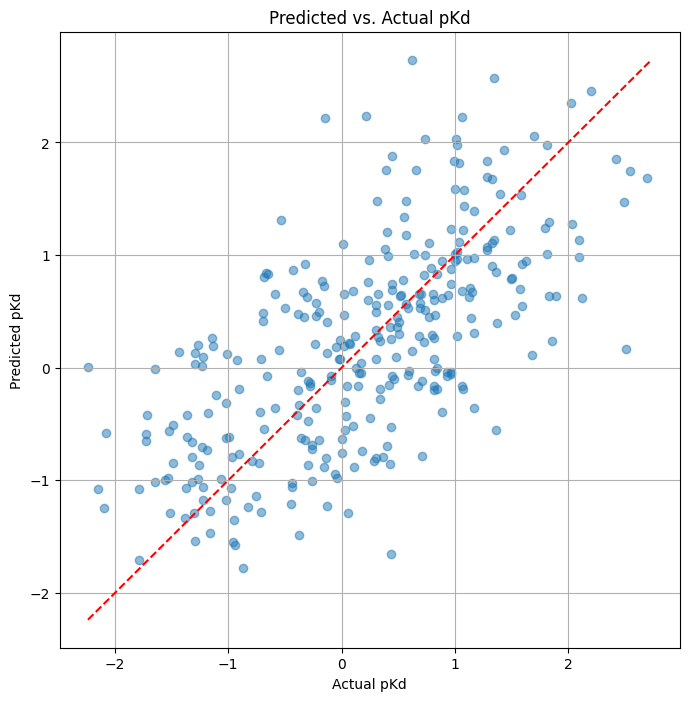

In [80]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_actual(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Handle cases where preds or targets might be single values
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            all_preds.extend(preds)
            all_targets.extend(targets)

    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    # Add a diagonal line for perfect prediction
    min_val = min(min(all_targets), min(all_preds))
    max_val = max(max(all_targets), max(all_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

# Use the trained model (debug_model) and the test_loader
plot_predictions_vs_actual(debug_model, test_loader, device='cpu')